# Preprocessed Videos EDA [v4]

### Contents

- Check the landmark extremes
- Explore the none frames
- Checking some things are consistent before and after preprocessing
- Explore the none frames

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import vizualisation as viz
import video_analyzer as va
import shutil

2025-05-21 16:29:51.169656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747812591.353378    2682 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747812591.403118    2682 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 16:29:51.908731: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [4]:
timestamp = "04242025"
motion_version = "versionB"
pose_version = "versionB"
preprocess_version = "v4"

In [5]:
metadata = pd.read_csv(path_to_root + '/data/preprocessed/landmarks_metadata_'+preprocess_version+'.csv')

In [6]:
i = 0
metadata_row = metadata.iloc[i].copy()
raw_landmarks_path = path_to_root + f'/data/interim/RawPoseLandmarks/{pose_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
preprocessed_landmarks_path = path_to_root + f'/data/preprocessed/landmarks/{preprocess_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
video_path = path_to_root + f'/data/interim/RawCleanVideos/{metadata_row["filename"]}'
raw_landmarks = np.load(raw_landmarks_path, allow_pickle=True)
preprocessed_landmarks = np.load(preprocessed_landmarks_path, allow_pickle=True)
metadata_row

filename                               ajudar_ne_1.mp4
label                                           ajudar
data_source                                         ne
original_fps                                      12.0
original_frame_count                                44
original_duration_sec                         3.666667
start_frame                                          7
end_frame                                           36
processed_frame_count                               30
processed_duration_sec                             2.5
preprocess_version                                  v4
face_width                                    0.147576
shoulders_width                               0.333421
face_midpoint_to_shoulders_height             0.292776
left_hand_interpolated_none_frames                   7
right_hand_interpolated_none_frames                  6
left_hand_interpolated_frames                      0.0
right_hand_interpolated_frames                     1.0
original_l

## Full Dataset Analysis Info

Load all the analysis info .jsons for the full dataset and combine into a dataframe

In [7]:
p_metadata = pd.read_csv(path_to_root + f"data/preprocessed/landmarks_metadata_{preprocess_version}.csv")
p_metadata.head()

filename   label data_source  original_fps  original_frame_count  \
0  ajudar_ne_1.mp4  ajudar          ne      12.00000                    44   
1  ajudar_sb_2.mp4  ajudar          sb      29.97003                    79   
2  ajudar_uf_3.mp4  ajudar          uf      29.97003                   115   
3  ajudar_vl_4.mp4  ajudar          vl      29.97003                   141   
4  ajudar_vl_5.mp4  ajudar          vl      29.97000                   108   

   original_duration_sec  start_frame  end_frame  processed_frame_count  \
0               3.666667            7         36                     30   
1               2.635967            6         66                     61   
2               3.837167           24         89                     66   
3               4.704700           11        126                    116   
4               3.603604            0        106                    107   

   processed_duration_sec  ... shoulders_width  \
0                2.500000  ...        0.333421   
1                2.035367  ...        0.206200   
2                2.202200  ...        0.205890   
3                3.870533  ...        0.210215   
4                3.570237  ...        0.243479   

   face_midpoint_to_shoulders_height  left_hand_interpolated_none_frames  \
0                           0.292776                                   7   
1                           0.216821                                   0   
2                           0.222293                                   0   
3                           0.240169                                  25   
4                           0.246769                                  13   

   right_hand_interpolated_none_frames  left_hand_interpolated_frames  \
0                                    6                            0.0   
1                                    0                            0.0   
2                                    0                            0.0   
3                                    9                            7.0   
4                                   12                            0.0   

   right_hand_interpolated_frames  original_left_hand_none_frames  \
0                             1.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             7.0                            25.0   
4                             2.0                            13.0   

   original_right_hand_none_frames  final_left_hand_none_frames  \
0                              1.0                          0.0   
1                              0.0                          0.0   
2                              0.0                          0.0   
3                              8.0                         18.0   
4                             12.0                         13.0   

   final_right_hand_none_frames  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                          10.0  

[5 rows x 22 columns]

In [8]:
p_metadata.columns

Index(['filename', 'label', 'data_source', 'original_fps',
       'original_frame_count', 'original_duration_sec', 'start_frame',
       'end_frame', 'processed_frame_count', 'processed_duration_sec',
       'preprocess_version', 'face_width', 'shoulders_width',
       'face_midpoint_to_shoulders_height',
       'left_hand_interpolated_none_frames',
       'right_hand_interpolated_none_frames', 'left_hand_interpolated_frames',
       'right_hand_interpolated_frames', 'original_left_hand_none_frames',
       'original_right_hand_none_frames', 'final_left_hand_none_frames',
       'final_right_hand_none_frames'],
      dtype='object')

In [9]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [10]:
preprocess_version

'v4'

In [11]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "preprocessed", 
        "landmarks",
        preprocess_version,
        "individual_metadata",
        fn.replace("mp4", "json")
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [12]:
analysis_info_list[0]

metadata_filename metadata_label metadata_data_source  metadata_sign_id  \
0   ajudar_ne_1.mp4         ajudar                   ne                 2   

   metadata_signer_number  metadata_frame_count  metadata_fps  \
0                       1                    44          12.0   

   metadata_duration_sec  metadata_width  metadata_height  ...  \
0               3.666667             240              176  ...   

   interpolated_interpolation_info_right_hand_landmarks_interpolated_sequences_start_end_length  \
0              [[0, 2, 3], [24, 24, 1], [28, 29, 2]]                                              

   interpolated_interpolation_info_right_hand_landmarks_all_frames_imputed  \
0                                              False                         

  landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                         

   landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array  \
0  [3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                   

   landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array_no_trailing_values  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                             

   landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                                      

   landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                           

  landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array  \
0  [3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                   

   landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array_no_trailing_values  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                              

   landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array_no_trailing_values  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                                      

[1 rows x 304 columns]

In [13]:
analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)

/tmp/ipykernel_2682/574225212.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)


In [14]:
analysis_info.columns[-8:]

Index(['landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array',
       'landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array',
       'landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array_no_trailing_values',
       'landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values',
       'landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array',
       'landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array',
       'landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array_no_trailing_values',
       'landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array_no_trailing_values'],
      dtype='object')

In [15]:
# get the last 8 columns of the df
array_maxes = analysis_info.iloc[:, -8:].map(lambda x: np.max(x))
array_maxes

landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array  \
0                                                    1                          
1                                                    0                          
2                                                    0                          
3                                                    1                          
4                                                    1                          
..                                                 ...                          
145                                                  1                          
146                                                  0                          
147                                                  0                          
148                                                  0                          
149                                                  0                          

     landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array  \
0                                                    4                                   
1                                                    0                                   
2                                                    0                                   
3                                                    8                                   
4                                                   10                                   
..                                                 ...                                   
145                                                  2                                   
146                                                  0                                   
147                                                  0                                   
148                                                  0                                   
149                                                  0                                   

     landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array_no_trailing_values  \
0                                                    0                                             
1                                                    0                                             
2                                                    0                                             
3                                                    1                                             
4                                                    1                                             
..                                                 ...                                             
145                                                  0                                             
146                                                  0                                             
147                                                  0                                             
148                                                  0                                             
149                                                  0                                             

     landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values  \
0                                                    0                                                      
1                                                    0                                                      
2                                                    0                                                      
3                                                    8                                                      
4                                                   10                                                      
..                                                 ...                                          

array([[<Axes: title={'center': 'landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array_no_trailing_values'}>]],
      dtype=object)

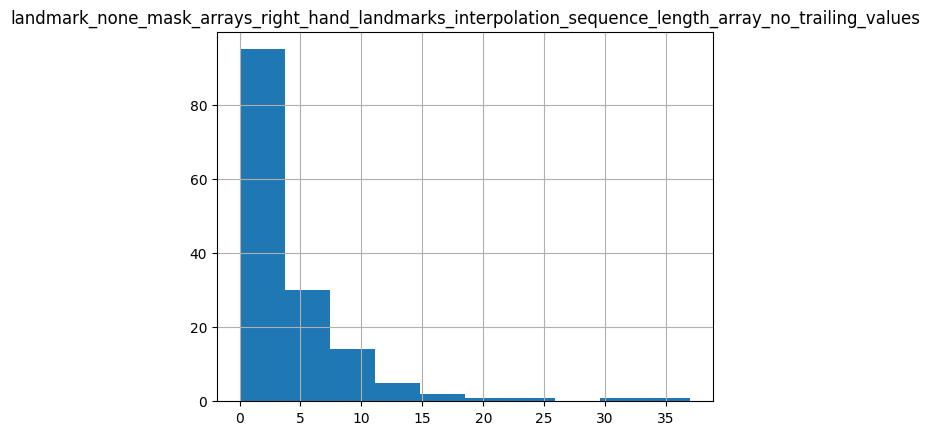

In [16]:
array_maxes[['landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array_no_trailing_values']].hist()

array([[<Axes: title={'center': 'landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values'}>]],
      dtype=object)

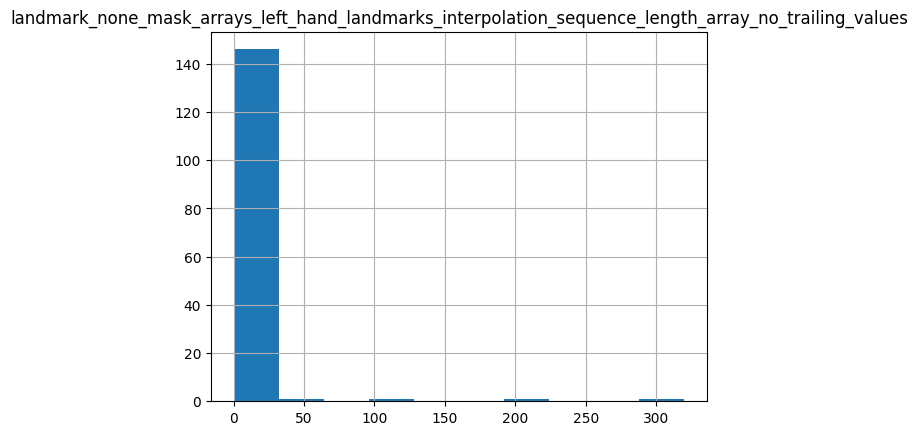

In [22]:
array_maxes[['landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values']].hist()

<Axes: >

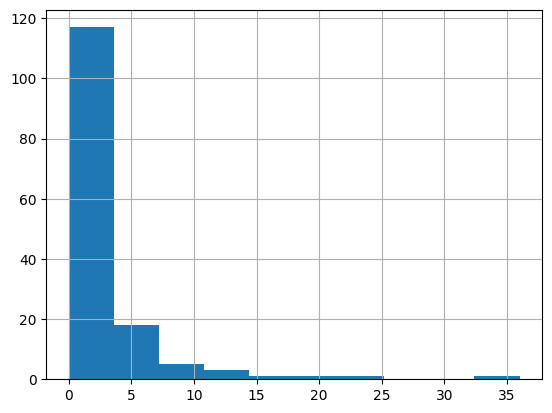

In [96]:
array_maxes[array_maxes['landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values'] < 100].landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values.hist()

In [48]:
array_maxes.max()

landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array                                   1
landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array                        320
landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array_no_trailing_values                1
landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values     320
landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array                                  1
landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array                        37
landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array_no_trailing_values               1
landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array_no_trailing_values     37
dtype: int64

In [30]:
analysis_info.columns[:35]

Index(['metadata_filename', 'metadata_label', 'metadata_data_source',
       'metadata_sign_id', 'metadata_signer_number', 'metadata_frame_count',
       'metadata_fps', 'metadata_duration_sec', 'metadata_width',
       'metadata_height', 'metadata_needs_flip', 'metadata_cleaned',
       'metadata_preprocessing_version', 'metadata_face_width_aim',
       'metadata_shoulders_width_aim',
       'metadata_face_midpoint_to_shoulders_height_aim',
       'metadata_shoulders_y_aim', 'metadata_use_statistic',
       'metadata_use_stationary_frames', 'metadata_skip_stationary_frames',
       'metadata_start_frame', 'metadata_end_frame', 'metadata_start_time',
       'metadata_end_time', 'metadata_start_percent', 'metadata_end_percent',
       'metadata_new_frame_count', 'metadata_new_duration_sec',
       'metadata_new_duration_percent', 'raw_reference_points_use_statistic',
       'raw_reference_points_use_stationary_frames',
       'raw_reference_points_total_frames_used',
       'raw_referen

<Axes: >

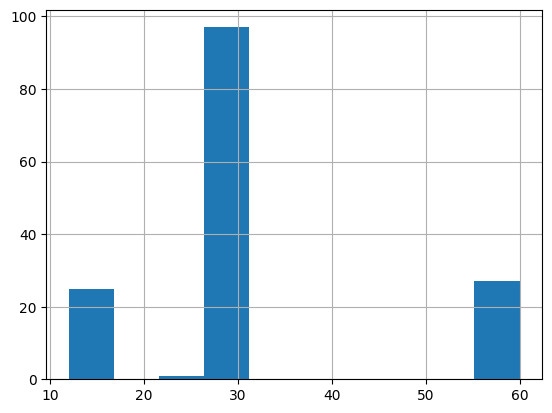

In [33]:
analysis_info.metadata_fps.hist()

<Axes: >

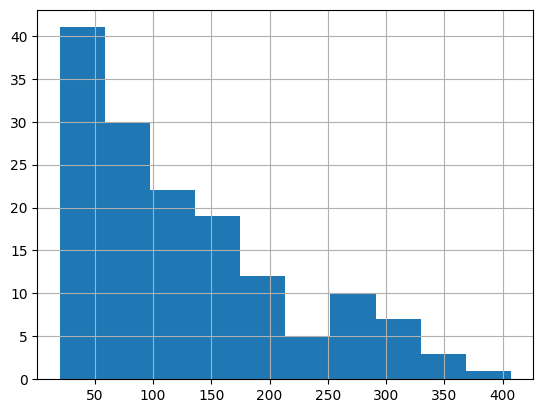

In [32]:
analysis_info.metadata_new_frame_count.hist()

<Axes: >

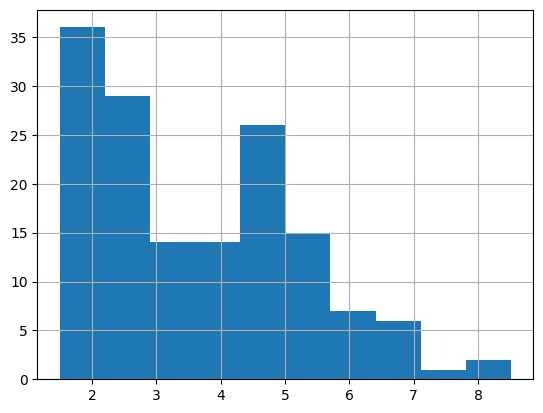

In [34]:
analysis_info.metadata_new_duration_sec.hist()

In [13]:
analysis_info.head()

metadata_filename metadata_label metadata_data_source  metadata_sign_id  \
0   ajudar_ne_1.mp4         ajudar                   ne                 2   
1   ajudar_sb_2.mp4         ajudar                   sb                 1   
2   ajudar_uf_3.mp4         ajudar                   uf                 0   
3   ajudar_vl_4.mp4         ajudar                   vl                 0   
4   ajudar_vl_5.mp4         ajudar                   vl                 0   

   metadata_signer_number  metadata_frame_count  metadata_fps  \
0                       1                    44      12.00000   
1                       1                    79      29.97003   
2                       1                   115      29.97003   
3                       1                   141      29.97003   
4                       2                   108      29.97000   

   metadata_duration_sec  metadata_width  metadata_height  ...  \
0               3.666667             240              176  ...   
1               2.635967            1280              720  ...   
2               3.837167             480              270  ...   
3               4.704700            1920             1080  ...   
4               3.603604            1920             1080  ...   

   interpolated_interpolation_info_right_hand_landmarks_interpolated_frame_indices  \
0                              [0, 1, 2, 24, 28, 29]                                 
1                                                 []                                 
2                                                 []                                 
3                  [0, 5, 6, 9, 64, 70, 75, 77, 100]                                 
4                                           [62, 99]                                 

   interpolated_interpolation_info_right_hand_landmarks_interpolated_sequences_start_end_length  \
0              [[0, 2, 3], [24, 24, 1], [28, 29, 2]]                                              
1                                                 []                                              
2                                                 []                                              
3  [[0, 0, 1], [5, 6, 2], [9, 9, 1], [64, 64, 1],...                                              
4                         [[62, 62, 1], [99, 99, 1]]                                              

  landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                         
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                         
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                         
3  [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                         
4  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...                         

   landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array  \
0  [3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                   
3  [0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                   
4  [0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10, ...                                   

   landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array_no_trailing_values  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                             
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                             
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                             
3  [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                                             
4  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...                                             

   landmark_none_mask_arrays_left_hand_landmarks_int

## Example Videos

In [15]:
analysis_info[(analysis_info['trimmed_none_analysis_overall_none_landmark_frames'] ==0)].metadata_data_source.value_counts()

metadata_data_source
sb    8
uf    8
vl    7
Name: count, dtype: int64

In [21]:
data_sources = []
labels = []
frame_lists = []
for i, row in analysis_info.sort_values(by = 'trimmed_none_analysis_overall_none_landmark_frames').iterrows():
    label = row['metadata_label']
    data_source = row['metadata_data_source']
    fps = row['metadata_fps']
    if label in labels:
        continue
    if data_source in data_sources:
        continue
    data_sources.append(data_source)
    labels.append(label)
    print(label, row.trimmed_reference_points_total_frames_used)

    demo_app_dir = path_to_root + f'/data/Demo App (Development)/'
    demo_app_raw_video_dir = demo_app_dir + 'Example Raw Videos/'
    demo_app_skeleton_dir = demo_app_dir + 'Example Skeleton Videos/'

    raw_video_path = path_to_root + f'/data/interim/RawCleanVideos/{row["metadata_filename"]}'
    shutil.copy(raw_video_path, demo_app_raw_video_dir + row['metadata_filename'])
    
    landmarks_path = path_to_root + f'/data/preprocessed/landmarks/{preprocess_version}/{row["metadata_filename"].replace(".mp4", ".npy")}'
    landmarks = np.load(landmarks_path, allow_pickle=True)
    skeleton_video_path = demo_app_skeleton_dir + row['metadata_filename']
    frame_list = viz.draw_landmarks_on_video_with_frame(results_list = landmarks, output_path = skeleton_video_path, fps = fps)
    frame_lists.append(frame_list)

    if sorted(data_sources) == ['ne', 'sb', 'uf', 'vl']:
        print(f"Found all data sources: {data_sources}")
        break

comer 56


casa 155
cabeça 65
ajudar 30
Found all data sources: ['uf', 'vl', 'sb', 'ne']


## Check the logic of the preprocessing

### Offsets
After alignment, the offsets should be close to 0.

#### X

Text(0.5, 1.02, 'Horizontal Offsets at different stages of preprocessing')

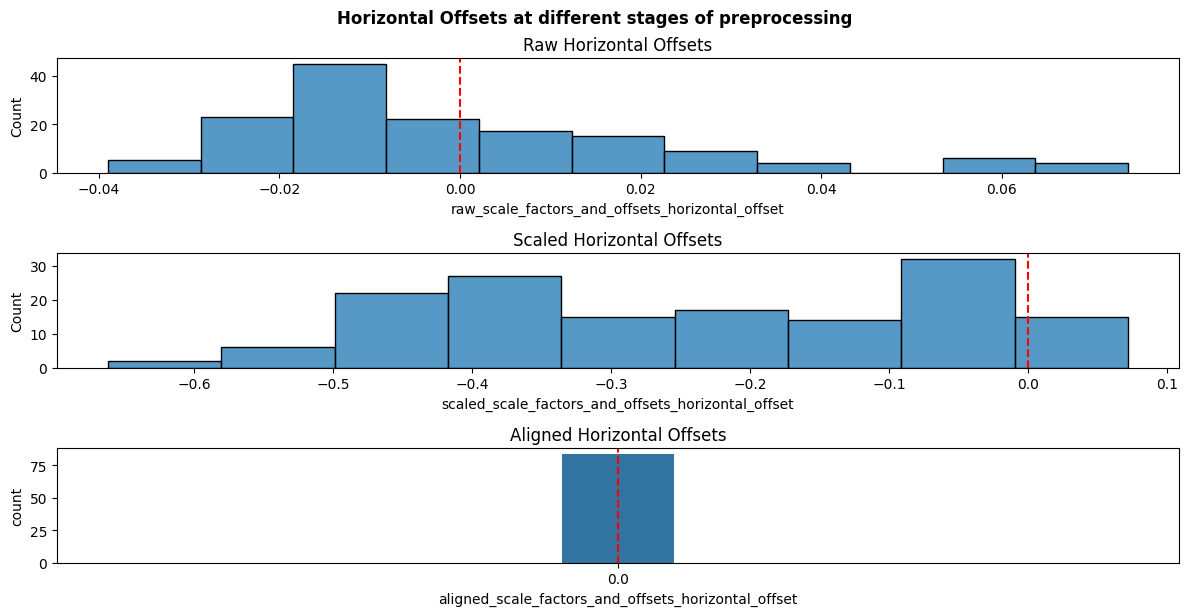

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_horizontal_offset', ax=ax1)
ax1.set_title('Raw Horizontal Offsets')
# ax1.set_xlim(-0.05, 0.05)
ax1.axvline(x=0, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_horizontal_offset', ax=ax2) 
ax2.set_title('Scaled Horizontal Offsets')
# ax2.set_xlim(-.8, 0.2)
ax2.axvline(x=0, color='red', linestyle='--')

sns.countplot(data=analysis_info, x='aligned_scale_factors_and_offsets_horizontal_offset', ax=ax3, width=0.01)
ax3.set_title('Aligned Horizontal Offsets')
ax3.set_xlim(-0.05, 0.05)
ax3.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.suptitle("Horizontal Offsets at different stages of preprocessing", fontweight = "bold", y = 1.02)

#### Y

Text(0.5, 1.02, 'Vertical Offsets at different stages of preprocessing')

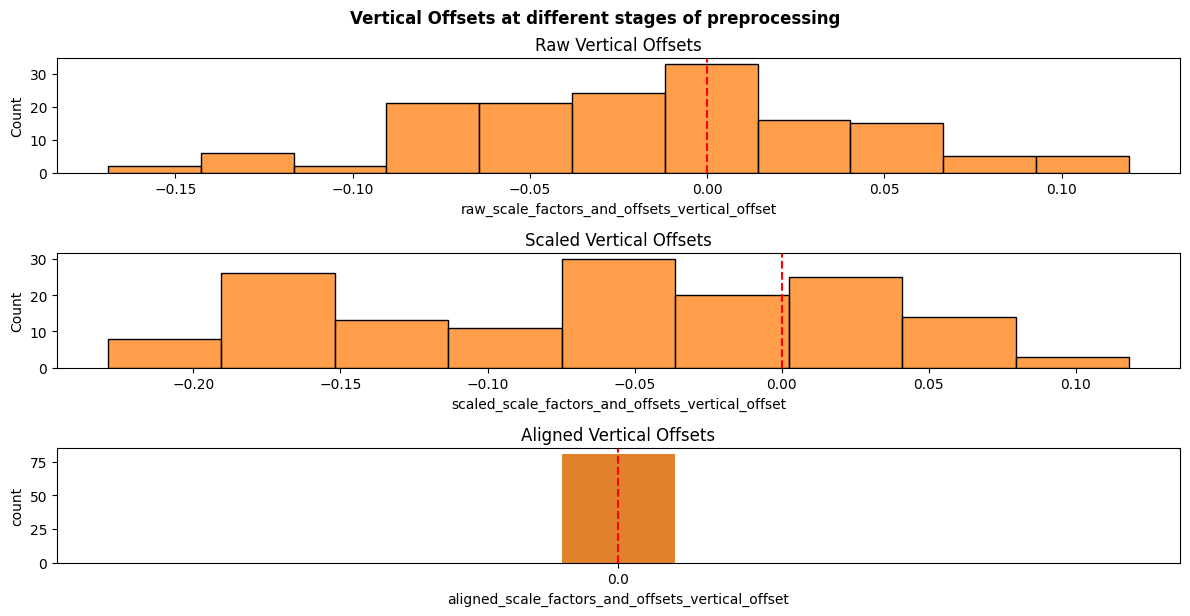

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_vertical_offset', ax=ax1, color = "tab:orange")
ax1.set_title('Raw Vertical Offsets')
# ax1.set_xlim(-0.05, 0.05)
ax1.axvline(x=0, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_vertical_offset', ax=ax2, color = "tab:orange")
ax2.set_title('Scaled Vertical Offsets')
# ax2.set_xlim(-.8, 0.2)
ax2.axvline(x=0, color='red', linestyle='--')

sns.countplot(data=analysis_info, x='aligned_scale_factors_and_offsets_vertical_offset', ax=ax3, width=0.01, color = "tab:orange")
ax3.set_title('Aligned Vertical Offsets')
ax3.set_xlim(-0.05, 0.05)
ax3.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.suptitle("Vertical Offsets at different stages of preprocessing", fontweight = "bold", y = 1.02)

### Scale Factors

Text(0.5, 1.02, 'Scale Factors at different stages of preprocessing')

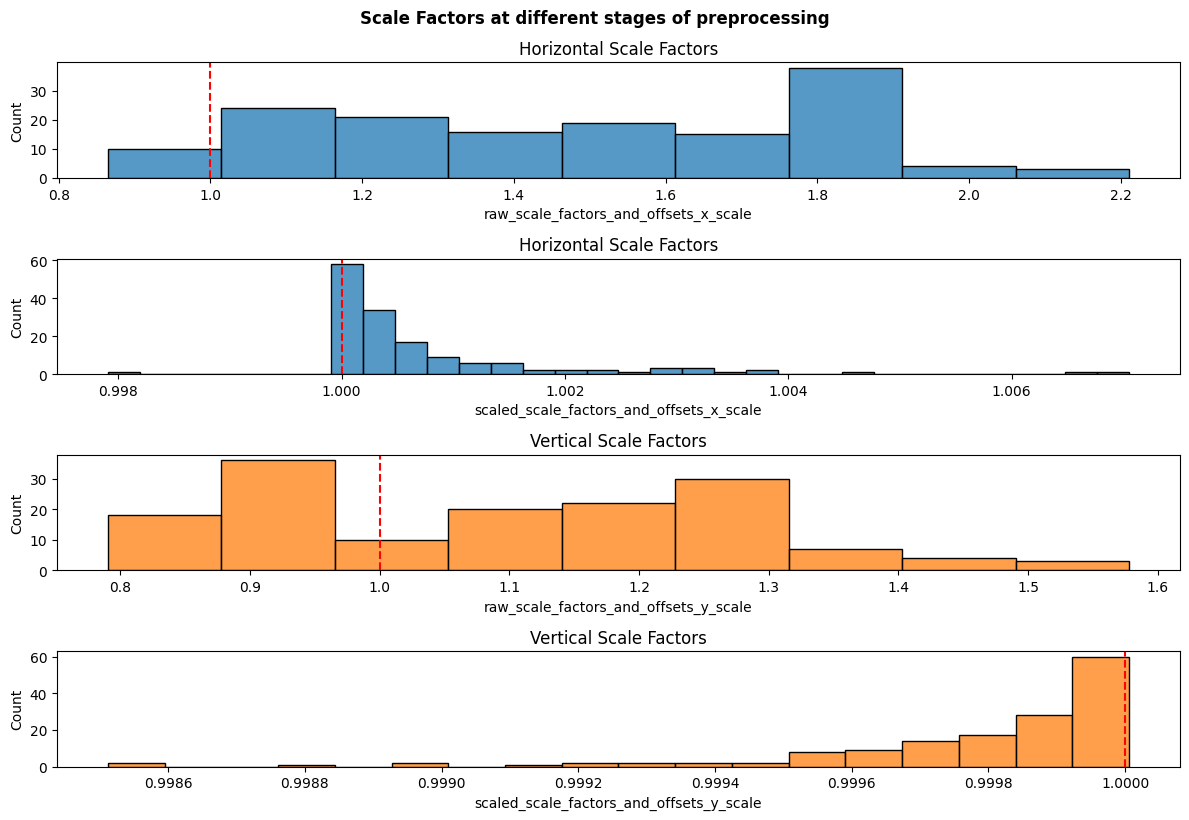

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_x_scale', ax=ax1, color = "tab:blue")
ax1.set_title('Horizontal Scale Factors')
ax1.axvline(x=1, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_x_scale', ax=ax2, color = "tab:blue")
ax2.set_title('Horizontal Scale Factors')
ax2.axvline(x=1, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_y_scale', ax=ax3, color = "tab:orange")
ax3.set_title('Vertical Scale Factors')
ax3.axvline(x=1, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_y_scale', ax=ax4, color = "tab:orange")
ax4.set_title('Vertical Scale Factors')
ax4.axvline(x=1, color='red', linestyle='--')

plt.tight_layout()
plt.suptitle("Scale Factors at different stages of preprocessing", fontweight = "bold", y = 1.02)

Text(0.5, 1.02, 'Scale Factors at different stages of preprocessing')

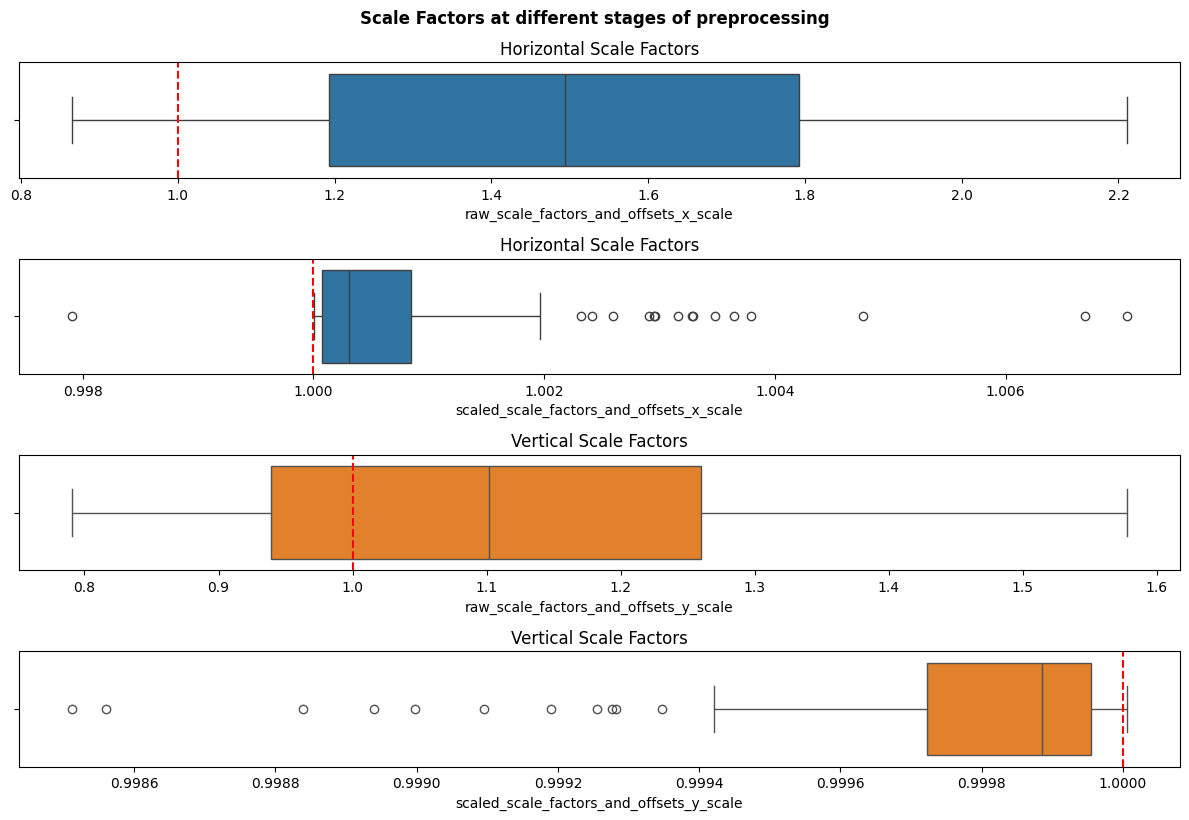

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

sns.boxplot(data=analysis_info, x='raw_scale_factors_and_offsets_x_scale', ax=ax1, color = "tab:blue")
ax1.set_title('Horizontal Scale Factors')
ax1.axvline(x=1, color='red', linestyle='--')

sns.boxplot(data=analysis_info, x='scaled_scale_factors_and_offsets_x_scale', ax=ax2, color = "tab:blue")
ax2.set_title('Horizontal Scale Factors')
ax2.axvline(x=1, color='red', linestyle='--')

sns.boxplot(data=analysis_info, x='raw_scale_factors_and_offsets_y_scale', ax=ax3, color = "tab:orange")
ax3.set_title('Vertical Scale Factors')
ax3.axvline(x=1, color='red', linestyle='--')

sns.boxplot(data=analysis_info, x='scaled_scale_factors_and_offsets_y_scale', ax=ax4, color = "tab:orange")
ax4.set_title('Vertical Scale Factors')
ax4.axvline(x=1, color='red', linestyle='--')

plt.tight_layout()
plt.suptitle("Scale Factors at different stages of preprocessing", fontweight = "bold", y = 1.02)

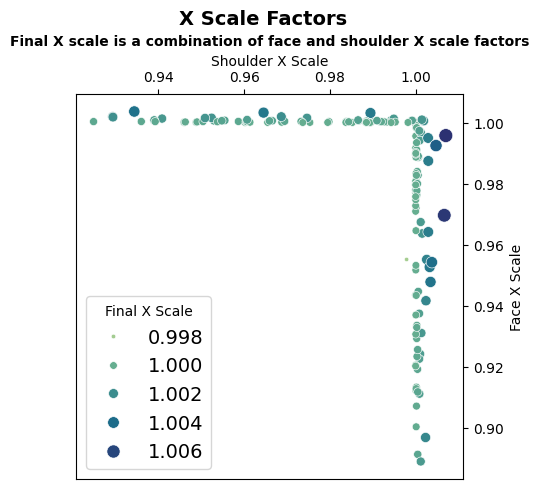

In [20]:
# plot scaled_scale_factors_and_offsets_x_scale against scaled_scale_factors_and_offsets_face_x_scale & scaled_scale_factors_and_offsets_shoulders_x_scale
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=analysis_info, 
    x='scaled_scale_factors_and_offsets_shoulders_x_scale', 
    y='scaled_scale_factors_and_offsets_face_x_scale',
    hue = 'scaled_scale_factors_and_offsets_x_scale',
    palette = "crest",
    size = 'scaled_scale_factors_and_offsets_x_scale',
    sizes = (10, 100),
    )
plt.suptitle("X Scale Factors", y = 1.05, fontweight = "bold", fontsize = 14)
plt.title("Final X scale is a combination of face and shoulder X scale factors", fontweight = "bold", fontsize = 10)
plt.xlabel("Shoulder X Scale")
plt.ylabel("Face X Scale")
plt.legend(title = "Final X Scale", fontsize = 14)
# Turn on the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# Move ticks to top and right
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

# Move labels to top and right
ax.xaxis.set_label_position('top')
ax.yaxis.set_label_position('right')


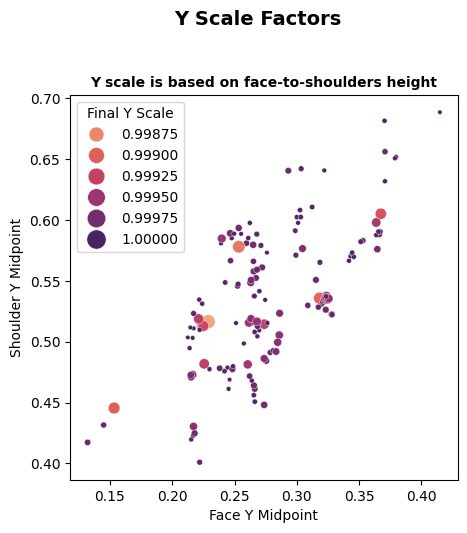

In [21]:
# plot scaled_scale_factors_and_offsets_x_scale against scaled_scale_factors_and_offsets_face_x_scale & scaled_scale_factors_and_offsets_shoulders_x_scale
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=analysis_info, 
    x='raw_reference_points_face_midpoint_y', 
    y='raw_reference_points_shoulders_midpoint_y',
    hue = 'scaled_scale_factors_and_offsets_y_scale',
    palette = "flare",
    size = 'scaled_scale_factors_and_offsets_y_scale',
    sizes = (100, 10),
    )
plt.suptitle("Y Scale Factors", y = 1.05, fontweight = "bold", fontsize = 14)
plt.title("Y scale is based on face-to-shoulders height", fontweight = "bold", fontsize = 10)
plt.xlabel("Face Y Midpoint")
plt.ylabel("Shoulder Y Midpoint")
plt.legend(title = "Final Y Scale", fontsize = 10)
# Turn on the right and top spines
# ax.spines['right'].set_visible(True)
# ax.spines['top'].set_visible(True)

# # Move ticks to top and right
# ax.xaxis.set_ticks_position('top')
# ax.yaxis.set_ticks_position('right')

# # Move labels to top and right
# ax.xaxis.set_label_position('top')
# ax.yaxis.set_label_position('right')


### Motion Trimming

In [48]:
def get_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group < lower_bound) | (group > upper_bound)]

def get_outlier_df(df, col):
    outliers = []
    for ds, ds_info in df.groupby('metadata_data_source'):
        outlier = get_outliers(ds_info[col])
        outlier_row = df.iloc[outlier.index][['metadata_filename', 'metadata_data_source', col]]
        outliers.append(outlier_row)
    outliers_df = pd.concat(outliers)
    outliers_df['col'] = col + '_outliers'
    return outliers_df

def get_minmax_df(df, col, exclude_df):
    include_df = df[~df.index.isin(exclude_df.index)]

    min_idx = include_df.groupby('metadata_data_source')[col].idxmin()
    max_idx = include_df.groupby('metadata_data_source')[col].idxmax()

    # Get the full rows for these min/max values using concat instead of append
    # Create separate dataframes for min and max with labels
    min_rows = include_df.loc[min_idx].assign(type='min')[['metadata_filename', 'metadata_data_source', col]]
    min_rows['col'] = col + '_min'
    max_rows = include_df.loc[max_idx].assign(type='max')[['metadata_filename', 'metadata_data_source', col]]
    max_rows['col'] = col + '_max'
    # Combine them
    minmax_rows = pd.concat([min_rows, max_rows]).sort_values('metadata_data_source')
    return minmax_rows

def get_outlier_df_and_minmax_df(df, col):
    outliers_df = get_outlier_df(df, col)
    minmax_df = get_minmax_df(df, col, outliers_df)
    return outliers_df, minmax_df

#### Overall Distribution of the Motion Trimming Results

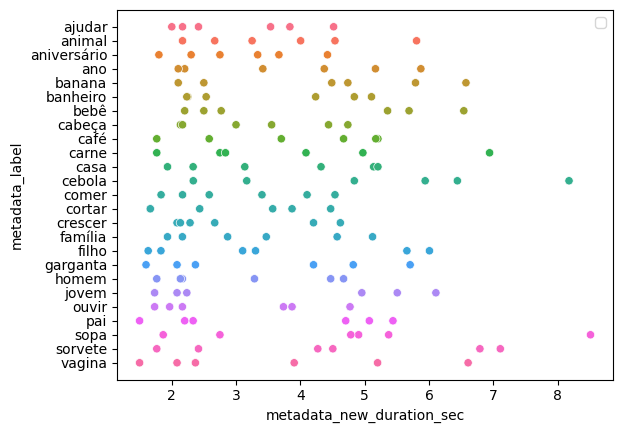

In [17]:
sns.scatterplot(data=analysis_info, x='metadata_new_duration_sec', y='metadata_label', hue='metadata_label')
plt.legend('')


<Axes: xlabel='metadata_new_duration_sec', ylabel='metadata_label'>

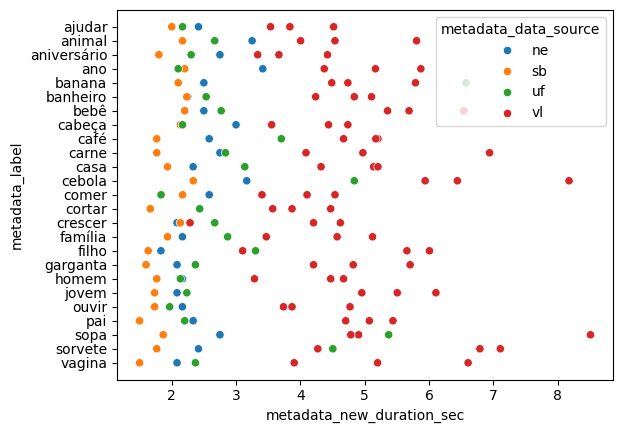

In [25]:
sns.scatterplot(data=analysis_info, x='metadata_new_duration_sec', y='metadata_label', hue='metadata_data_source')


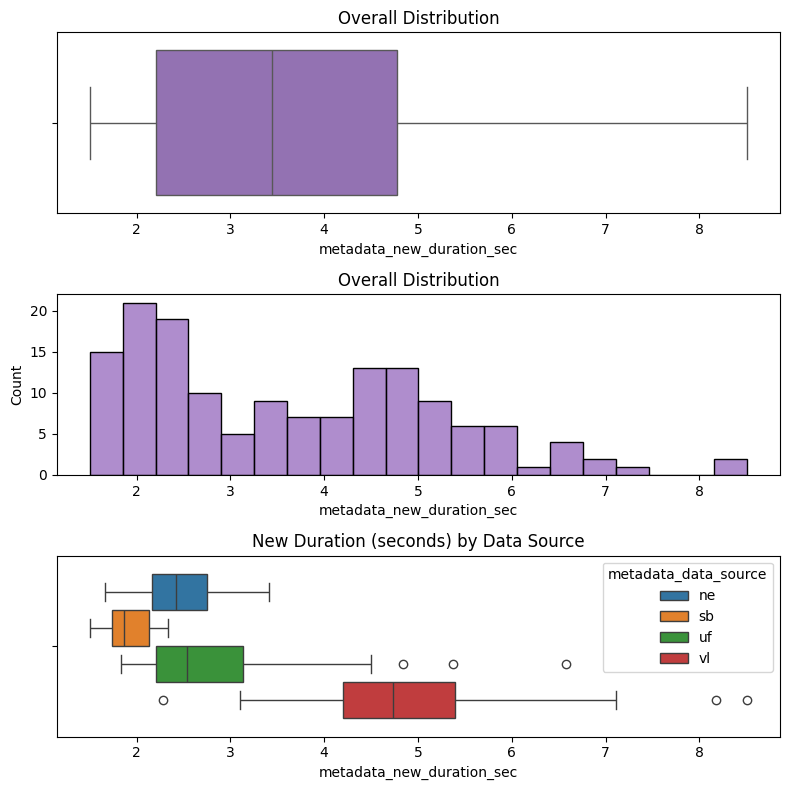

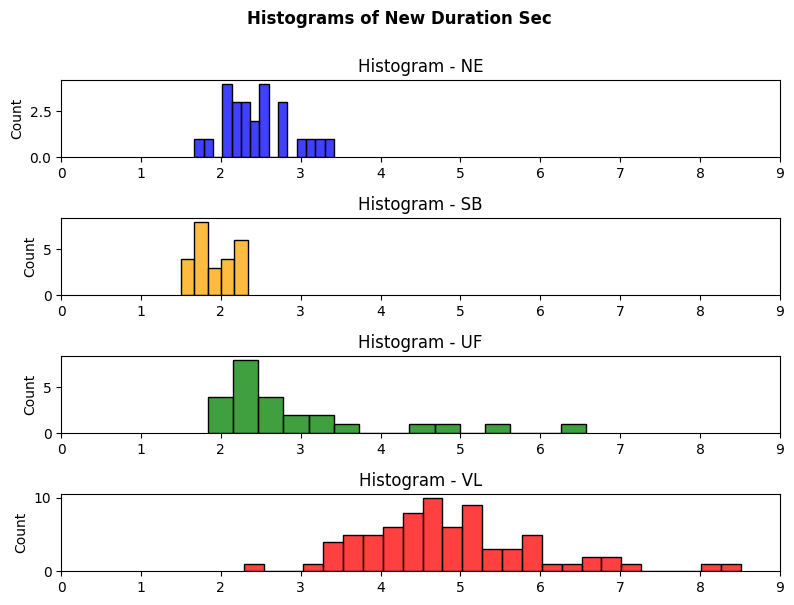

In [18]:
# boxplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

sns.boxplot(data=analysis_info, x='metadata_new_duration_sec', color="tab:purple", ax=ax1)
ax1.set_title("Overall Distribution")

sns.histplot(data=analysis_info, x='metadata_new_duration_sec', color="tab:purple", ax=ax2, bins=20)
ax2.set_title("Overall Distribution")

sns.boxplot(data=analysis_info, x='metadata_new_duration_sec', hue='metadata_data_source', ax=ax3)
ax3.set_title("Distribution by Data Source")

plt.tight_layout()
plt.title("New Duration (seconds) by Data Source")

plt.show()
# 5 subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 6));
# kde plot of metadata_new_duration_sec for each data source, histogram of metadata_new_duration_sec for each data source
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_new_duration_sec', ax = axs[0], bins=15, color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_new_duration_sec', ax = axs[1], bins=5, color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_new_duration_sec', ax = axs[2], bins=15, color = 'green',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_new_duration_sec', ax = axs[3], bins=25, color = 'red',)

axs[0].set_title('Histogram - NE');
axs[1].set_title('Histogram - SB');
axs[2].set_title('Histogram - UF');
axs[3].set_title('Histogram - VL');
for ax in axs:
    ax.set_xlim(0, 9)
    ax.set_xlabel('')
    # ax.set_ylim(0,8)
plt.suptitle('Histograms of New Duration Sec', fontweight = 'bold', y = 1);
plt.tight_layout()

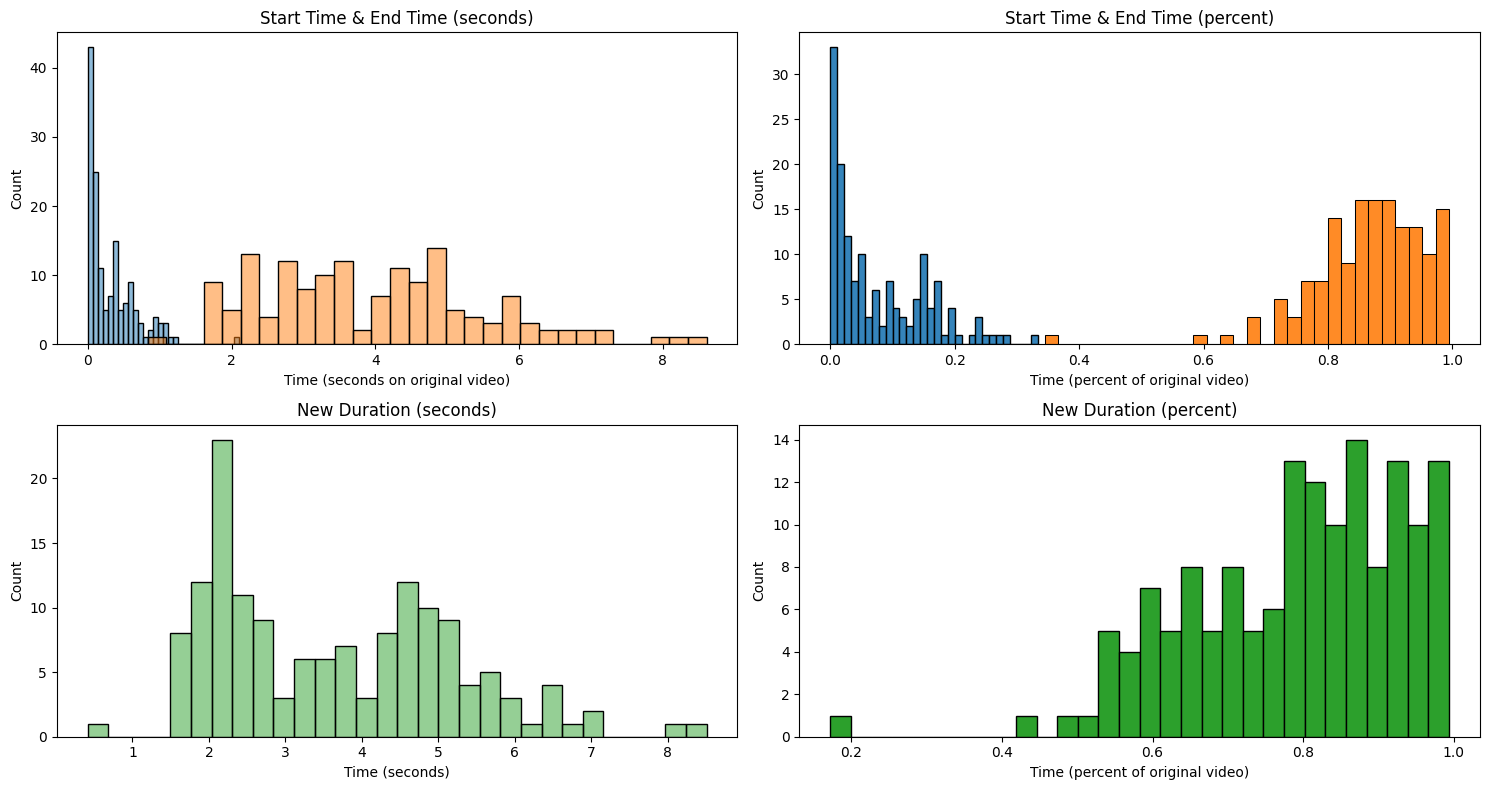

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(analysis_info.metadata_start_time, bins=30, ax=ax[0, 0], alpha = 0.5)
sns.histplot(analysis_info.metadata_end_time, bins=30, ax=ax[0, 0], alpha = 0.5)
ax[0, 0].set_title('Start Time & End Time (seconds)')
ax[0, 0].set_xlabel("Time (seconds on original video)")

sns.histplot(analysis_info.metadata_start_percent, bins=30, ax=ax[0, 1], alpha = 0.9) 
sns.histplot(analysis_info.metadata_end_percent, bins=30, ax=ax[0, 1], alpha = 0.9) 
ax[0, 1].set_title('Start Time & End Time (percent)')
ax[0, 1].set_xlabel("Time (percent of original video)")

sns.histplot(analysis_info.metadata_new_duration_sec, bins=30, ax=ax[1, 0], alpha = 0.5, color = "tab:green") 
ax[1, 0].set_title('New Duration (seconds)')
ax[1, 0].set_xlabel("Time (seconds)")
sns.histplot(analysis_info.metadata_new_duration_percent, bins=30, ax=ax[1, 1], alpha = 1, color = "tab:green") 
ax[1, 1].set_title('New Duration (percent)')   
ax[1, 1].set_xlabel("Time (percent of original video)")
plt.tight_layout()

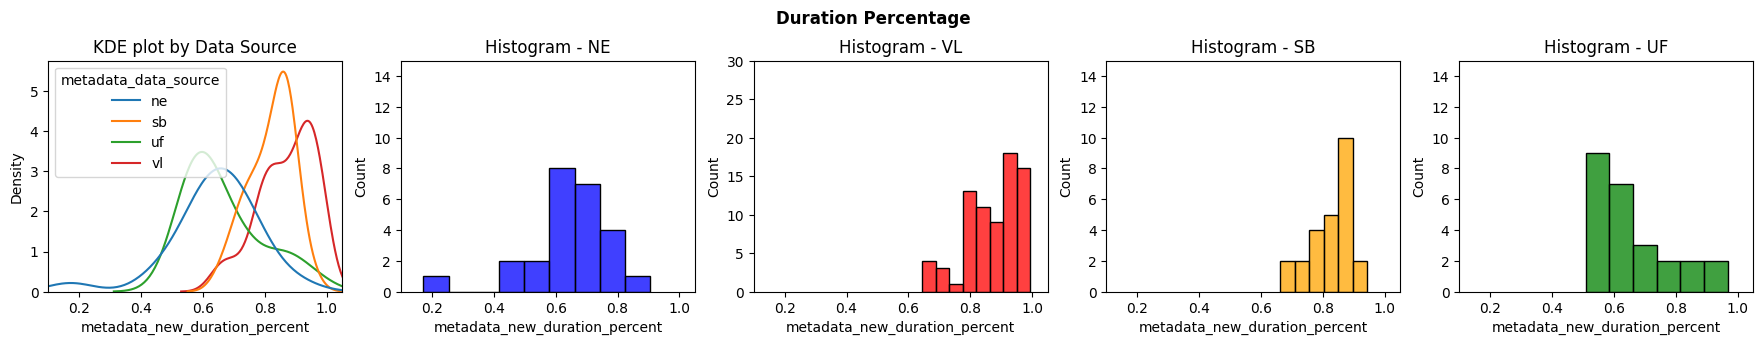

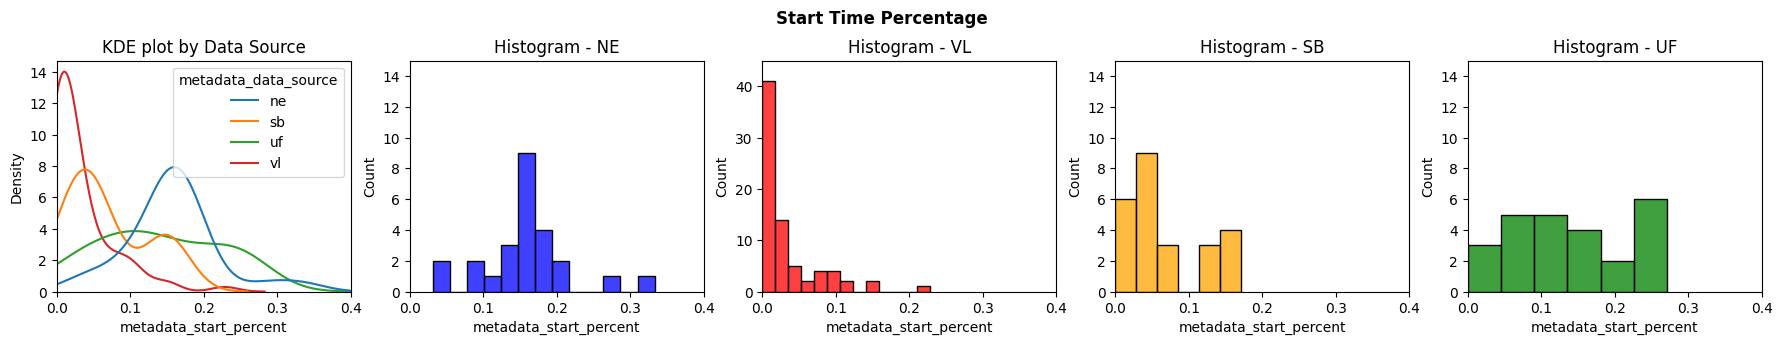

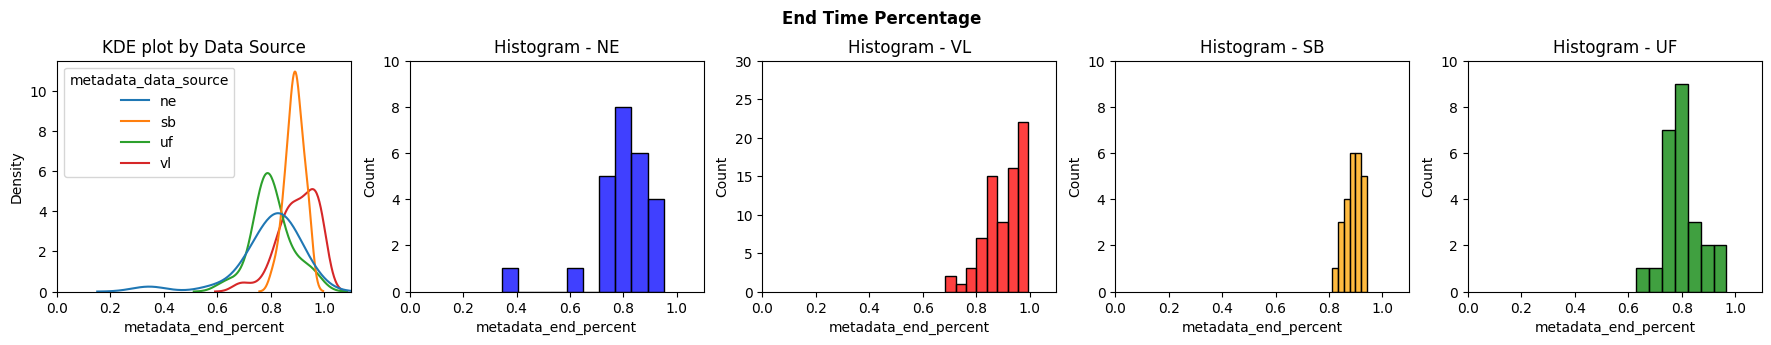

In [58]:
# 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of metadata_new_duration_percent for each data source, histogram of metadata_new_duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'metadata_new_duration_percent', hue = 'metadata_data_source', ax = axs[0], common_norm=False)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_new_duration_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_new_duration_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_new_duration_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_new_duration_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0.1, 1.05)
    if i == 0:
        # ax.set_ylim(0, 5)
        pass
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 15)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('Duration Percentage', fontweight = 'bold', y = 1.05);

fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of metadata_new_duration_percent for each data source, histogram of metadata_new_duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'metadata_start_percent', hue = 'metadata_data_source', ax = axs[0], common_norm=False)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_start_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_start_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_start_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_start_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 0.4)
    if i == 0:
        # ax.set_ylim(0, 5)
        pass
    elif i == 2:
        ax.set_ylim(0, 45)
    else:
        ax.set_ylim(0, 15)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('Start Time Percentage', fontweight = 'bold', y = 1.05);


fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of metadata_new_duration_percent for each data source, histogram of metadata_new_duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'metadata_end_percent', hue = 'metadata_data_source', ax = axs[0], common_norm=False)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_end_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_end_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_end_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_end_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 1.1)
    if i == 0:
        # ax.set_ylim(0, 5)
        pass
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 10)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('End Time Percentage', fontweight = 'bold', y = 1.05);

#### Checking the edge cases for issues

In [143]:
new_duration_outliers, new_duration_minmaxes = get_outlier_df_and_minmax_df(analysis_info, 'metadata_new_duration_sec')
start_percent_outliers, start_percent_minmaxes = get_outlier_df_and_minmax_df(analysis_info, 'metadata_start_percent')
end_percent_outliers, end_percent_minmaxes = get_outlier_df_and_minmax_df(analysis_info, 'metadata_end_percent')

In [ ]:
pd.concat([new_duration_outliers, start_percent_outliers, end_percent_outliers, new_duration_minmaxes, start_percent_minmaxes, end_percent_minmaxes]).sort_values('col').drop_duplicates('metadata_filename')

metadata_filename metadata_data_source  metadata_new_duration_sec  \
99         filho_vl_4.mp4                   vl                        NaN   
140      sorvete_uf_3.mp4                   uf                        NaN   
19           ano_sb_2.mp4                   sb                        NaN   
132         sopa_ne_1.mp4                   ne                        NaN   
32      banheiro_uf_3.mp4                   uf                        NaN   
1         ajudar_sb_2.mp4                   sb                        NaN   
30      banheiro_ne_1.mp4                   ne                        NaN   
101        filho_vl_6.mp4                   vl                        NaN   
16   aniversário_vl_5.mp4                   vl                        NaN   
122        ouvir_uf_3.mp4                   uf                        NaN   
98         filho_uf_3.mp4                   uf                        NaN   
74         comer_uf_3.mp4                   uf                        NaN   
97         filho_sb_2.mp4                   sb                        NaN   
144       vagina_ne_1.mp4                   ne                        NaN   
12   aniversário_ne_1.mp4                   ne                        NaN   
113        homem_vl_6.mp4                   vl                        NaN   
141      sorvete_vl_4.mp4                   vl                   7.107100   
18           ano_ne_1.mp4                   ne                   3.416667   
67        cebola_sb_2.mp4                   sb                   2.335667   
78        cortar_ne_1.mp4                   ne                   1.666667   
127          pai_sb_2.mp4                   sb                   1.501500   
26        banana_uf_3.mp4                   uf                   6.573233   
68        cebola_uf_3.mp4                   uf                   4.838167   
134         sopa_uf_3.mp4                   uf                   5.372033   
70        cebola_vl_5.mp4                   vl                   8.174833   
87       crescer_vl_4.mp4                   vl                   2.285617   
136         sopa_vl_5.mp4                   vl                   8.508500   
42        cabeça_ne_1.mp4                   ne                        NaN   
145       vagina_sb_2.mp4                   sb                        NaN   
80        cortar_uf_3.mp4                   uf                        NaN   
81        cortar_vl_4.mp4                   vl                        NaN   
4         ajudar_vl_5.mp4                   vl                        NaN   
114        jovem_ne_1.mp4                   ne                        NaN   
71        cebola_vl_6.mp4                   vl                        NaN   
63          casa_vl_4.mp4                   vl                        NaN   
23           ano_vl_6.mp4                   vl                        NaN   
15   aniversário_vl_4.mp4                   vl                        NaN   
84       crescer_ne_1.mp4                   ne                        NaN   
48          café_ne_1.mp4                   ne                        NaN   
138      sorvete_ne_1.mp4                   ne                        NaN   
125        ouvir_vl_6.mp4                   vl                        NaN   

                                    col  metadata_start_percent  \
99             metadata_end_percent_max                     NaN   
140            metadata_end_percent_max                     NaN   
19             metadata_end_percent_max                     NaN   
132            metadata_end_percent_max                     NaN   
32             metadata_end_percent_min                     NaN   
1              metadata_end_percent_min                     NaN   
30             metadata_end_percent_min                     NaN   
101            metadata_end_percent_min                     NaN   
16        metadata_end_percent_outliers                     NaN   
122       metadata_end_percent_outliers                     NaN   
98        metadata_end_percent_outli

## Check the extreme values

### Are the extreme values from the expected landmarks
- min_

### Do the extreme values exceed the frame

#### Raw

#### Preprocessed

### What is the distribution of the extreme values like

#### Overall

##### Raw Landmarks

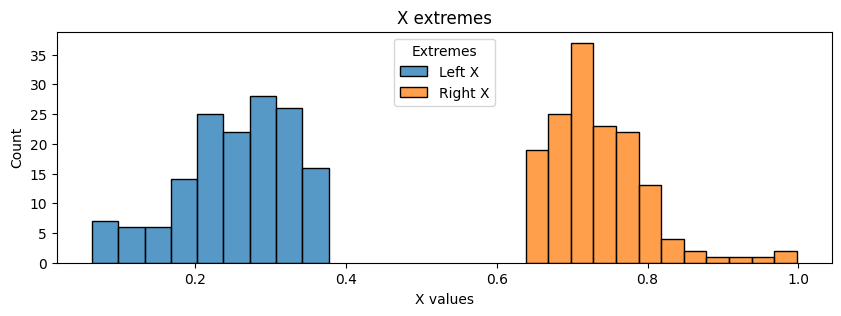

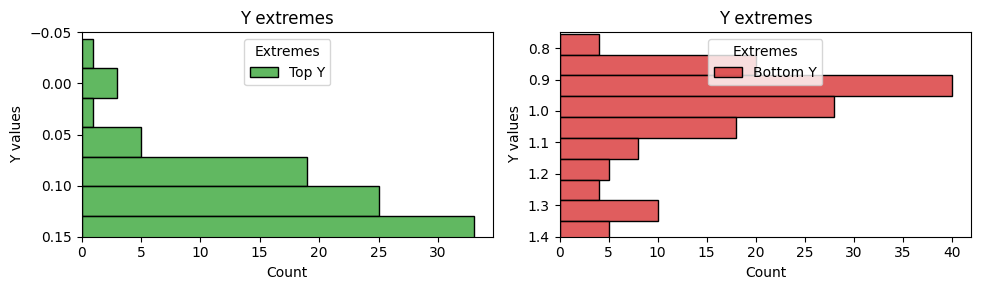

In [46]:
# side by side
fig, axs = plt.subplots(figsize=(10, 3));
sns.histplot(analysis_info['raw_landmark_extremes_overall_left_x'])
sns.histplot(analysis_info['raw_landmark_extremes_overall_right_x'])
plt.title('X extremes')
plt.xlabel('X values')
plt.legend(title = 'Extremes', labels = ['Left X', 'Right X'], loc = 'upper center')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3));
sns.histplot(data = analysis_info, y = 'raw_landmark_extremes_overall_top_y', ax = axs[0], color = 'tab:green')
axs[0].set_title('Y extremes')
axs[0].set_ylabel('Y values')
axs[0].legend(title = 'Extremes', labels = ['Top Y'], loc = 'upper center')
axs[0].set_ylim(0.15, -0.05)
sns.histplot(data = analysis_info, y = 'raw_landmark_extremes_overall_bottom_y', ax = axs[1], color = 'tab:red')
axs[1].set_title('Y extremes')
axs[1].set_ylabel('Y values')
axs[1].set_ylim(1.4, .75)
axs[1].legend(title = 'Extremes', labels = ['Bottom Y'], loc = 'upper center')
plt.tight_layout()

##### Preprocessed Landmarks

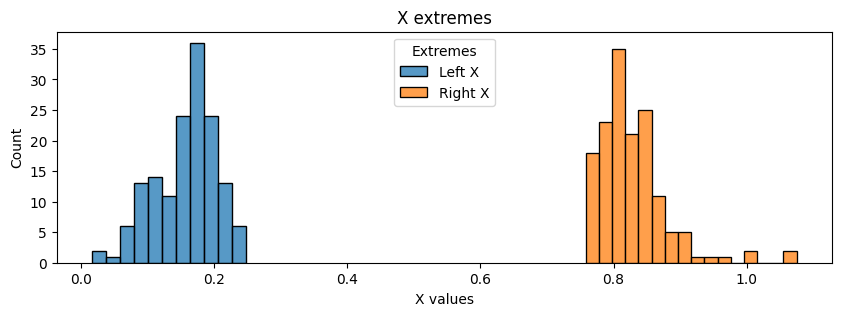

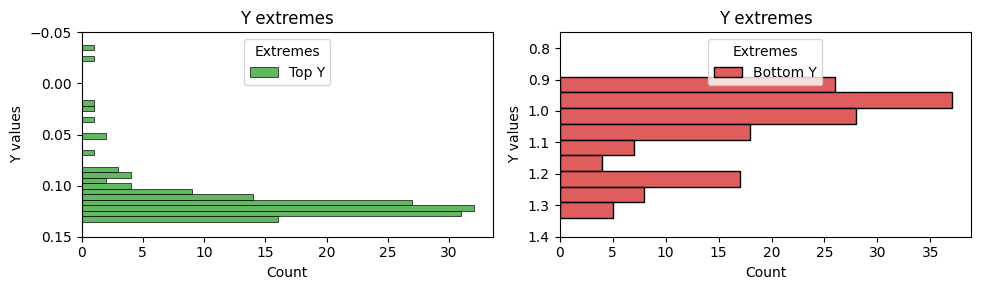

In [43]:
# side by side
fig, axs = plt.subplots(figsize=(10, 3));
sns.histplot(analysis_info['trimmed_landmark_extremes_overall_left_x'])
sns.histplot(analysis_info['trimmed_landmark_extremes_overall_right_x'])
plt.title('X extremes')
plt.xlabel('X values')
plt.legend(title = 'Extremes', labels = ['Left X', 'Right X'], loc = 'upper center')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3));
sns.histplot(data = analysis_info, y = 'trimmed_landmark_extremes_overall_top_y', ax = axs[0], color = 'tab:green')
axs[0].set_title('Y extremes')
axs[0].set_ylabel('Y values')
axs[0].legend(title = 'Extremes', labels = ['Top Y'], loc = 'upper center')
axs[0].set_ylim(0.15, -0.05)
sns.histplot(data = analysis_info, y = 'trimmed_landmark_extremes_overall_bottom_y', ax = axs[1], color = 'tab:red')
axs[1].set_title('Y extremes')
axs[1].set_ylabel('Y values')
axs[1].set_ylim(1.4, .75)
axs[1].legend(title = 'Extremes', labels = ['Bottom Y'], loc = 'upper center')
plt.tight_layout()

##### Raw Landmarks (By Data Source)

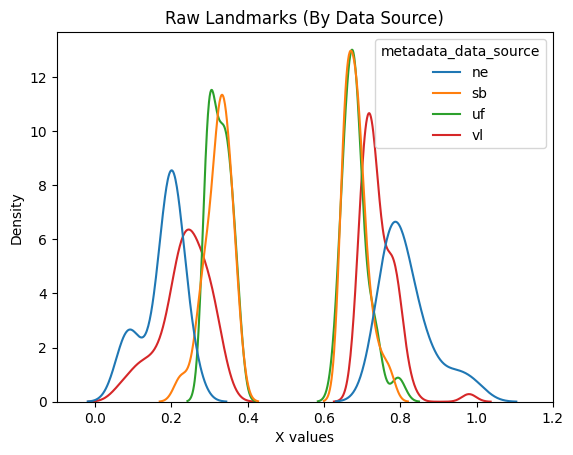

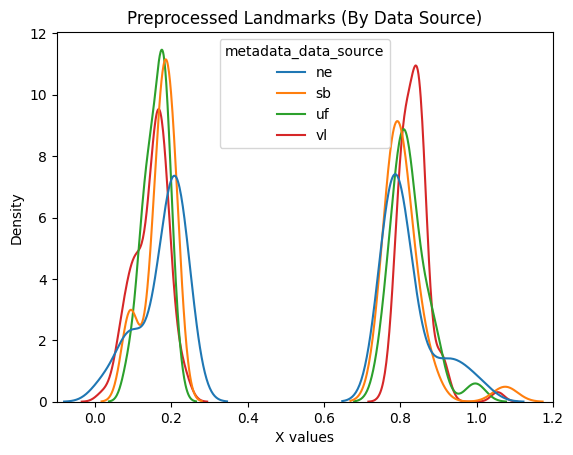

In [55]:
sns.kdeplot(data = analysis_info, x = 'raw_landmark_extremes_overall_left_x', hue = 'metadata_data_source', common_norm=False)
sns.kdeplot(data = analysis_info, x = 'raw_landmark_extremes_overall_right_x', hue = 'metadata_data_source', common_norm=False)
plt.title('Raw Landmarks (By Data Source)')
plt.xlabel('X values')
plt.xlim(-0.1, 1.2)
plt.show()

sns.kdeplot(data = analysis_info, x = 'trimmed_landmark_extremes_overall_left_x', hue = 'metadata_data_source', common_norm=False)
sns.kdeplot(data = analysis_info, x = 'trimmed_landmark_extremes_overall_right_x', hue = 'metadata_data_source', common_norm=False)
plt.title('Preprocessed Landmarks (By Data Source)')
plt.xlabel('X values')
plt.xlim(-0.1, 1.2)
plt.show()

##### Preprocessed Landmarks (By Data Source)

In [195]:
left_x_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_left_x')
right_x_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_right_x')
top_y_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_top_y')
bottom_y_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_bottom_y')

Text(0.5, 1.05, 'X extremes for preprocessed landmarks')

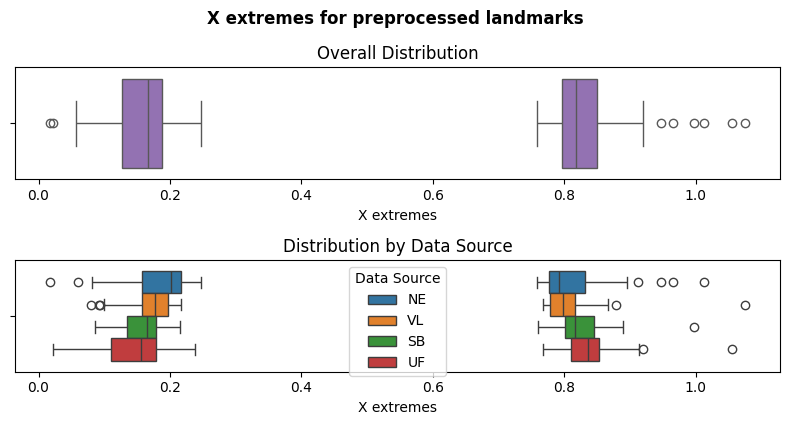

In [165]:
# boxplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))

sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_left_x', color="tab:purple", ax=ax1)
sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_right_x', color="tab:purple", ax=ax1)
ax1.set_title("Overall Distribution")
ax1.set_xlabel("X extremes")

sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_left_x', hue='metadata_data_source', ax=ax2)
sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_right_x', hue='metadata_data_source', ax=ax2)
ax2.set_title("Distribution by Data Source")
ax2.legend(title = 'Data Source', labels = ['NE', 'VL', 'SB', 'UF'], loc = 'upper center')
ax2.set_xlabel("X extremes")


plt.tight_layout()
plt.suptitle("X extremes for preprocessed landmarks", fontweight = "bold", y = 1.05)

In [205]:
pd.concat([left_x_outliers, right_x_outliers]).sort_values(['metadata_filename'])

metadata_filename metadata_data_source  \
6         animal_ne_1.mp4                   ne   
6         animal_ne_1.mp4                   ne   
12   aniversário_ne_1.mp4                   ne   
12   aniversário_ne_1.mp4                   ne   
13   aniversário_sb_2.mp4                   sb   
36          bebê_ne_1.mp4                   ne   
37          bebê_sb_2.mp4                   sb   
41          bebê_vl_6.mp4                   vl   
43        cabeça_sb_2.mp4                   sb   
114        jovem_ne_1.mp4                   ne   
115        jovem_sb_2.mp4                   sb   
116        jovem_uf_3.mp4                   uf   
119        jovem_vl_6.mp4                   vl   
145       vagina_sb_2.mp4                   sb   

     trimmed_landmark_extremes_overall_left_x  \
6                                    0.016887   
6                                         NaN   
12                                   0.059389   
12                                        NaN   
13                                   0.079746   
36                                        NaN   
37                                        NaN   
41                                        NaN   
43                                   0.093766   
114                                       NaN   
115                                       NaN   
116                                       NaN   
119                                       NaN   
145                                  0.091728   

                                                   col  \
6    trimmed_landmark_extremes_overall_left_x_outliers   
6    trimmed_landmark_extremes_overall_right_x_outl...   
12   trimmed_landmark_extremes_overall_left_x_outliers   
12   trimmed_landmark_extremes_overall_right_x_outl...   
13   trimmed_landmark_extremes_overall_left_x_outliers   
36   trimmed_landmark_extremes_overall_right_x_outl...   
37   trimmed_landmark_extremes_overall_right_x_outl...   
41   trimmed_landmark_extremes_overall_right_x_outl...   
43   trimmed_landmark_extremes_overall_left_x_outliers   
114  trimmed_landmark_extremes_overall_right_x_outl...   
115  trimmed_landmark_extremes_overall_right_x_outl...   
116  trimmed_landmark_extremes_overall_right_x_outl...   
119  trimmed_landmark_extremes_overall_right_x_outl...   
145  trimmed_landmark_extremes_overall_left_x_outliers   

     trimmed_landmark_extremes_overall_right_x  
6                                          NaN  
6                                     0.964727  
12                                         NaN  
12                                    0.947182  
13                                         NaN  
36                                    0.912215  
37                                    0.878244  
41                                    0.919109  
43                                         NaN  
114                                   1.012666  
115                                   1.074987  
116                                   0.996563  
119                                   1.055275  
145                                        NaN

Text(0.5, 1.05, 'Y extremes for preprocessed landmarks')

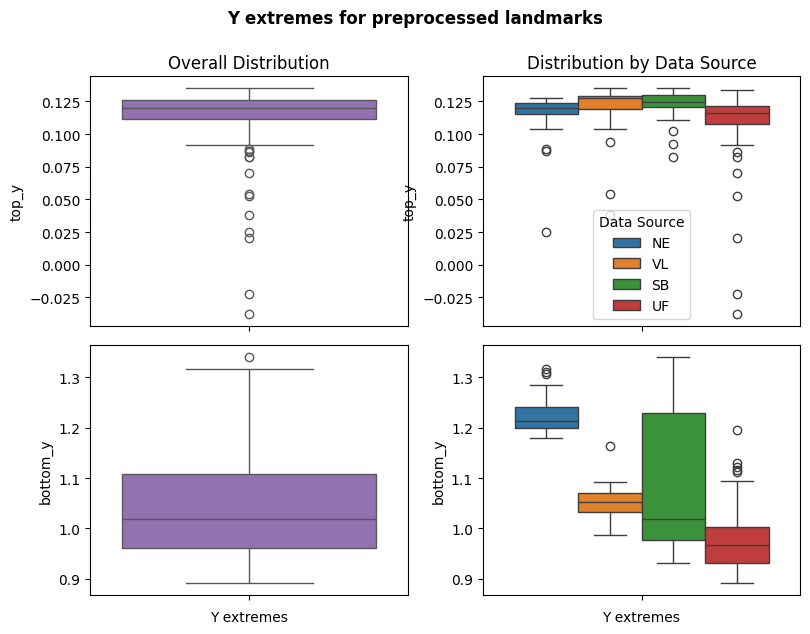

In [197]:
# boxplot
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 6))

sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_top_y', color="tab:purple", ax=ax1[0])
sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_bottom_y', color="tab:purple", ax=ax2[0])
ax1[0].set_title("Overall Distribution")
ax2[0].set_xlabel("Y extremes")
ax1[0].set_ylabel('top_y')
ax2[0].set_ylabel('bottom_y')

sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_top_y', hue='metadata_data_source', ax=ax1[1])
sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_bottom_y', hue='metadata_data_source', ax=ax2[1])
ax1[1].set_title("Distribution by Data Source")
ax1[1].legend(title = 'Data Source', labels = ['NE', 'VL', 'SB', 'UF'], loc = 'lower center')
ax2[1].legend().remove()
ax2[1].set_xlabel("Y extremes")
ax1[1].set_ylabel('top_y')
ax2[1].set_ylabel('bottom_y')



plt.tight_layout()
plt.suptitle("Y extremes for preprocessed landmarks", fontweight = "bold", y = 1.05)

In [206]:
top_y_outliers

metadata_filename metadata_data_source  \
42     cabeça_ne_1.mp4                   ne   
102  garganta_ne_1.mp4                   ne   
144    vagina_ne_1.mp4                   ne   
43     cabeça_sb_2.mp4                   sb   
103  garganta_sb_2.mp4                   sb   
145    vagina_sb_2.mp4                   sb   
50       café_uf_3.mp4                   uf   
104  garganta_uf_3.mp4                   uf   
146    vagina_uf_3.mp4                   uf   
45     cabeça_vl_4.mp4                   vl   
58      carne_vl_5.mp4                   vl   
106  garganta_vl_5.mp4                   vl   
137      sopa_vl_6.mp4                   vl   
147    vagina_vl_4.mp4                   vl   
148    vagina_vl_5.mp4                   vl   
149    vagina_vl_6.mp4                   vl   

     trimmed_landmark_extremes_overall_top_y  \
42                                  0.025160   
102                                 0.088840   
144                                 0.087018   
43                                  0.054183   
103                                 0.094060   
145                                 0.037783   
50                                  0.092028   
104                                 0.102645   
146                                 0.082567   
45                                  0.085943   
58                                  0.052756   
106                                 0.070232   
137                                 0.082452   
147                                 0.020134   
148                                -0.022703   
149                                -0.037876   

                                                  col  
42   trimmed_landmark_extremes_overall_top_y_outliers  
102  trimmed_landmark_extremes_overall_top_y_outliers  
144  trimmed_landmark_extremes_overall_top_y_outliers  
43   trimmed_landmark_extremes_overall_top_y_outliers  
103  trimmed_landmark_extremes_overall_top_y_outliers  
145  trimmed_landmark_extremes_overall_top_y_outliers  
50   trimmed_landmark_extremes_overall_top_y_outliers  
104  trimmed_landmark_extremes_overall_top_y_outliers  
146  trimmed_landmark_extremes_overall_top_y_outliers  
45   trimmed_landmark_extremes_overall_top_y_outliers  
58   trimmed_landmark_extremes_overall_top_y_outliers  
106  trimmed_landmark_extremes_overall_top_y_outliers  
137  trimmed_landmark_extremes_overall_top_y_outliers  
147  trimmed_landmark_extremes_overall_top_y_outliers  
148  trimmed_landmark_extremes_overall_top_y_outliers  
149  trimmed_landmark_extremes_overall_top_y_outliers

In [207]:
bottom_y_outliers

metadata_filename metadata_data_source  \
108    homem_ne_1.mp4                   ne   
132     sopa_ne_1.mp4                   ne   
144   vagina_ne_1.mp4                   ne   
109    homem_sb_2.mp4                   sb   
71    cebola_vl_6.mp4                   vl   
87   crescer_vl_4.mp4                   vl   
101    filho_vl_6.mp4                   vl   
113    homem_vl_6.mp4                   vl   
147   vagina_vl_4.mp4                   vl   

     trimmed_landmark_extremes_overall_bottom_y  \
108                                    1.311212   
132                                    1.306075   
144                                    1.317648   
109                                    1.164077   
71                                     1.111714   
87                                     1.130205   
101                                    1.121507   
113                                    1.196046   
147                                    1.116238   

                                                   col  
108  trimmed_landmark_extremes_overall_bottom_y_out...  
132  trimmed_landmark_extremes_overall_bottom_y_out...  
144  trimmed_landmark_extremes_overall_bottom_y_out...  
109  trimmed_landmark_extremes_overall_bottom_y_out...  
71   trimmed_landmark_extremes_overall_bottom_y_out...  
87   trimmed_landmark_extremes_overall_bottom_y_out...  
101  trimmed_landmark_extremes_overall_bottom_y_out...  
113  trimmed_landmark_extremes_overall_bottom_y_out...  
147  trimmed_landmark_extremes_overall_bottom_y_out...

## Check the None frames

*Note*
**When landmarks are None:**
- `pose_landmarks`: None if no pose detected in frame
- `face_landmarks`: None if no face detected
- `left_hand_landmarks`/`right_hand_landmarks`: None if hand not detected

**Key points about None values:**
- Landmarks are never individually None - entire group for a frame is either None or present
- If group is present for a frame, all landmarks in that group are included:
  - Pose: 33 landmarks
  - Face: 468 landmarks  
  - Each hand: 21 landmarks
- Only pose landmarks have visibility scores to detect unreliable points

### Distribution of None landmarks

(0.0, 50.0)

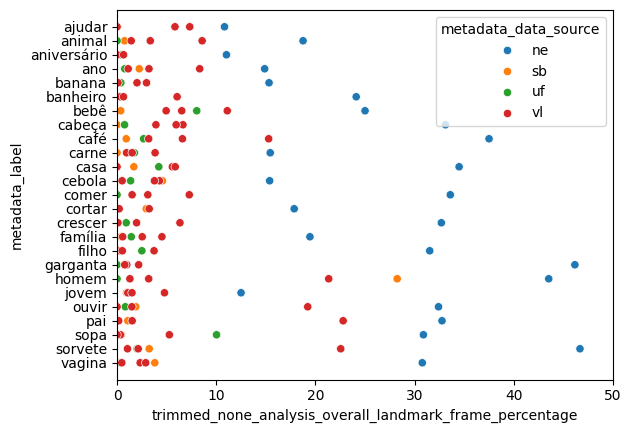

In [17]:
sns.scatterplot(data=analysis_info, x='trimmed_none_analysis_overall_landmark_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 50)


(0.0, 50.0)

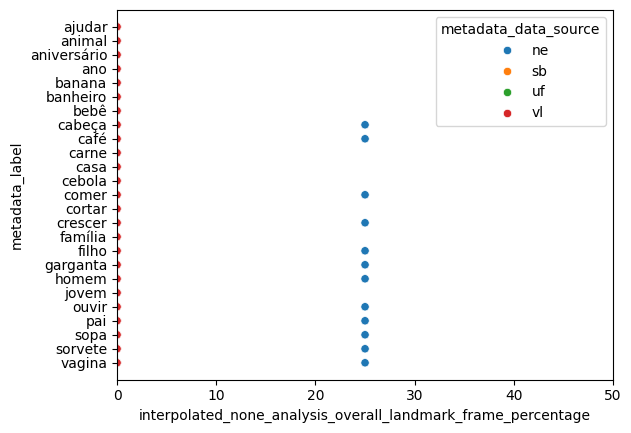

In [18]:
sns.scatterplot(data=analysis_info, x='interpolated_none_analysis_overall_landmark_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 50)


(0.0, 105.0)

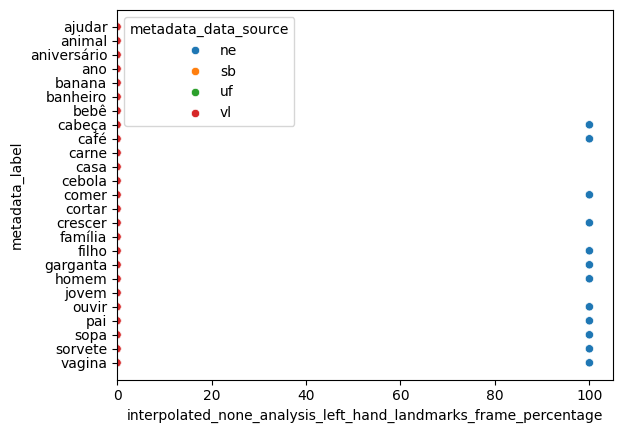

In [19]:
sns.scatterplot(data=analysis_info, x='interpolated_none_analysis_left_hand_landmarks_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 105)


(0.0, 105.0)

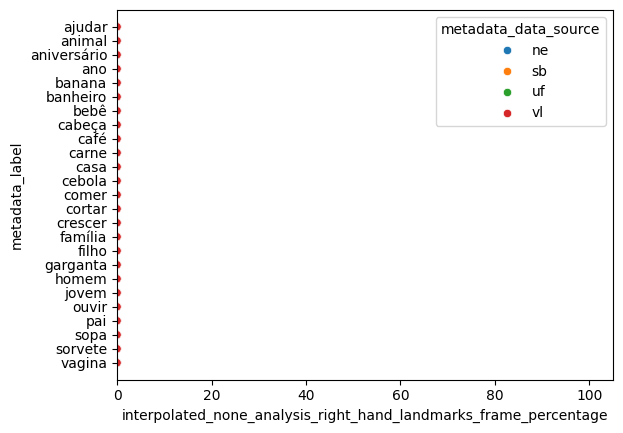

In [20]:
sns.scatterplot(data=analysis_info, x='interpolated_none_analysis_right_hand_landmarks_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 105)


(0.0, 105.0)

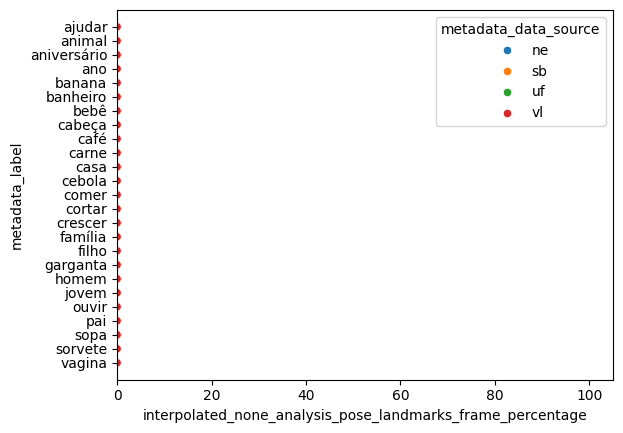

In [21]:
sns.scatterplot(data=analysis_info, x='interpolated_none_analysis_pose_landmarks_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 105)


(0.0, 105.0)

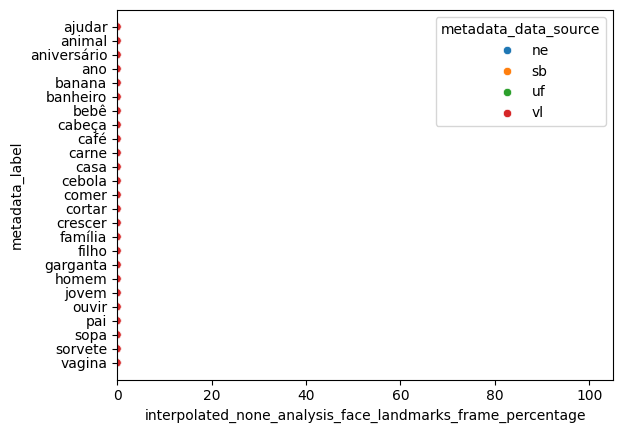

In [22]:
sns.scatterplot(data=analysis_info, x='interpolated_none_analysis_face_landmarks_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 105)


In [105]:
analysis_info.query('interpolated_none_analysis_left_hand_landmarks_frame_percentage==100.0')

metadata_filename metadata_label metadata_data_source  metadata_sign_id  \
42     cabeça_ne_1.mp4         cabeça                   ne                 0   
48       café_ne_1.mp4           café                   ne                 0   
72      comer_ne_1.mp4          comer                   ne                 0   
84    crescer_ne_1.mp4        crescer                   ne                 1   
96      filho_ne_1.mp4          filho                   ne                 0   
102  garganta_ne_1.mp4       garganta                   ne                 0   
108     homem_ne_1.mp4          homem                   ne                 0   
120     ouvir_ne_1.mp4          ouvir                   ne                 0   
126       pai_ne_1.mp4            pai                   ne                 2   
132      sopa_ne_1.mp4           sopa                   ne                 0   
138   sorvete_ne_1.mp4        sorvete                   ne                 0   
144    vagina_ne_1.mp4         vagina                   ne                 1   

     metadata_signer_number  metadata_frame_count  metadata_fps  \
42                        1                    61          12.0   
48                        1                    39          12.0   
72                        1                    51          12.0   
84                        1                    46          12.0   
96                        1                    33          12.0   
102                       1                    39          12.0   
108                       1                    41          12.0   
120                       1                    36          12.0   
126                       1                    41          12.0   
132                       1                    41          12.0   
138                       1                    32          12.0   
144                       1                    29          12.0   

     metadata_duration_sec  metadata_width  metadata_height  ...  \
42                5.083333             240              176  ...   
48                3.250000             240              176  ...   
72                4.250000             240              176  ...   
84                3.833333             240              176  ...   
96                2.750000             240              176  ...   
102               3.250000             240              176  ...   
108               3.416667             240              176  ...   
120               3.000000             240              176  ...   
126               3.416667             240              176  ...   
132               3.416667             240              176  ...   
138               2.666667             240              176  ...   
144               2.416667             240              176  ...   

     interpolated_interpolation_info_right_hand_landmarks_interpolated_frame_indices  \
42         [0, 1, 2, 3, 4, 29, 31, 32, 33, 34, 35, 36]                                 
48   [0, 1, 2, 3, 4, 7, 10, 11, 12, 14, 15, 25, 28,...                                 
72             [0, 1, 2, 3, 4, 25, 27, 28, 29, 30, 31]                                 
84                         [0, 1, 2, 3, 8, 21, 24, 25]                                 
96                               [0, 1, 2, 20, 21, 22]                                 
102  [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...                                 
108  [0, 1, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17...                                 
120                       [0, 1, 2, 3, 22, 24, 25, 26]                                 
126                    [0, 1, 4, 7, 8, 23, 24, 27, 28]                                 
132                     [0, 1, 11, 12, 15, 31, 32, 33]                                 
138  [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...                                 
144                                 [0, 1, 2, 3, 6, 7]                                 

     interpolated_interpolation_info_right_hand_landmarks_inte

In [104]:
for i, row in analysis_info.query('interpolated_none_analysis_overall_landmark_frame_percentage > 0').sort_values('interpolated_none_analysis_overall_landmark_frame_percentage', ascending=False).iterrows():
    print(row['metadata_filename'], '-',row['interpolated_none_analysis_overall_total_frames'], 'frames -',row['interpolated_none_analysis_overall_landmark_frame_percentage'], '%')
    print('left hand: ', row['interpolated_none_analysis_left_hand_landmarks_frame_percentage'],'%')
    print(row['interpolated_none_analysis_left_hand_landmarks_none_details'])
    print('right hand: ', row['interpolated_none_analysis_right_hand_landmarks_frame_percentage'],'%')
    print(row['interpolated_none_analysis_right_hand_landmarks_none_details'])
    print('---')
    print()


cabeça_ne_1.mp4 - 37 frames - 25.0 %
left hand:  100.0 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
right hand:  0.0 %
[]
---

café_ne_1.mp4 - 32 frames - 25.0 %
left hand:  100.0 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
right hand:  0.0 %
[]
---

comer_ne_1.mp4 - 32 frames - 25.0 %
left hand:  100.0 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
right hand:  0.0 %
[]
---

crescer_ne_1.mp4 - 26 frames - 25.0 %
left hand:  100.0 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
right hand:  0.0 %
[]
---

filho_ne_1.mp4 - 23 frames - 25.0 %
left hand:  100.0 %
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
right hand:  0.0 %
[]
---

garganta_ne_1.mp4 - 26 frame

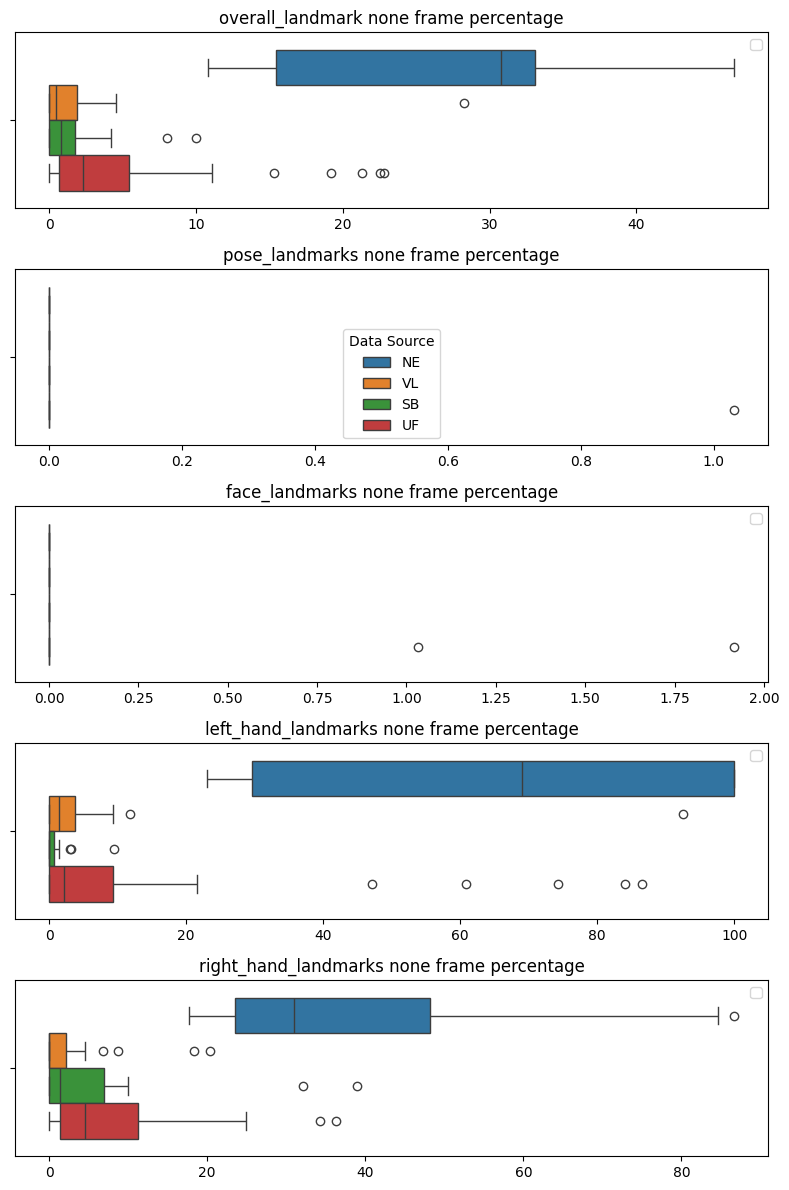

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(8, 12));
landmark_types = ['overall_landmark', 'pose_landmarks', 'face_landmarks', 'left_hand_landmarks', 'right_hand_landmarks']
for ax, landmark_type in zip(axs, landmark_types):
    sns.boxplot(data=analysis_info, x=f'trimmed_none_analysis_{landmark_type}_frame_percentage', hue='metadata_data_source', ax=ax)
    ax.legend('')
    ax.set_title(f'{landmark_type} none frame percentage')
    ax.set_xlabel('')
axs[1].legend(title = 'Data Source', labels = ['NE', 'VL', 'SB', 'UF'], loc = 'lower center')
plt.tight_layout()

### Look at Extreme Cases (Outliers, Minimums, and Maximums)

In [ ]:
get_outlier_df_and_minmax_df

In [51]:
pose_outliers  = get_outlier_df(analysis_info, 'trimmed_none_analysis_pose_landmarks_frame_percentage')
face_outliers = get_outlier_df(analysis_info, 'trimmed_none_analysis_face_landmarks_frame_percentage')
left_outliers, left_minmax = get_outlier_df_and_minmax_df(analysis_info, 'trimmed_none_analysis_left_hand_landmarks_frame_percentage')
right_outliers, right_minmax = get_outlier_df_and_minmax_df(analysis_info, 'trimmed_none_analysis_right_hand_landmarks_frame_percentage')

In [52]:
pose_outliers

metadata_filename metadata_data_source  \
9   animal_vl_4.mp4                   vl   

   trimmed_none_analysis_pose_landmarks_frame_percentage  \
9                                           1.030928       

                                                 col  
9  trimmed_none_analysis_pose_landmarks_frame_per...

In [57]:
face_outliers

metadata_filename metadata_data_source  \
9     animal_vl_4.mp4                   vl   
149   vagina_vl_6.mp4                   vl   

     trimmed_none_analysis_face_landmarks_frame_percentage  \
9                                             1.030928       
149                                           1.916933       

                                                   col  
9    trimmed_none_analysis_face_landmarks_frame_per...  
149  trimmed_none_analysis_face_landmarks_frame_per...

In [31]:
analysis_info.iloc[9].to_dict()

{'metadata_filename': 'animal_vl_4.mp4',
 'metadata_label': 'animal',
 'metadata_data_source': 'vl',
 'metadata_sign_id': 0,
 'metadata_signer_number': 1,
 'metadata_frame_count': 116,
 'metadata_fps': 23.976023976023978,
 'metadata_duration_sec': 4.838166666666666,
 'metadata_width': 1920,
 'metadata_height': 1080,
 'metadata_needs_flip': False,
 'metadata_cleaned': True,
 'metadata_preprocessing_version': 'v3',
 'metadata_face_width_aim': 0.155,
 'metadata_shoulders_width_aim': 0.35,
 'metadata_face_midpoint_to_shoulders_height_aim': 0.275,
 'metadata_shoulders_y_aim': 0.52,
 'metadata_use_statistic': 'mean',
 'metadata_use_stationary_frames': True,
 'metadata_skip_stationary_frames': False,
 'metadata_start_frame': 0,
 'metadata_end_frame': 96,
 'metadata_start_time': 0.0,
 'metadata_end_time': 4.004,
 'metadata_start_percent': 0.0,
 'metadata_end_percent': 0.8275862068965517,
 'metadata_new_frame_count': 96,
 'metadata_new_duration_sec': 4.004,
 'metadata_new_duration_percent': 0.8

In [59]:
analysis_info[analysis_info['metadata_start_frame'] == 0]

metadata_filename metadata_label metadata_data_source  \
4         ajudar_vl_5.mp4         ajudar                   vl   
5         ajudar_vl_6.mp4         ajudar                   vl   
9         animal_vl_4.mp4         animal                   vl   
17   aniversário_vl_6.mp4    aniversário                   vl   
19           ano_sb_2.mp4            ano                   sb   
33      banheiro_vl_4.mp4       banheiro                   vl   
34      banheiro_vl_5.mp4       banheiro                   vl   
35      banheiro_vl_6.mp4       banheiro                   vl   
41          bebê_vl_6.mp4           bebê                   vl   
46        cabeça_vl_5.mp4         cabeça                   vl   
52          café_vl_5.mp4           café                   vl   
57         carne_vl_4.mp4          carne                   vl   
59         carne_vl_6.mp4          carne                   vl   
65          casa_vl_6.mp4           casa                   vl   
73         comer_sb_2.mp4          comer                   sb   
76         comer_vl_5.mp4          comer                   vl   
89       crescer_vl_6.mp4        crescer                   vl   
95       família_vl_6.mp4        família                   vl   
119        jovem_vl_6.mp4          jovem                   vl   
122        ouvir_uf_3.mp4          ouvir                   uf   
131          pai_vl_6.mp4            pai                   vl   
148       vagina_vl_5.mp4         vagina                   vl   

     metadata_sign_id  metadata_signer_number  metadata_frame_count  \
4                   0                       2                   108   
5                   0                       3                   310   
9                   0                       1                   116   
17                  0                       3                   269   
19                  1                       1                    70   
33                  0                       1                   300   
34                  0                       2                   129   
35                  0                       3                   354   
41                  0                       3                   331   
46                  0                       2                   176   
52                  0                       2                   312   
57                  0                       1                   165   
59                  0                       3                   248   
65                  0                       3                   276   
73                  1                       1                    74   
76                  0                       2                   104   
89                  0                       3                   347   
95                  0                       3                   329   
119                 0                       3                   322   
122                 0                       1                    61   
131                 0                       3                   157   
148                 0                       2                   215   

     metadata_fps  metadata_duration_sec  metadata_width  metadata_height  \
4       29.970000               3.603604            1920             1080   
5       60.000000               5.166667            1920             1080   
9       23.976024               4.838167            1920             1080   
17      59.940060               4.487817            1920             1080   
19      29.970030               2.335667            1280              720   
33      59.940060               5.005000            1920             1080   
34      29.970000               4.304304            1920             1080   
35      59.940060               5.905900            1280              720   
41      59.940060               5.522183            1920             1080   
46      29.970030               5.872533            1920             1080   
52      59.940060              

In [56]:
pd.concat([pose_outliers, face_outliers, left_outliers, right_outliers]).groupby('metadata_filename').max().drop('col', axis=1)

metadata_data_source  \
metadata_filename                        
animal_vl_4.mp4                     vl   
animal_vl_5.mp4                     vl   
ano_uf_3.mp4                        uf   
bebê_uf_3.mp4                       uf   
bebê_vl_5.mp4                       vl   
cabeça_uf_3.mp4                     uf   
café_vl_4.mp4                       vl   
casa_sb_2.mp4                       sb   
casa_uf_3.mp4                       uf   
cebola_sb_2.mp4                     sb   
cortar_sb_2.mp4                     sb   
homem_sb_2.mp4                      sb   
homem_vl_6.mp4                      vl   
ouvir_vl_5.mp4                      vl   
pai_vl_4.mp4                        vl   
sopa_uf_3.mp4                       uf   
sorvete_ne_1.mp4                    ne   
sorvete_vl_5.mp4                    vl   
vagina_sb_2.mp4                     sb   
vagina_vl_6.mp4                     vl   

                   trimmed_none_analysis_pose_landmarks_frame_percentage  \
metadata_filename                                                          
animal_vl_4.mp4                                             1.030928       
animal_vl_5.mp4                                                  NaN       
ano_uf_3.mp4                                                     NaN       
bebê_uf_3.mp4                                                    NaN       
bebê_vl_5.mp4                                                    NaN       
cabeça_uf_3.mp4                                                  NaN       
café_vl_4.mp4                                                    NaN       
casa_sb_2.mp4                                                    NaN       
casa_uf_3.mp4                                                    NaN       
cebola_sb_2.mp4                                                  NaN       
cortar_sb_2.mp4                                                  NaN       
homem_sb_2.mp4                                                   NaN       
homem_vl_6.mp4                                                   NaN       
ouvir_vl_5.mp4                                                   NaN       
pai_vl_4.mp4                                                     NaN       
sopa_uf_3.mp4                                                    NaN       
sorvete_ne_1.mp4                                                 NaN       
sorvete_vl_5.mp4                                                 NaN       
vagina_sb_2.mp4                                                  NaN       
vagina_vl_6.mp4                                                  NaN       

                   trimmed_none_analysis_face_landmarks_frame_percentage  \
metadata_filename                                                          
animal_vl_4.mp4                                             1.030928       
animal_vl_5.mp4                                                  NaN       
ano_uf_3.mp4                                                     NaN       
bebê_uf_3.mp4                                                    NaN       
bebê_vl_5.mp4                                                    NaN       
cabeça_uf_3.mp4                                                  NaN       
café_vl_4.mp4                                                    NaN       
casa_sb_2.mp4                                                    NaN       
casa_uf_3.mp4                                                    NaN       
cebola_sb_2.mp4                                                  NaN       
cortar_sb_2.mp4                                                  NaN       
homem_sb_2.mp4                                                   NaN       
homem_vl_6.mp4                                                   NaN       
ouvir_vl_5.mp4                                                   NaN       
pai_vl_4.mp4                                                     NaN       
sopa_uf_3.mp4                                                    NaN       
sorvete_ne_1.mp4                                    

### Detailed Overview

In [16]:
def make_binary_none_array(array_length, none_indexes):
    binary_array = np.zeros(array_length)
    for i in none_indexes:
        binary_array[i] = 1
    return binary_array

In [17]:
all_plot_dict = {}
vl_plot_dict = {}
vl_i = 0
ne_plot_dict = {}
ne_i = 0
sb_plot_dict = {}
sb_i = 0
uf_plot_dict = {}
uf_i = 0

stage = 'raw'
for i, row in analysis_info[::-1].iterrows():
    fn = row['metadata_filename'].split('.')[0]
    # left
    total_frames_l = row[f'{stage}_none_analysis_left_hand_landmarks_total_frames']
    none_details_l = row[f'{stage}_none_analysis_left_hand_landmarks_none_details']
    binary_none_array_l = make_binary_none_array(total_frames_l, none_details_l)
    # right
    total_frames_r = row[f'{stage}_none_analysis_right_hand_landmarks_total_frames']
    none_details_r = row[f'{stage}_none_analysis_right_hand_landmarks_none_details']
    binary_none_array_r = make_binary_none_array(total_frames_r, none_details_r)

    all_plot_dict[f'{fn}_{i}_Left'] = binary_none_array_l
    all_plot_dict[f'{fn}_{i}_Right'] = binary_none_array_r

    if row.metadata_data_source == 'vl':
        vl_plot_dict[f'{fn}_Left'] = binary_none_array_l
        vl_plot_dict[f'{fn}_Right'] = binary_none_array_r
        vl_i += 1
    if row.metadata_data_source == 'ne':
        ne_plot_dict[f'{fn}_Left'] = binary_none_array_l
        ne_plot_dict[f'{fn}_Right'] = binary_none_array_r
        ne_i += 1
    if row.metadata_data_source == 'sb':
        sb_plot_dict[f'{fn}_Left'] = binary_none_array_l
        sb_plot_dict[f'{fn}_Right'] = binary_none_array_r
        sb_i += 1
    if row.metadata_data_source == 'uf':
        uf_plot_dict[f'{fn}_Left'] = binary_none_array_l
        uf_plot_dict[f'{fn}_Right'] = binary_none_array_r
        uf_i += 1
    if total_frames_l != total_frames_r:
        print(f'difference in total frames for {row.metadata_filename}')
        break

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


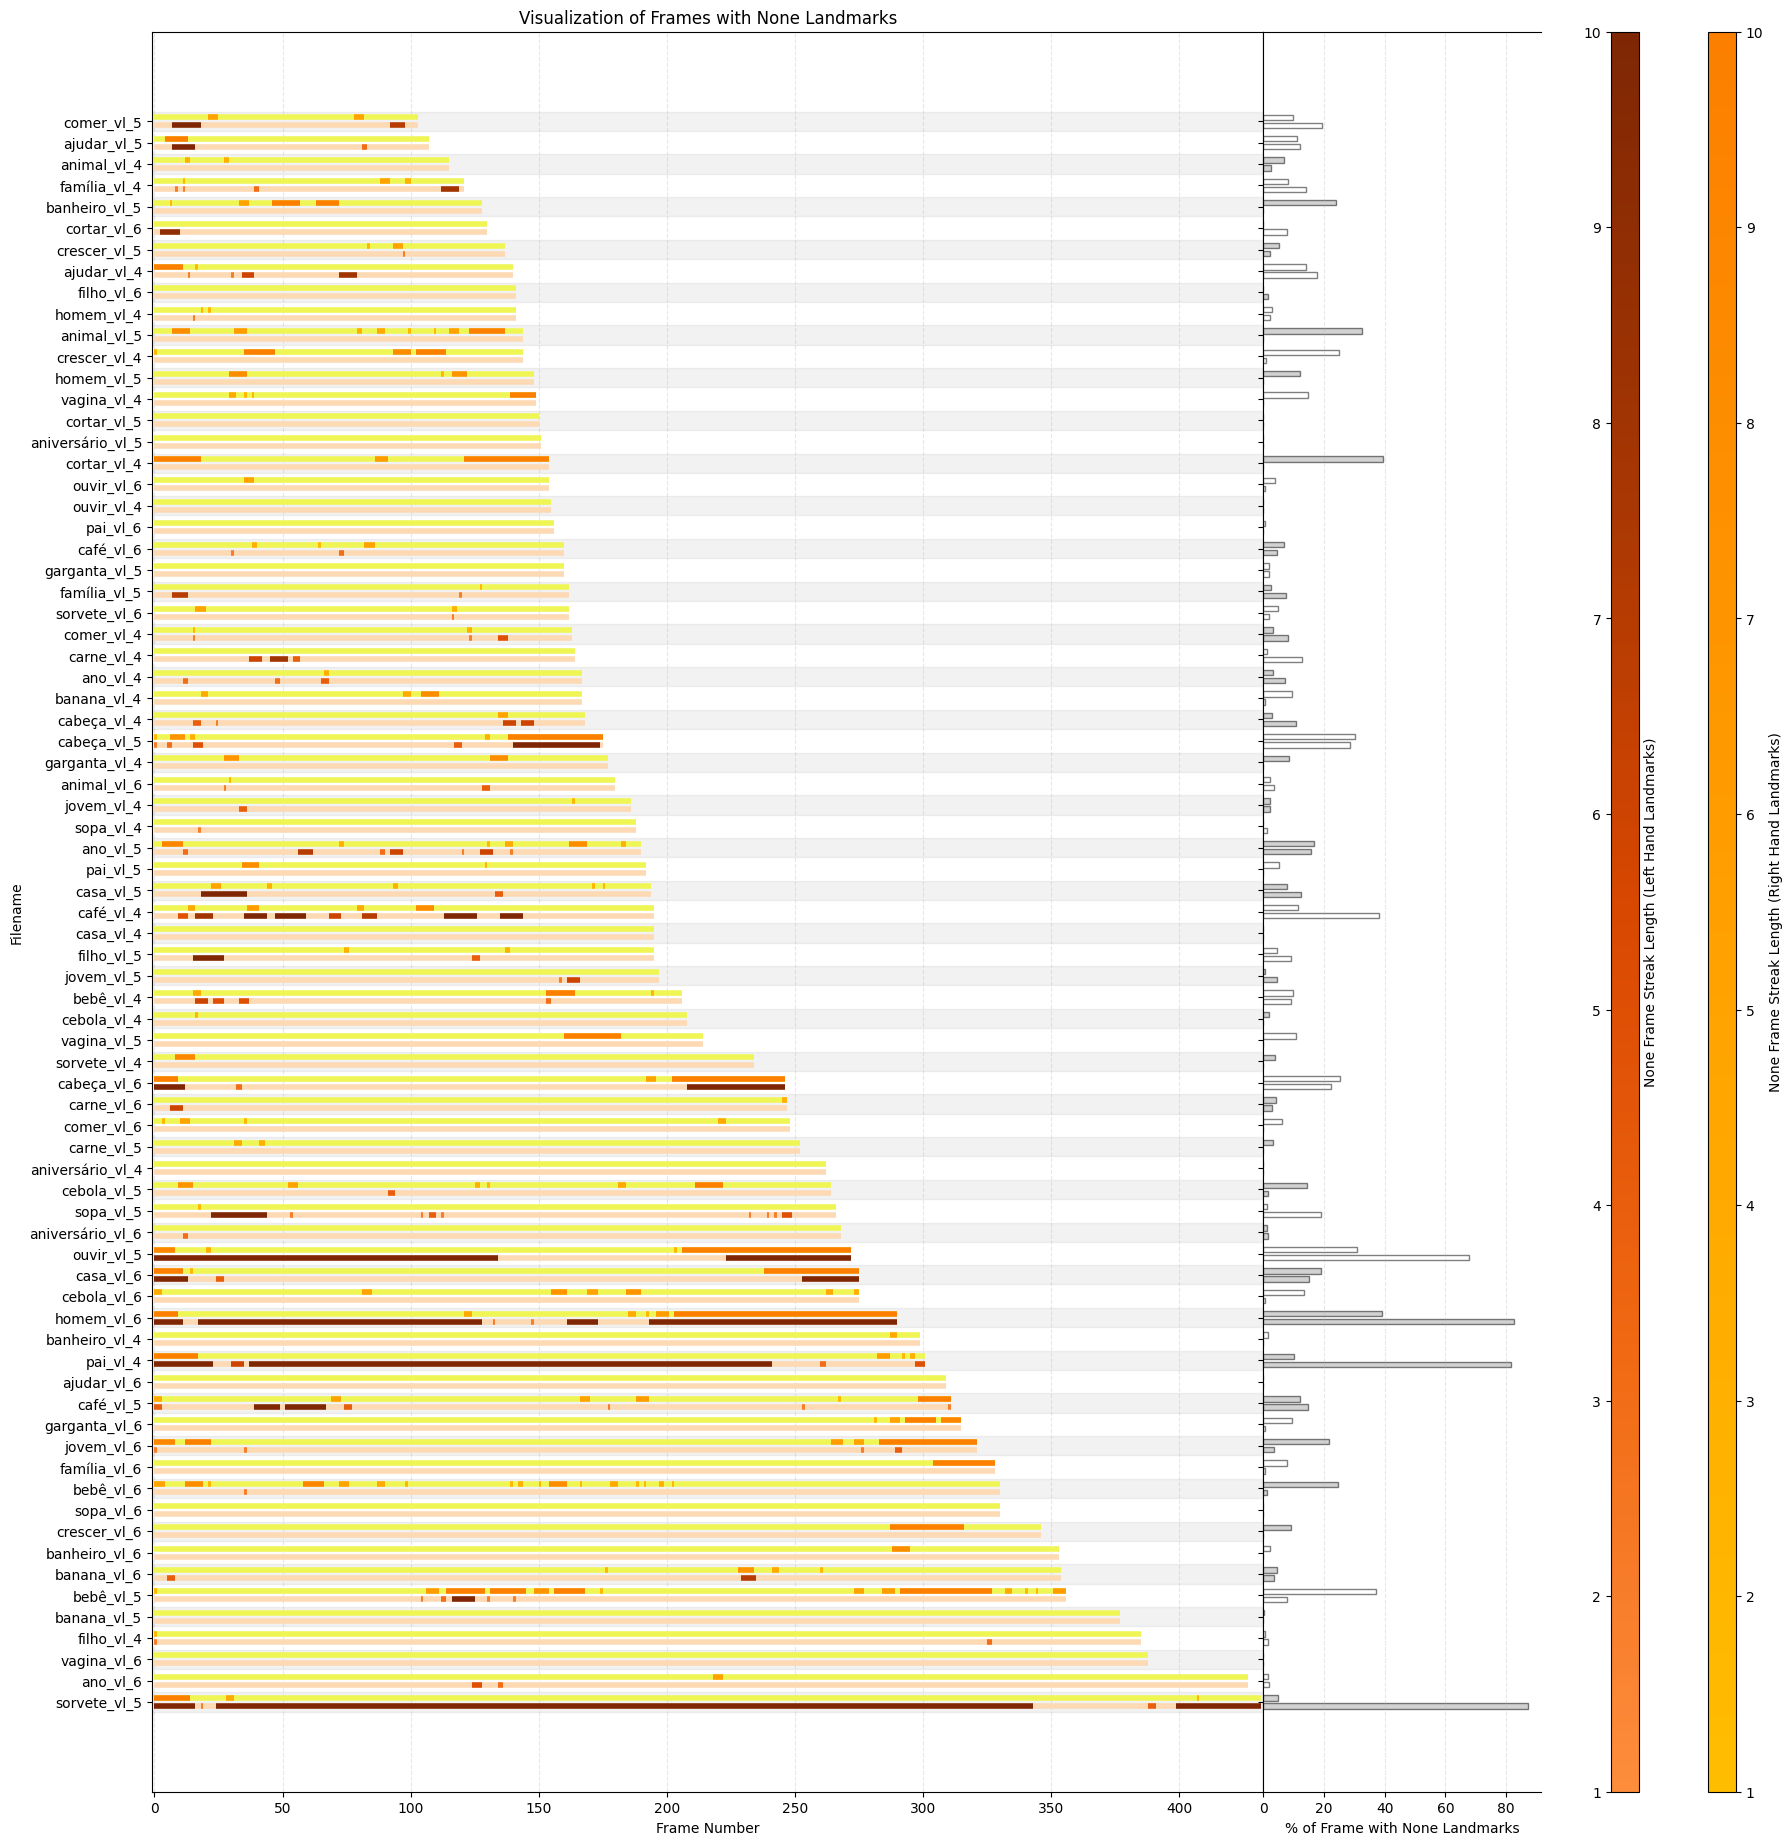

In [18]:
viz.series_none_frame_visualization(vl_plot_dict, figsize=(18, 22), line_width=4, left_cmap=plt.cm.Oranges, right_cmap=plt.cm.Wistia, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


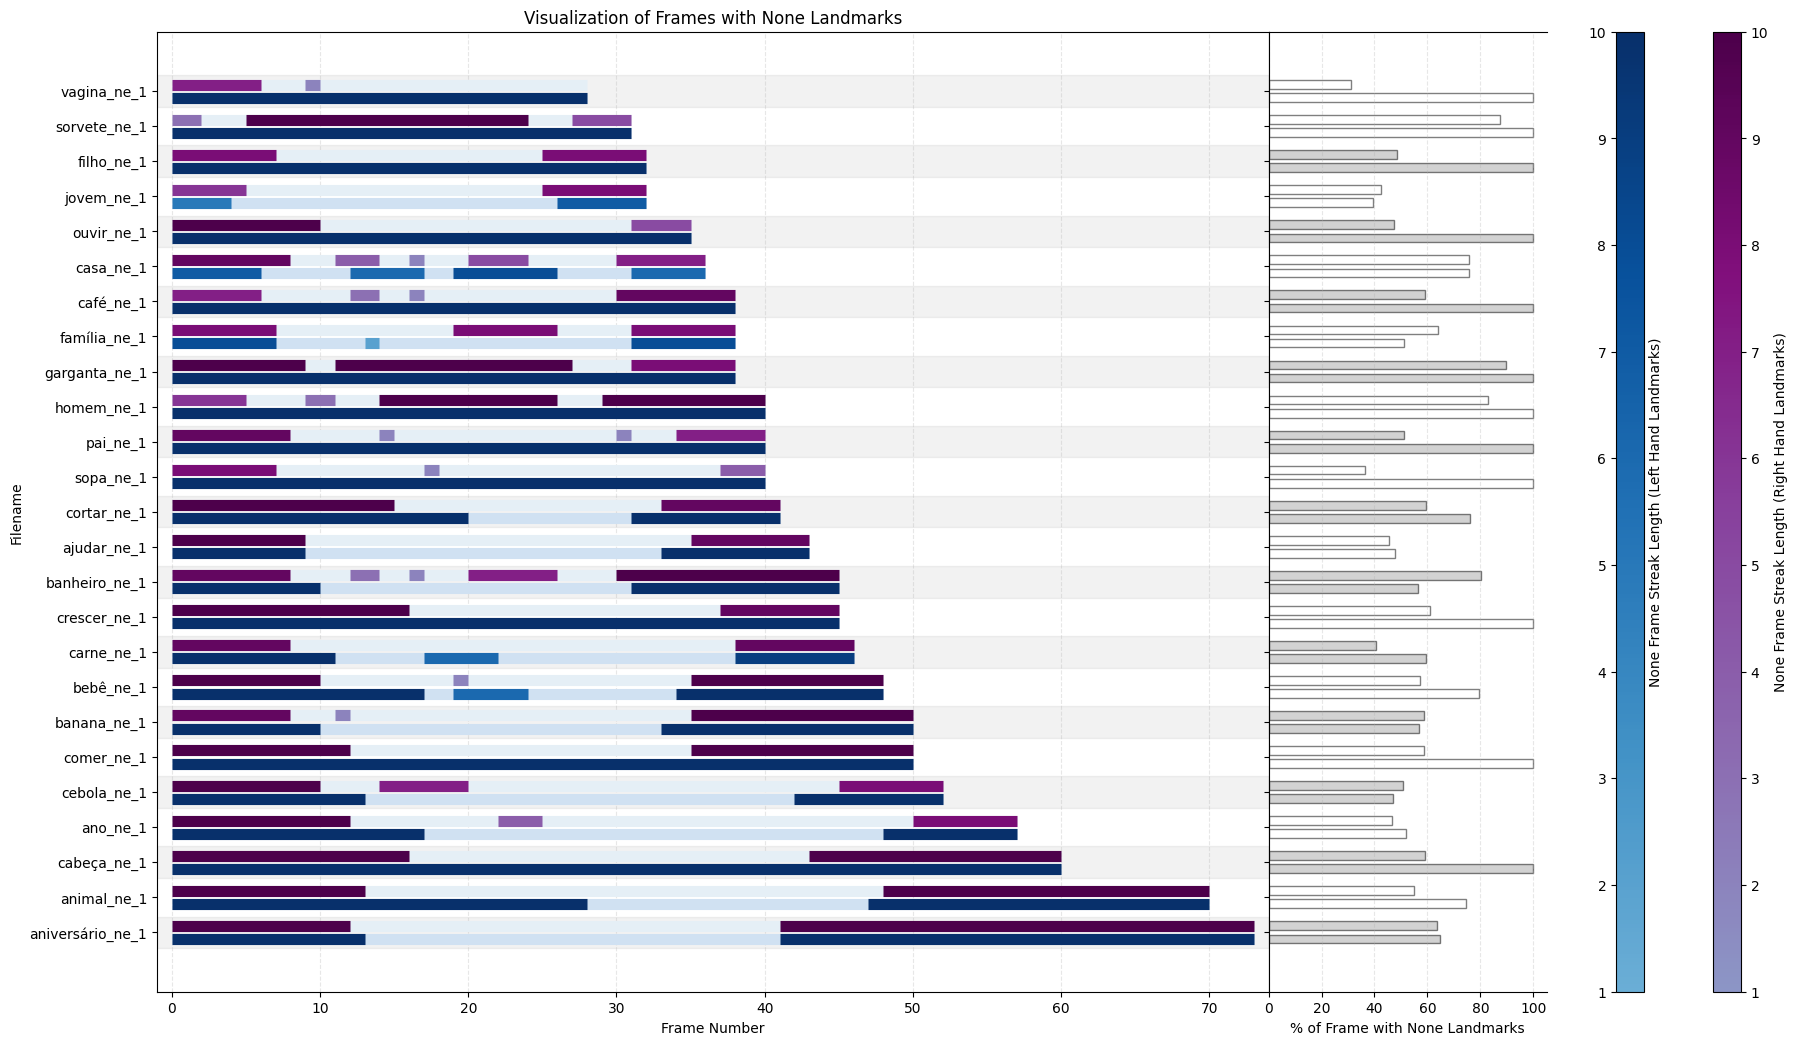

In [19]:
viz.series_none_frame_visualization(ne_plot_dict, right_cmap=plt.cm.BuPu, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


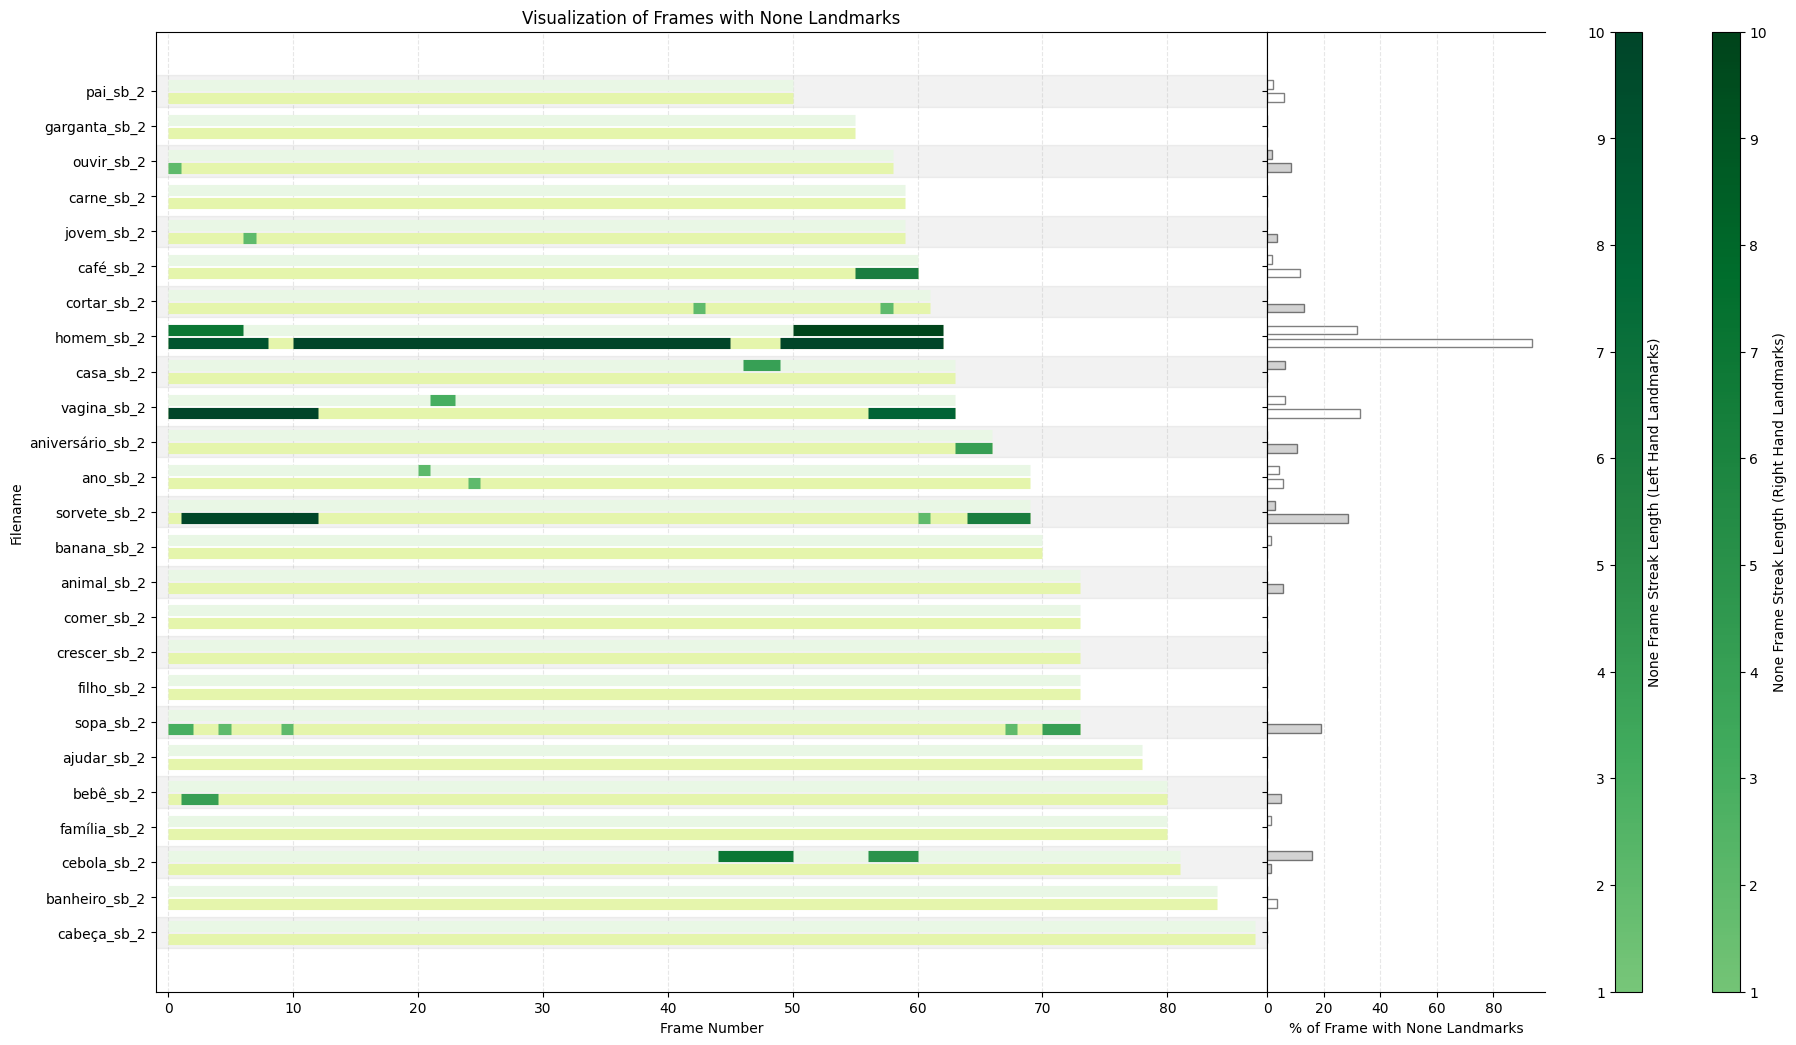

In [20]:
viz.series_none_frame_visualization(sb_plot_dict, left_cmap=plt.cm.YlGn, right_cmap=plt.cm.Greens, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


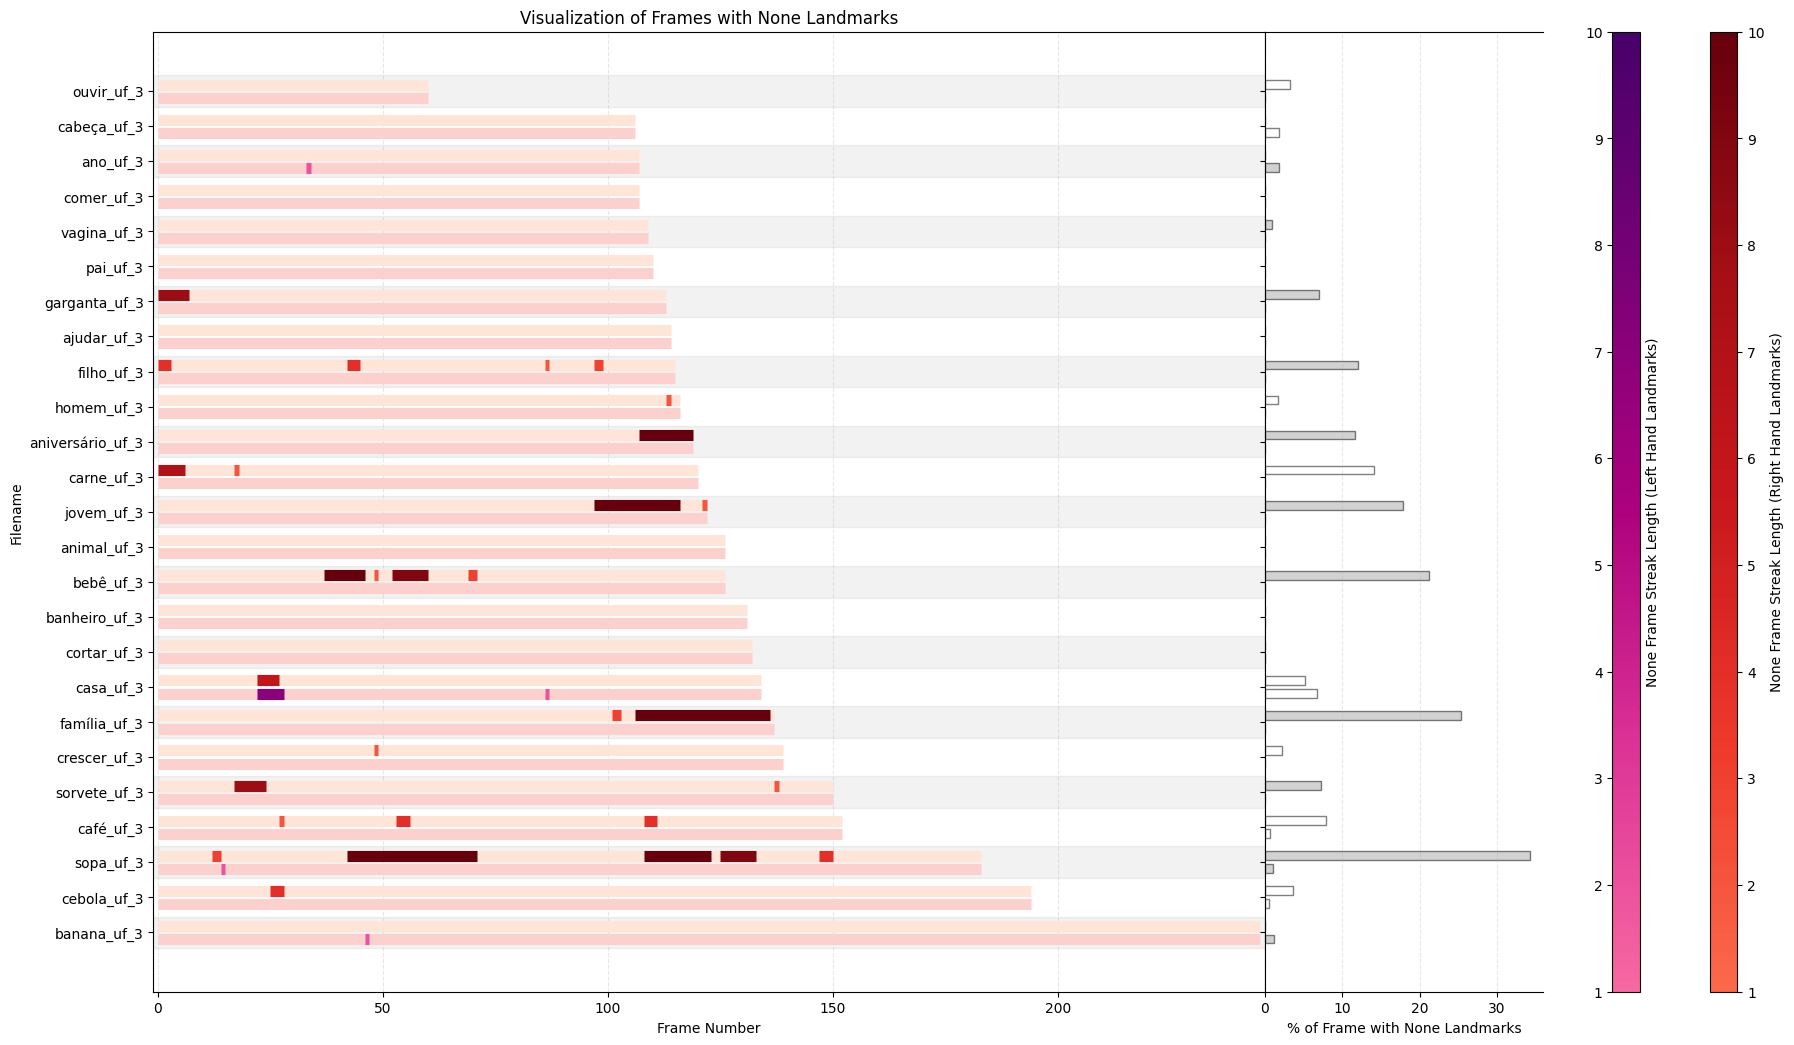

In [21]:
viz.series_none_frame_visualization(uf_plot_dict, left_cmap=plt.cm.RdPu, right_cmap=plt.cm.Reds, sort_length=True)

In [22]:
all_plot_dict = {}
vl_plot_dict = {}
vl_i = 0
ne_plot_dict = {}
ne_i = 0
sb_plot_dict = {}
sb_i = 0
uf_plot_dict = {}
uf_i = 0

stage = 'trimmed'
for i, row in analysis_info[::-1].iterrows():
    fn = row['metadata_filename'].split('.')[0]
    # left
    total_frames_l = row[f'{stage}_none_analysis_left_hand_landmarks_total_frames']
    none_details_l = row[f'{stage}_none_analysis_left_hand_landmarks_none_details']
    binary_none_array_l = make_binary_none_array(total_frames_l, none_details_l)
    # right
    total_frames_r = row[f'{stage}_none_analysis_right_hand_landmarks_total_frames']
    none_details_r = row[f'{stage}_none_analysis_right_hand_landmarks_none_details']
    binary_none_array_r = make_binary_none_array(total_frames_r, none_details_r)

    all_plot_dict[f'{fn}_{i}_Left'] = binary_none_array_l
    all_plot_dict[f'{fn}_{i}_Right'] = binary_none_array_r

    if row.metadata_data_source == 'vl':
        vl_plot_dict[f'{fn}_Left'] = binary_none_array_l
        vl_plot_dict[f'{fn}_Right'] = binary_none_array_r
        vl_i += 1
    if row.metadata_data_source == 'ne':
        ne_plot_dict[f'{fn}_Left'] = binary_none_array_l
        ne_plot_dict[f'{fn}_Right'] = binary_none_array_r
        ne_i += 1
    if row.metadata_data_source == 'sb':
        sb_plot_dict[f'{fn}_Left'] = binary_none_array_l
        sb_plot_dict[f'{fn}_Right'] = binary_none_array_r
        sb_i += 1
    if row.metadata_data_source == 'uf':
        uf_plot_dict[f'{fn}_Left'] = binary_none_array_l
        uf_plot_dict[f'{fn}_Right'] = binary_none_array_r
        uf_i += 1
    if total_frames_l != total_frames_r:
        print(f'difference in total frames for {row.metadata_filename}')
        break

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


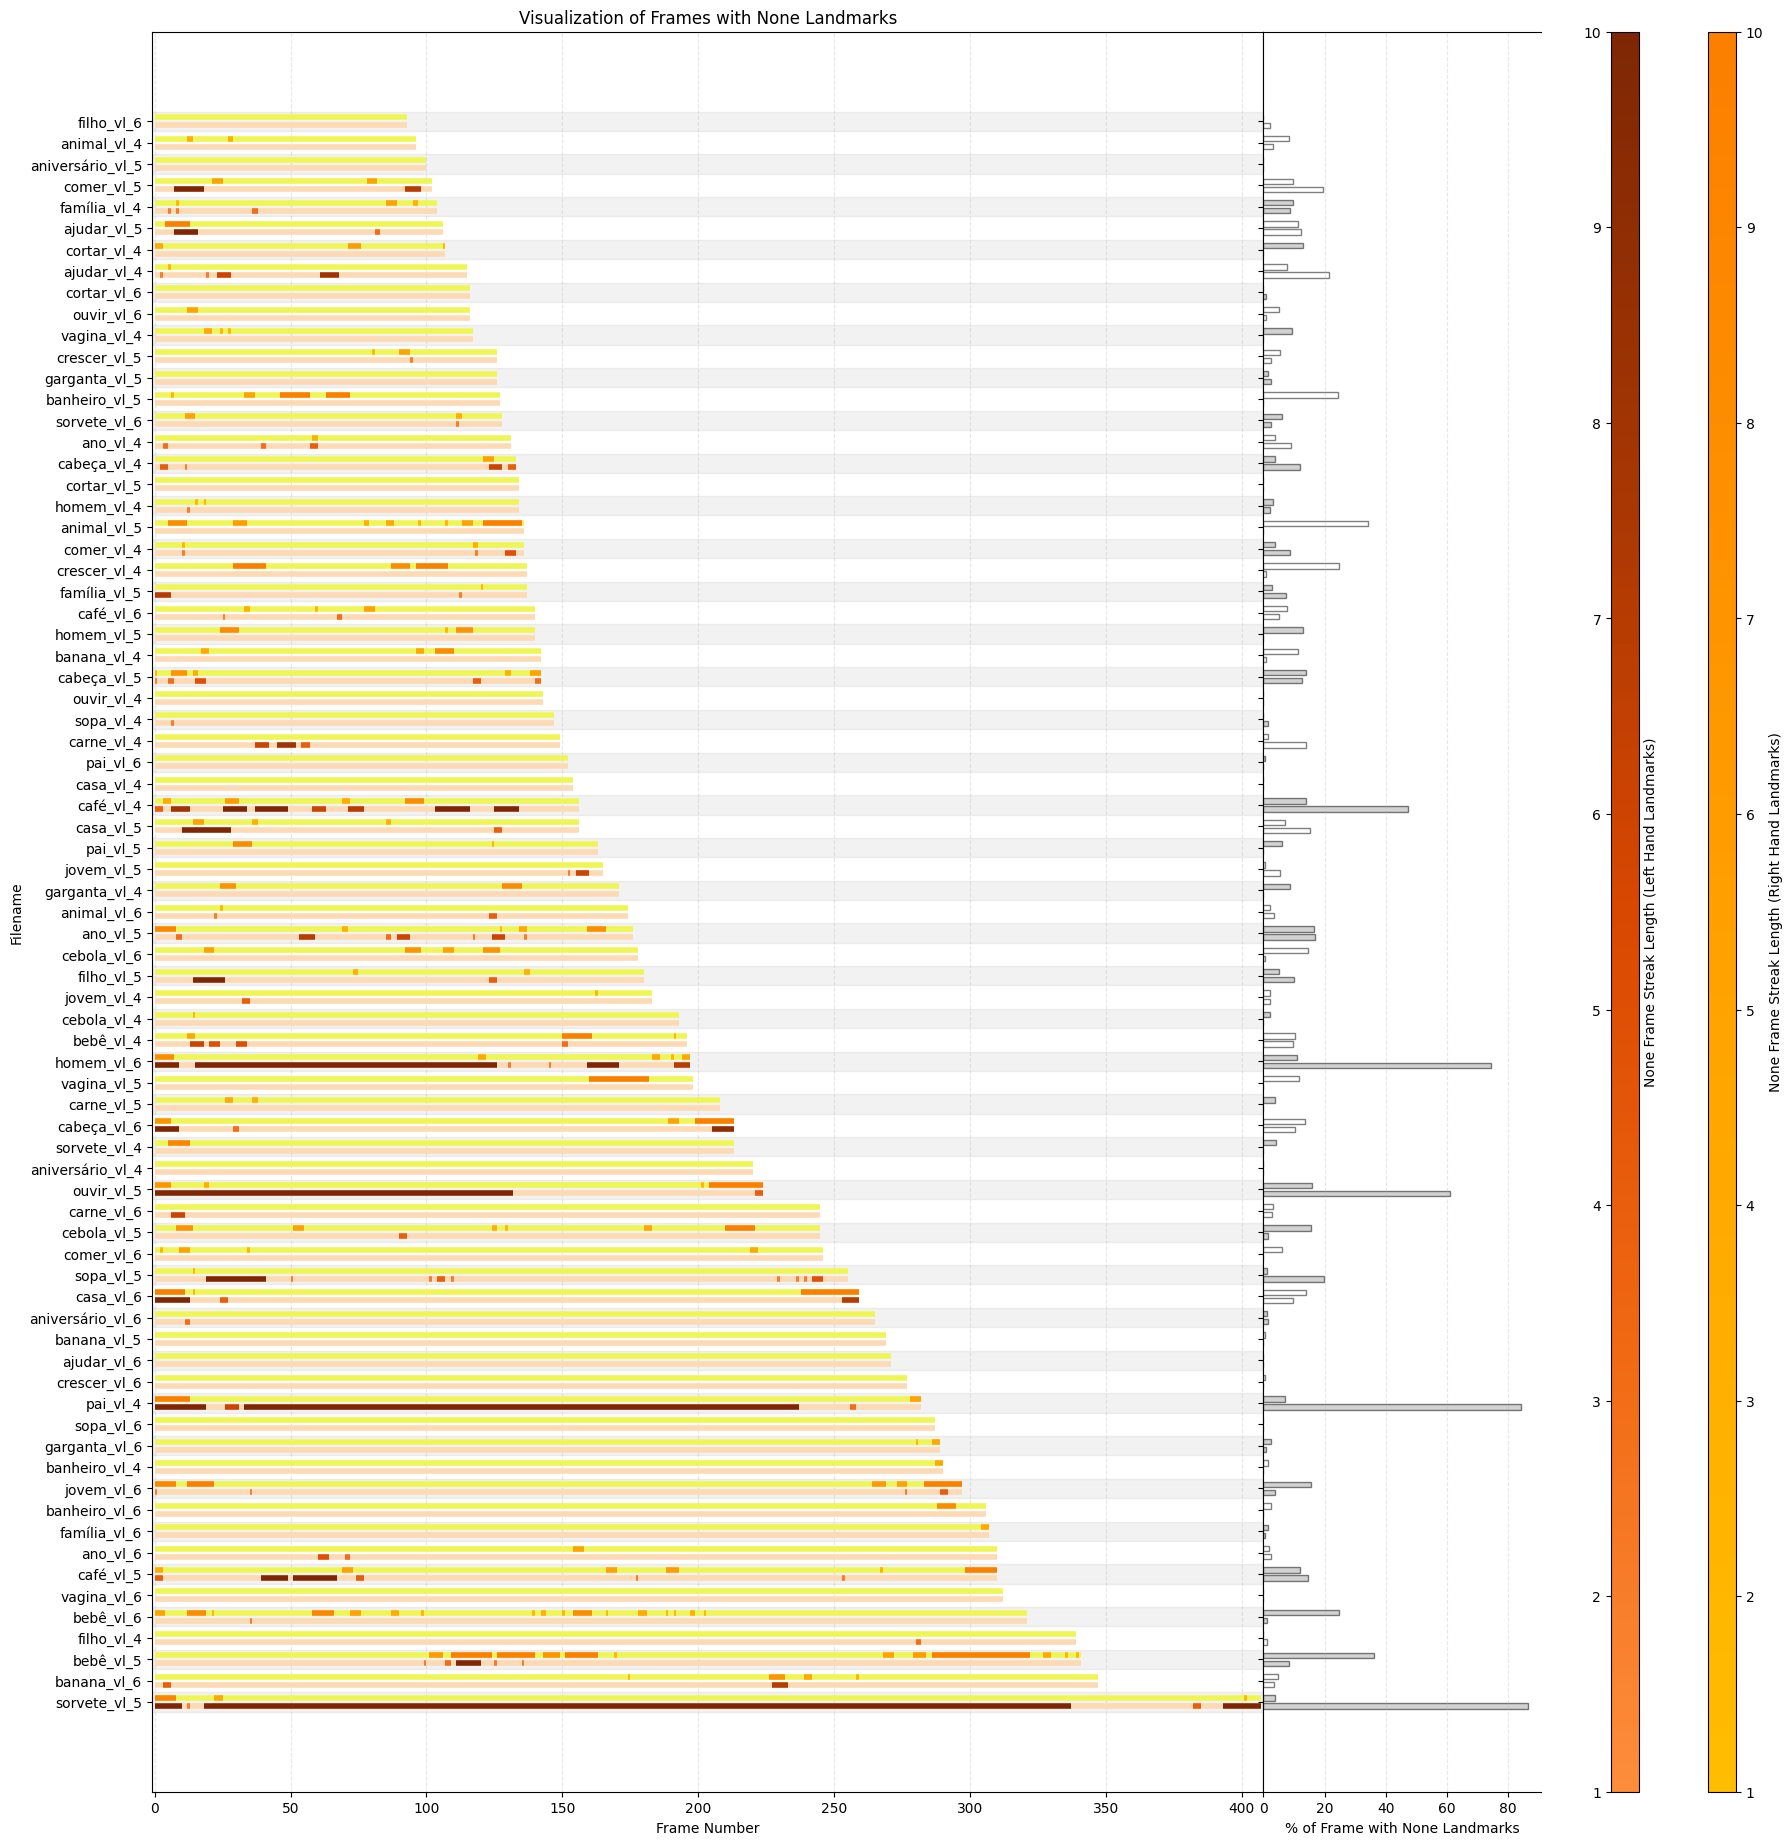

In [23]:
viz.series_none_frame_visualization(vl_plot_dict, figsize=(18, 22), line_width=4, left_cmap=plt.cm.Oranges, right_cmap=plt.cm.Wistia, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


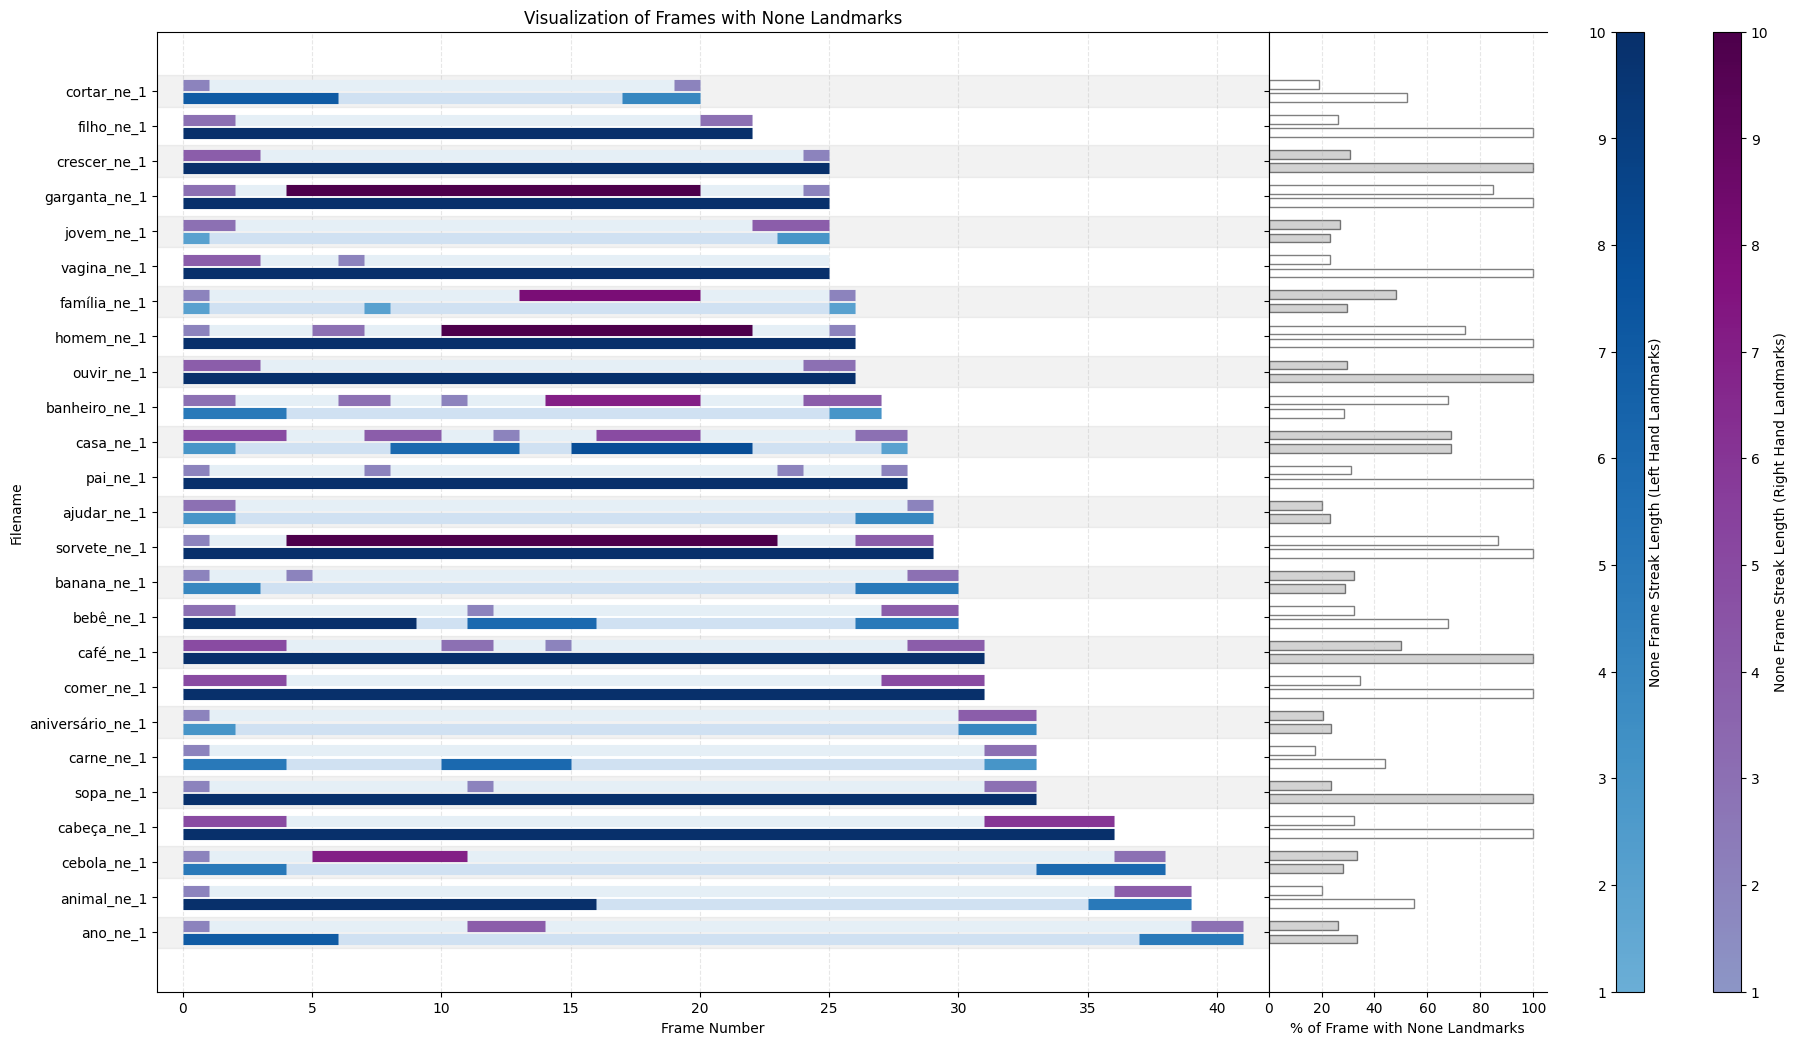

In [24]:
viz.series_none_frame_visualization(ne_plot_dict, right_cmap=plt.cm.BuPu, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


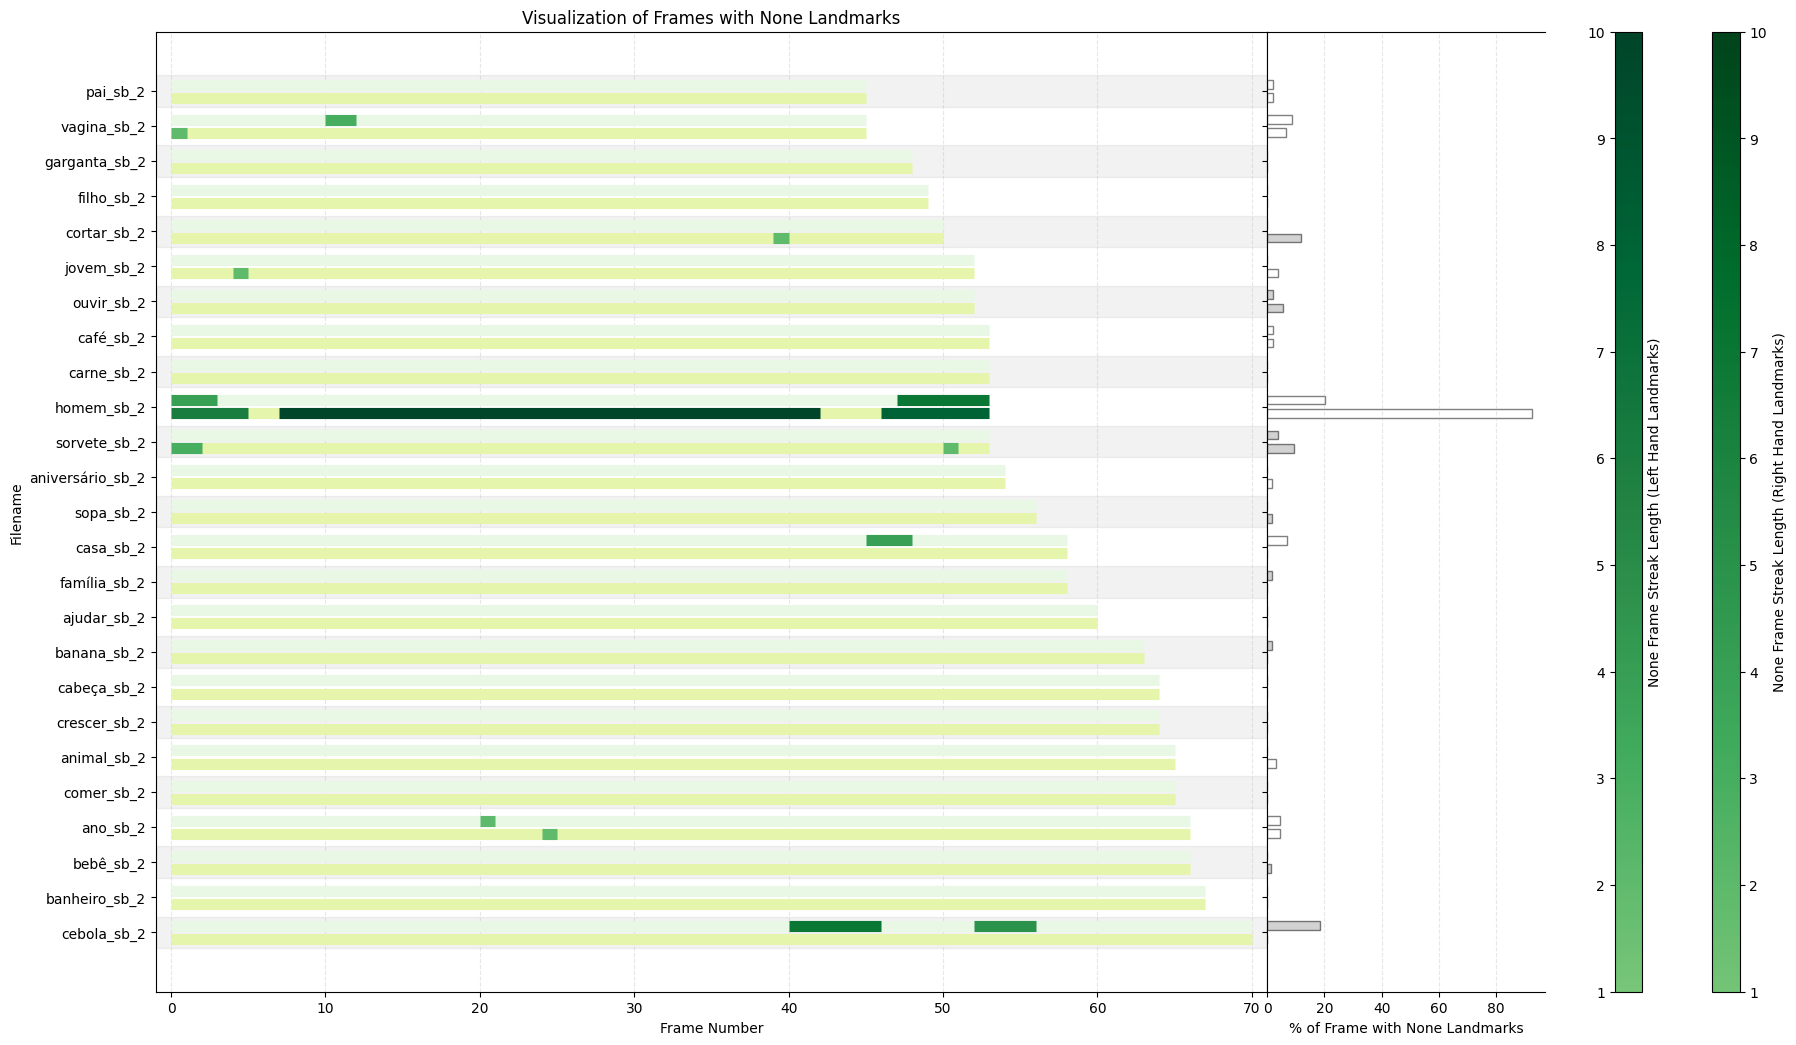

In [49]:
viz.series_none_frame_visualization(sb_plot_dict, left_cmap=plt.cm.YlGn, right_cmap=plt.cm.Greens, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


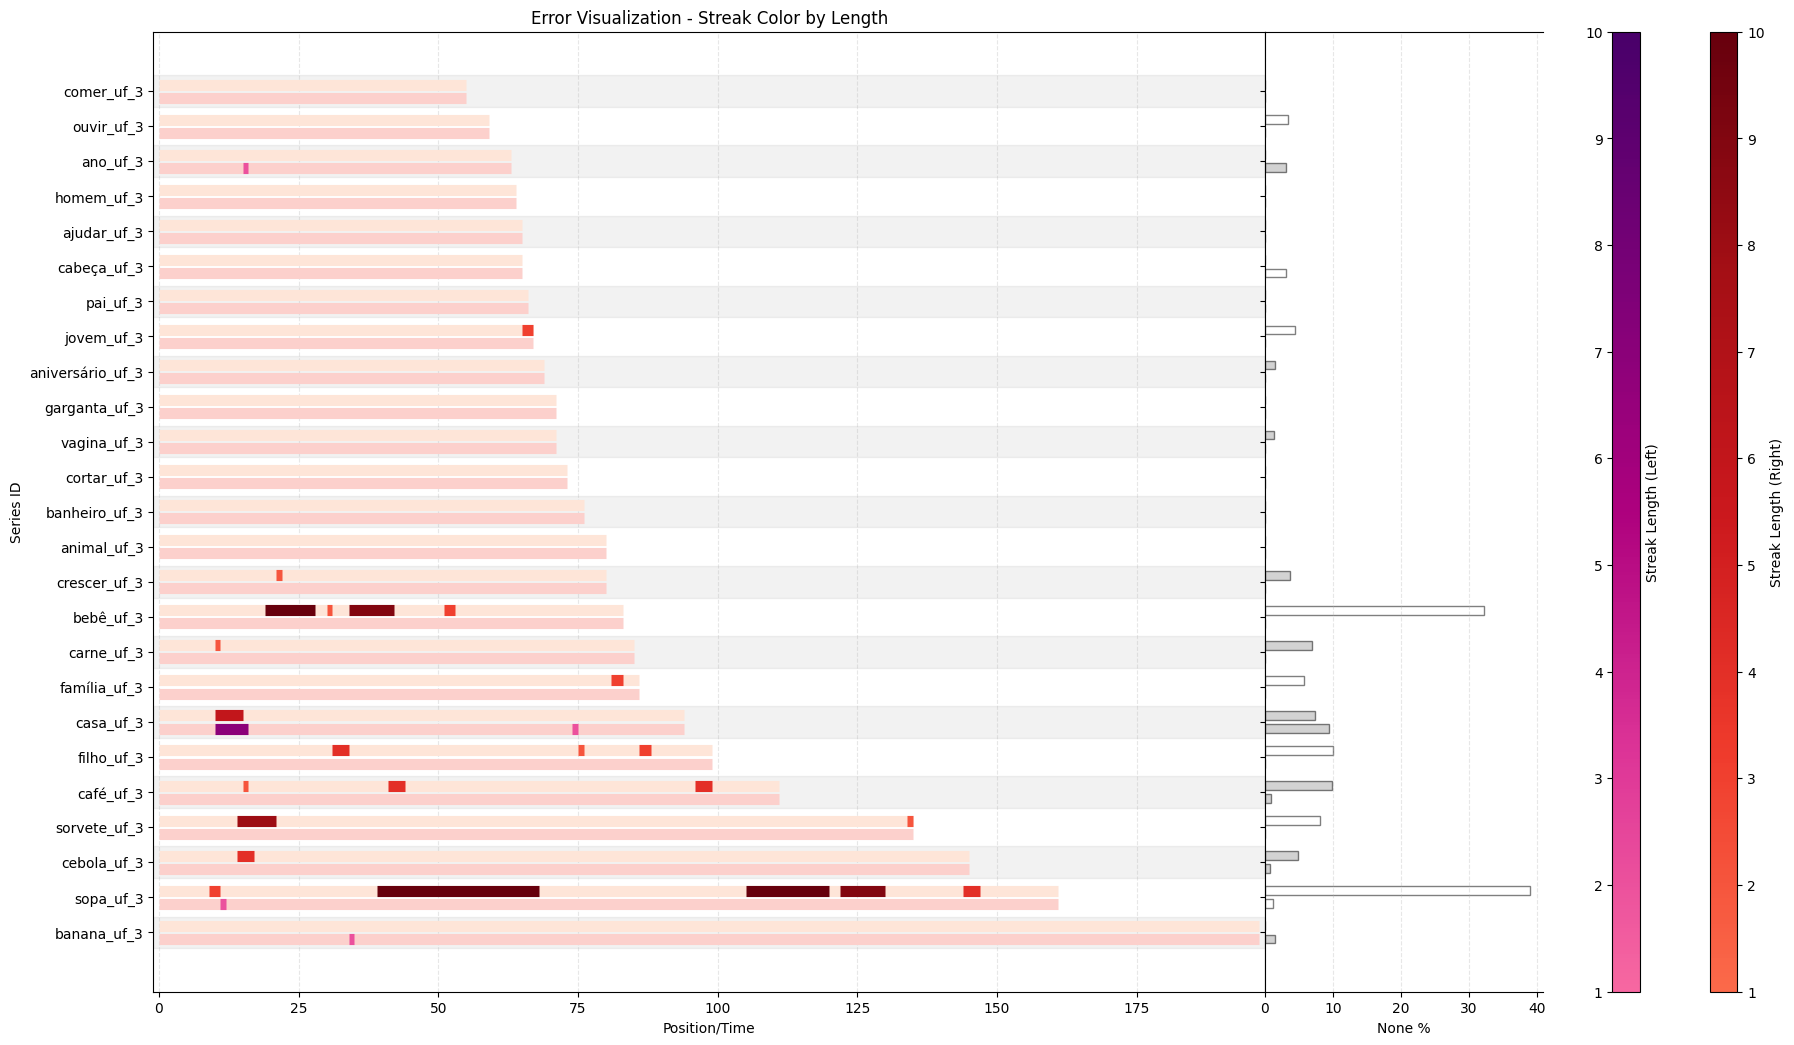

In [48]:
viz.series_none_frame_visualization(uf_plot_dict, left_cmap=plt.cm.RdPu, right_cmap=plt.cm.Reds, sort_length=True)

In [25]:
all_plot_dict = {}
vl_plot_dict = {}
vl_i = 0
ne_plot_dict = {}
ne_i = 0
sb_plot_dict = {}
sb_i = 0
uf_plot_dict = {}
uf_i = 0

stage = 'interpolated'
for i, row in analysis_info[::-1].iterrows():
    fn = row['metadata_filename'].split('.')[0]
    # left
    total_frames_l = row[f'{stage}_none_analysis_left_hand_landmarks_total_frames']
    none_details_l = row[f'{stage}_none_analysis_left_hand_landmarks_none_details']
    binary_none_array_l = make_binary_none_array(total_frames_l, none_details_l)
    # right
    total_frames_r = row[f'{stage}_none_analysis_right_hand_landmarks_total_frames']
    none_details_r = row[f'{stage}_none_analysis_right_hand_landmarks_none_details']
    binary_none_array_r = make_binary_none_array(total_frames_r, none_details_r)

    all_plot_dict[f'{fn}_{i}_Left'] = binary_none_array_l
    all_plot_dict[f'{fn}_{i}_Right'] = binary_none_array_r

    if row.metadata_data_source == 'vl':
        vl_plot_dict[f'{fn}_Left'] = binary_none_array_l
        vl_plot_dict[f'{fn}_Right'] = binary_none_array_r
        vl_i += 1
    if row.metadata_data_source == 'ne':
        ne_plot_dict[f'{fn}_Left'] = binary_none_array_l
        ne_plot_dict[f'{fn}_Right'] = binary_none_array_r
        ne_i += 1
    if row.metadata_data_source == 'sb':
        sb_plot_dict[f'{fn}_Left'] = binary_none_array_l
        sb_plot_dict[f'{fn}_Right'] = binary_none_array_r
        sb_i += 1
    if row.metadata_data_source == 'uf':
        uf_plot_dict[f'{fn}_Left'] = binary_none_array_l
        uf_plot_dict[f'{fn}_Right'] = binary_none_array_r
        uf_i += 1
    if total_frames_l != total_frames_r:
        print(f'difference in total frames for {row.metadata_filename}')
        break

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


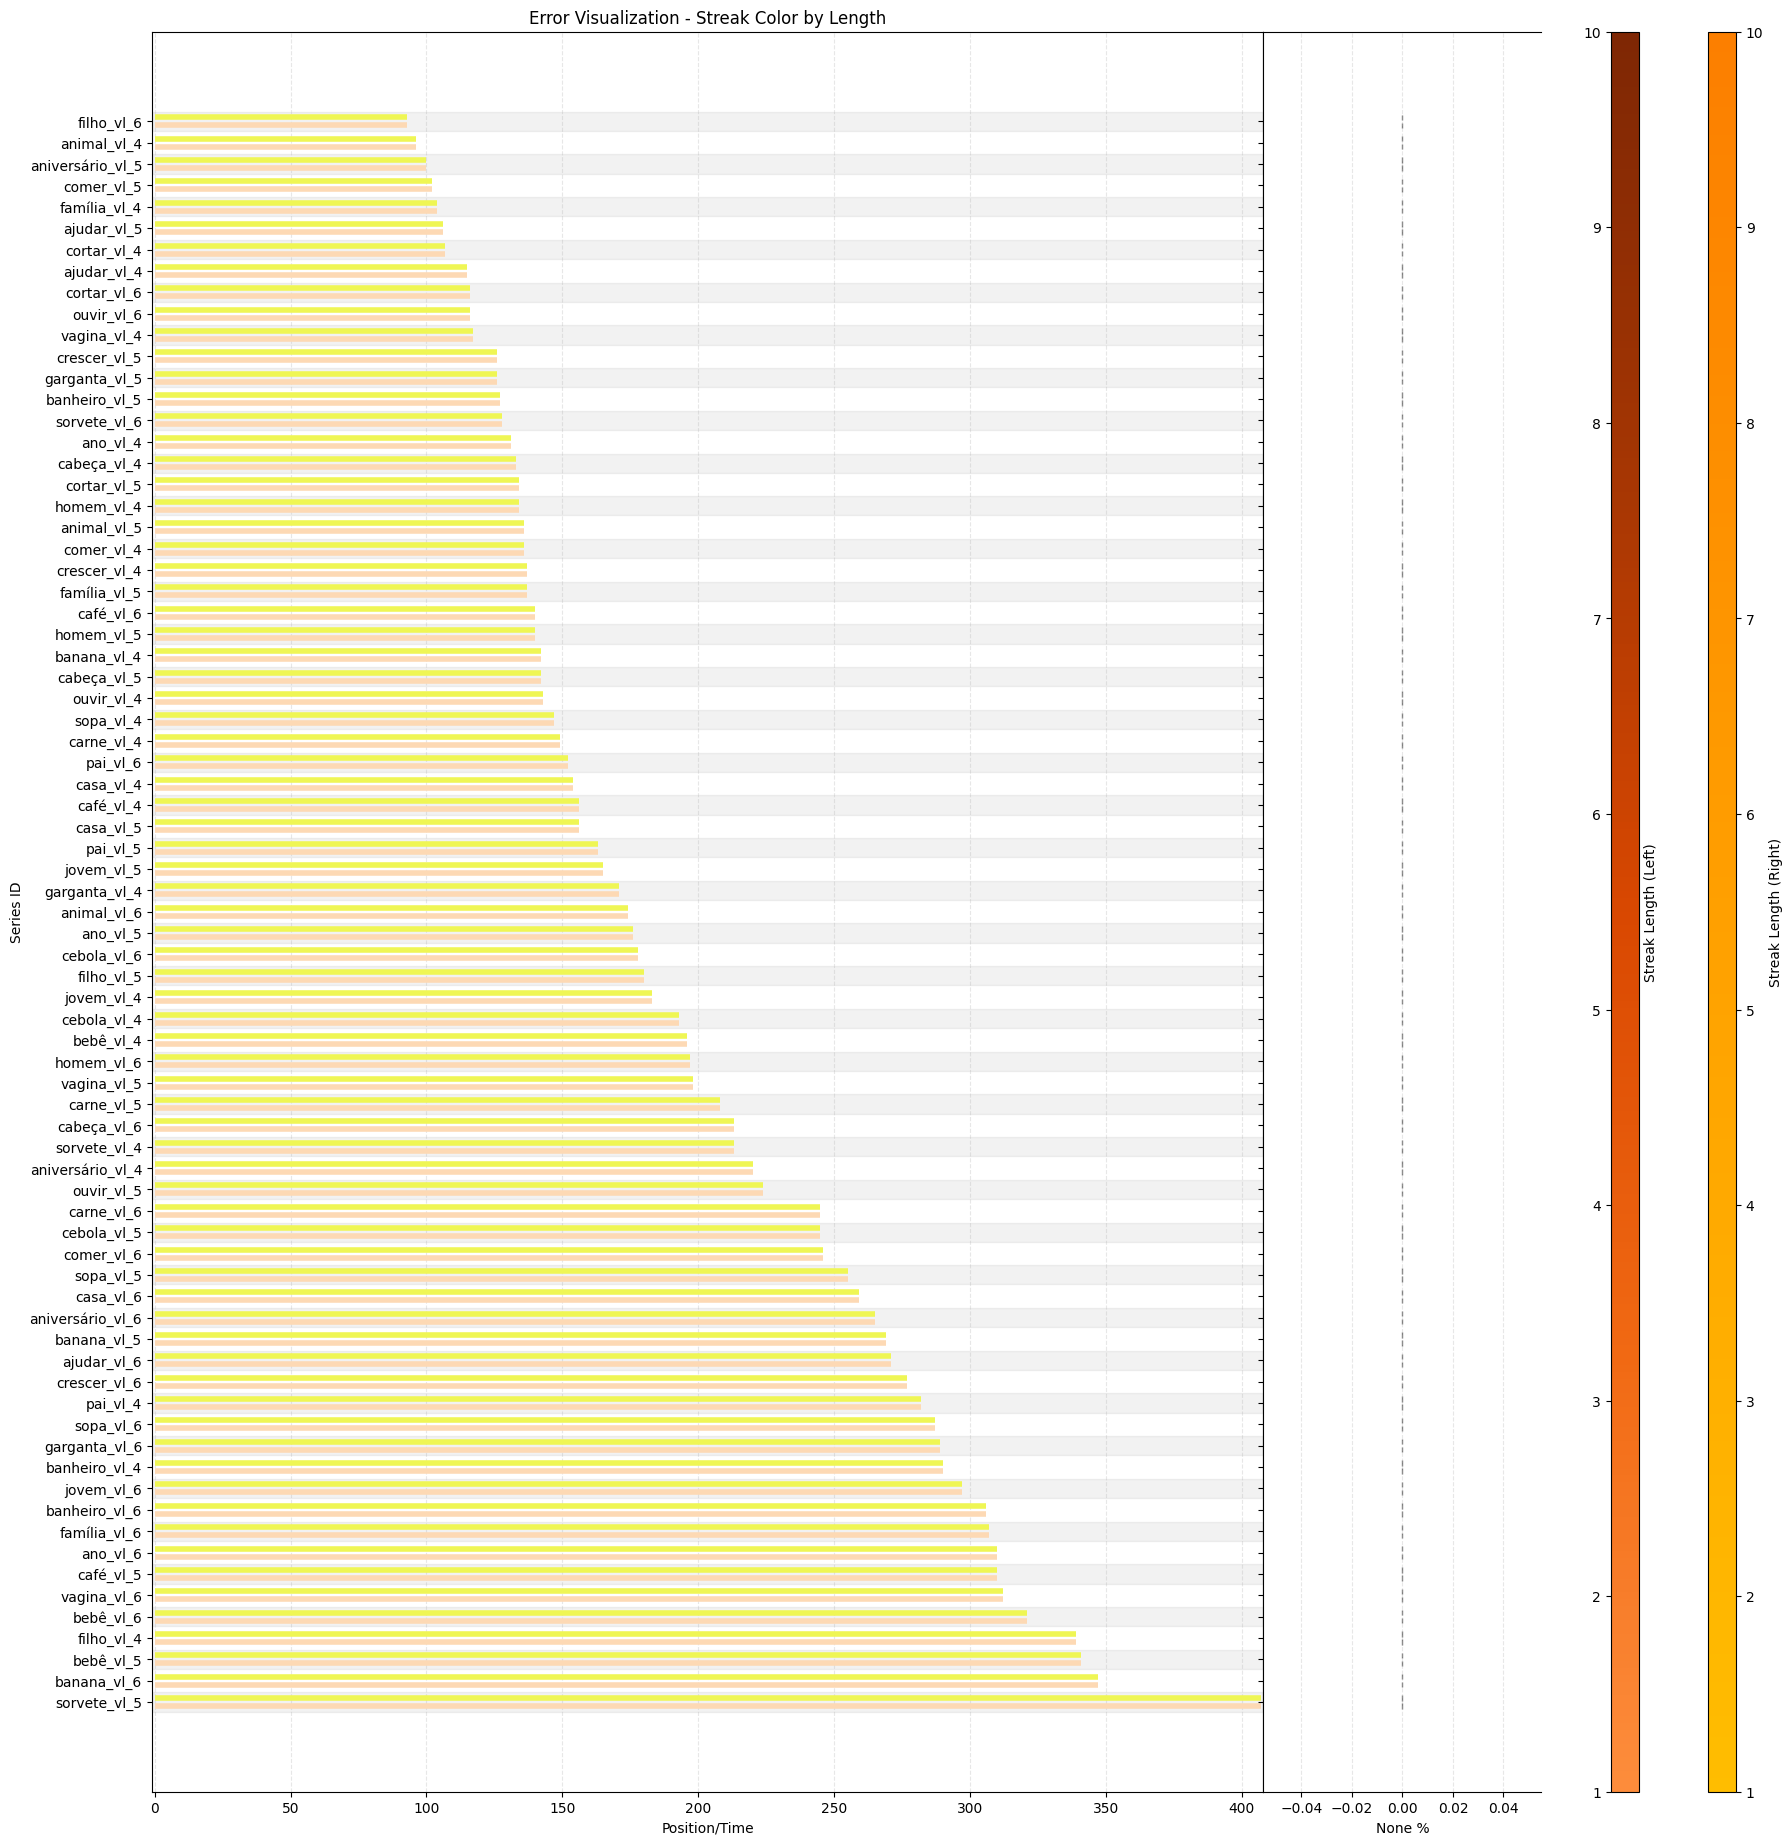

In [41]:
viz.series_none_frame_visualization(vl_plot_dict, 
                                    figsize=(18, 22), 
                                    line_width=4, 
                                    left_cmap=plt.cm.Oranges, 
                                    right_cmap=plt.cm.Wistia,
                                    sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


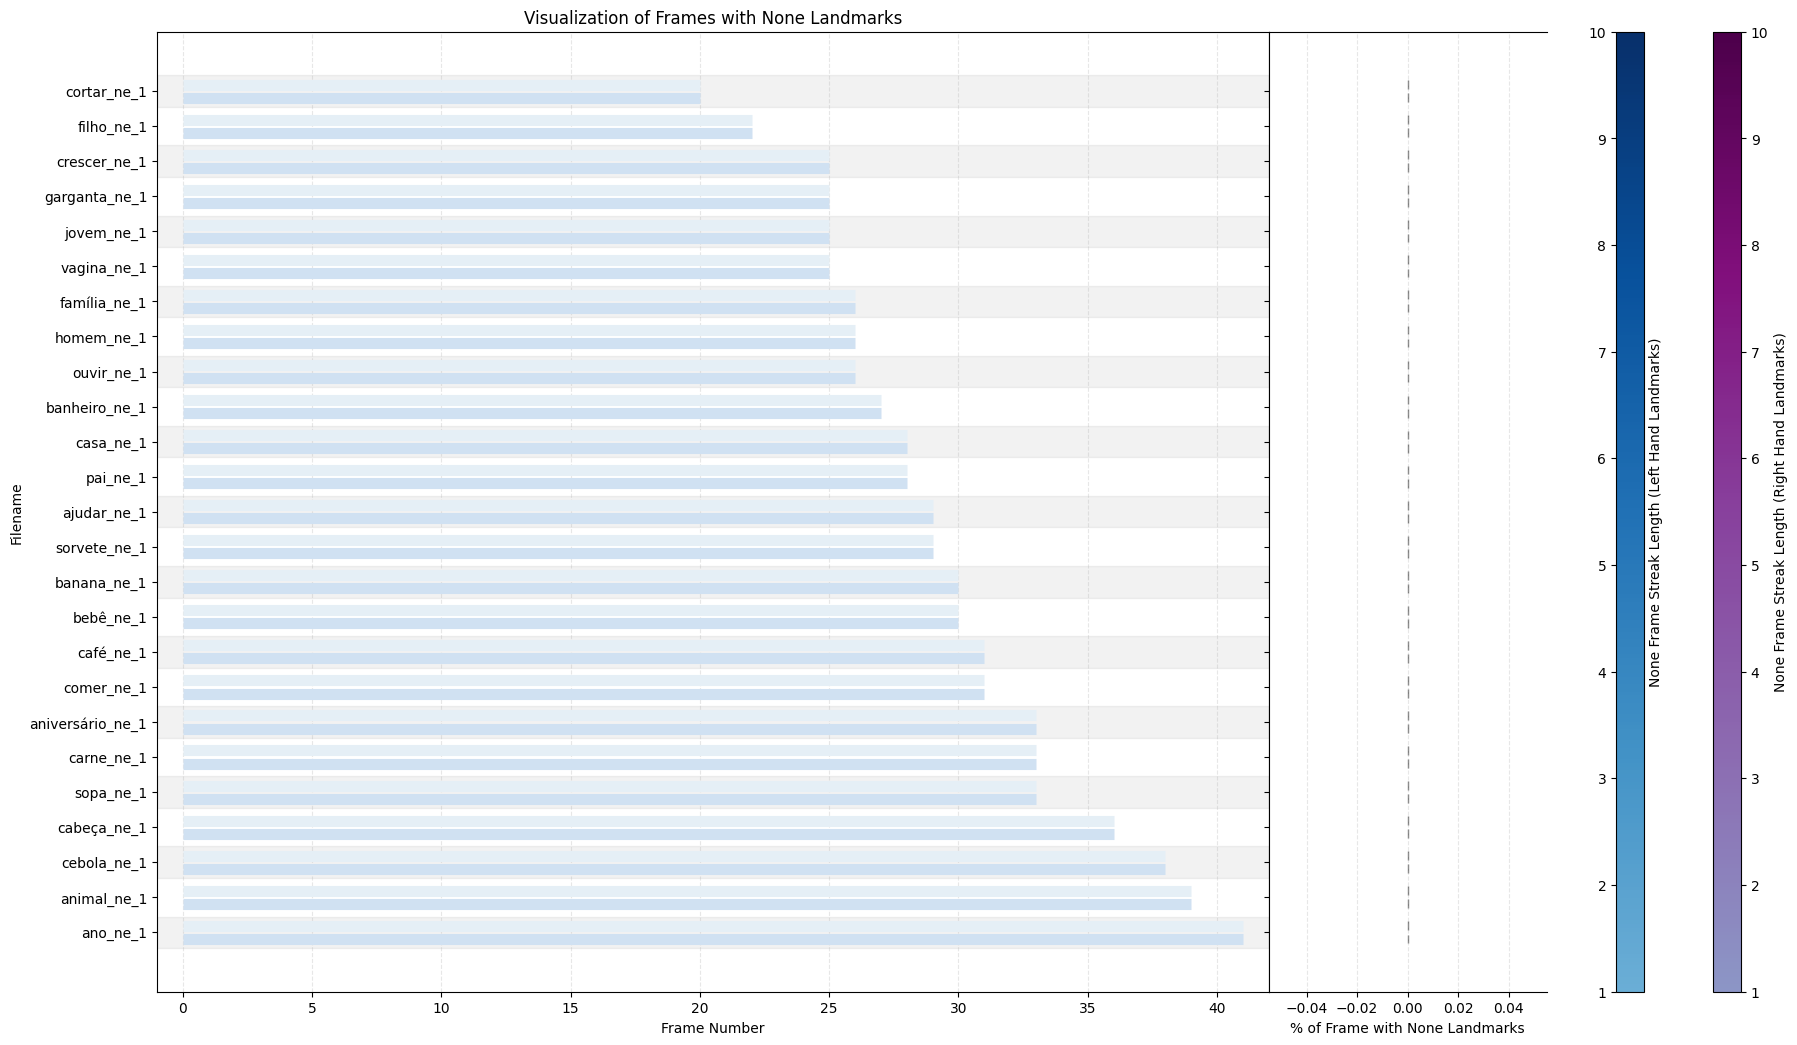

In [26]:
viz.series_none_frame_visualization(ne_plot_dict, right_cmap=plt.cm.BuPu, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


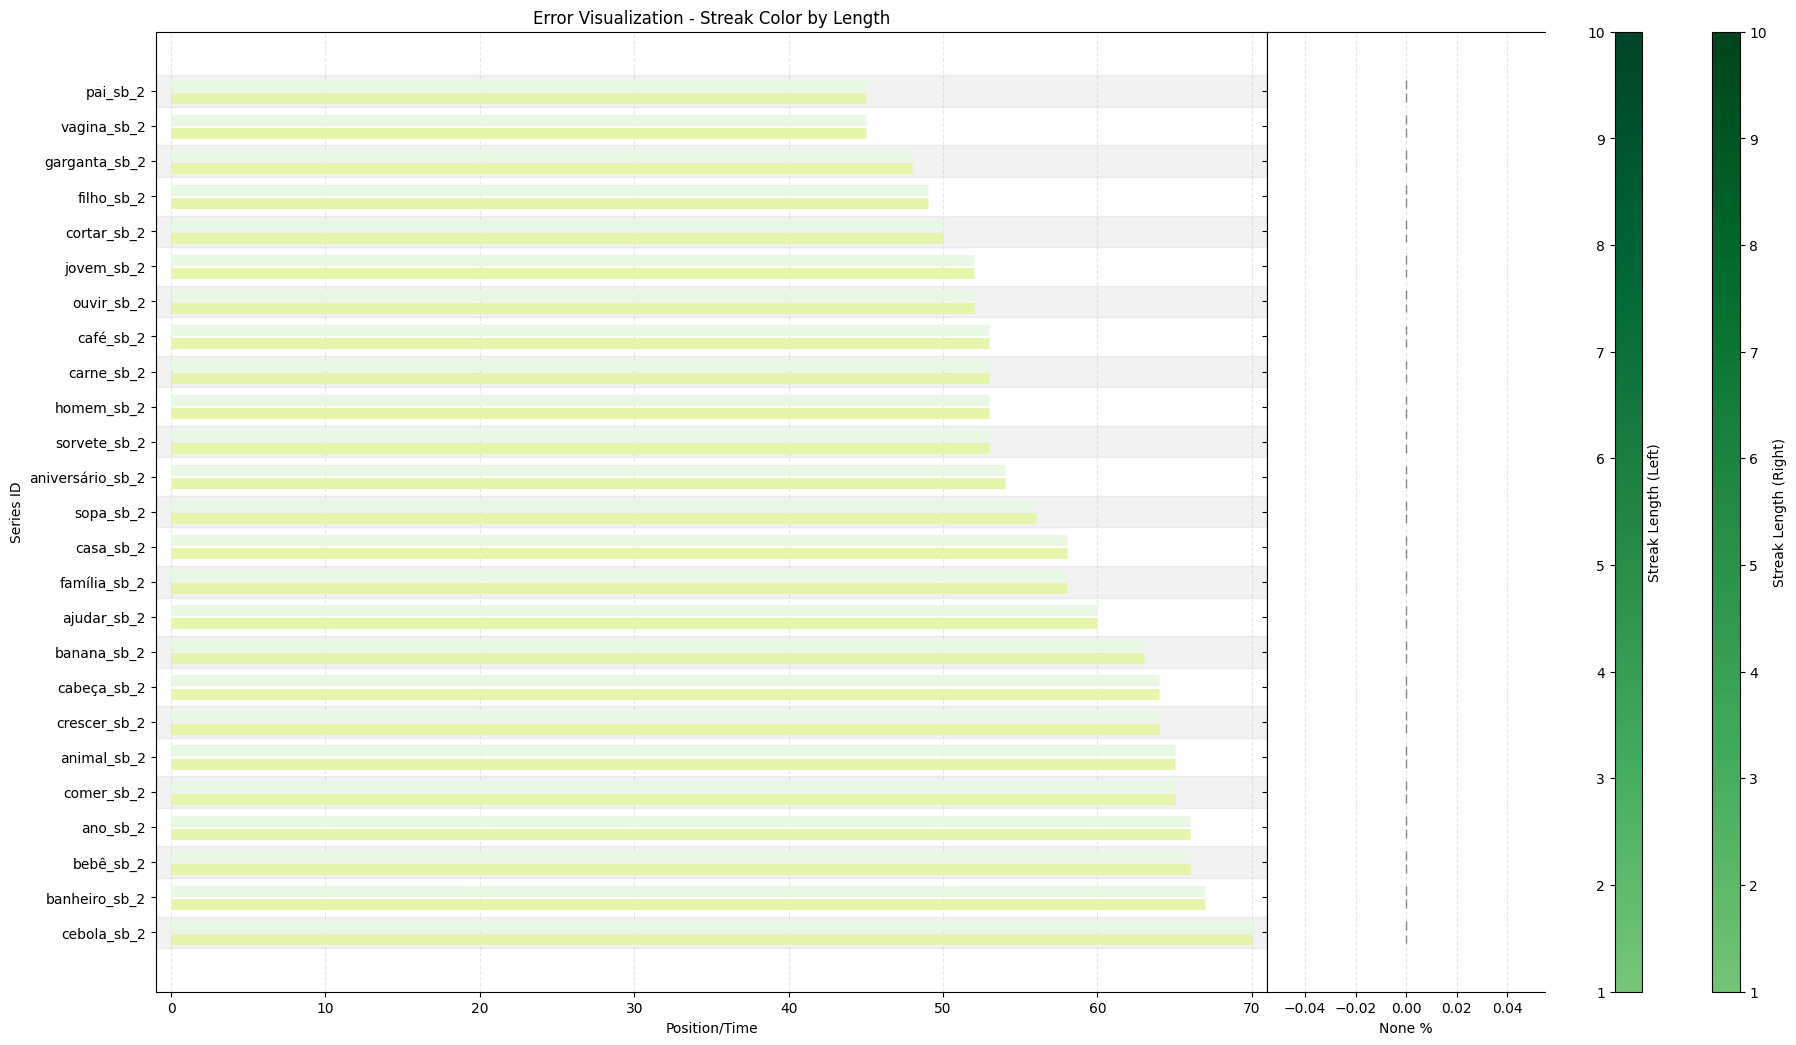

In [42]:
viz.series_none_frame_visualization(sb_plot_dict, left_cmap=plt.cm.YlGn, right_cmap=plt.cm.Greens, sort_length=True)

/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code/preprocess/vizualisation.py:939: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


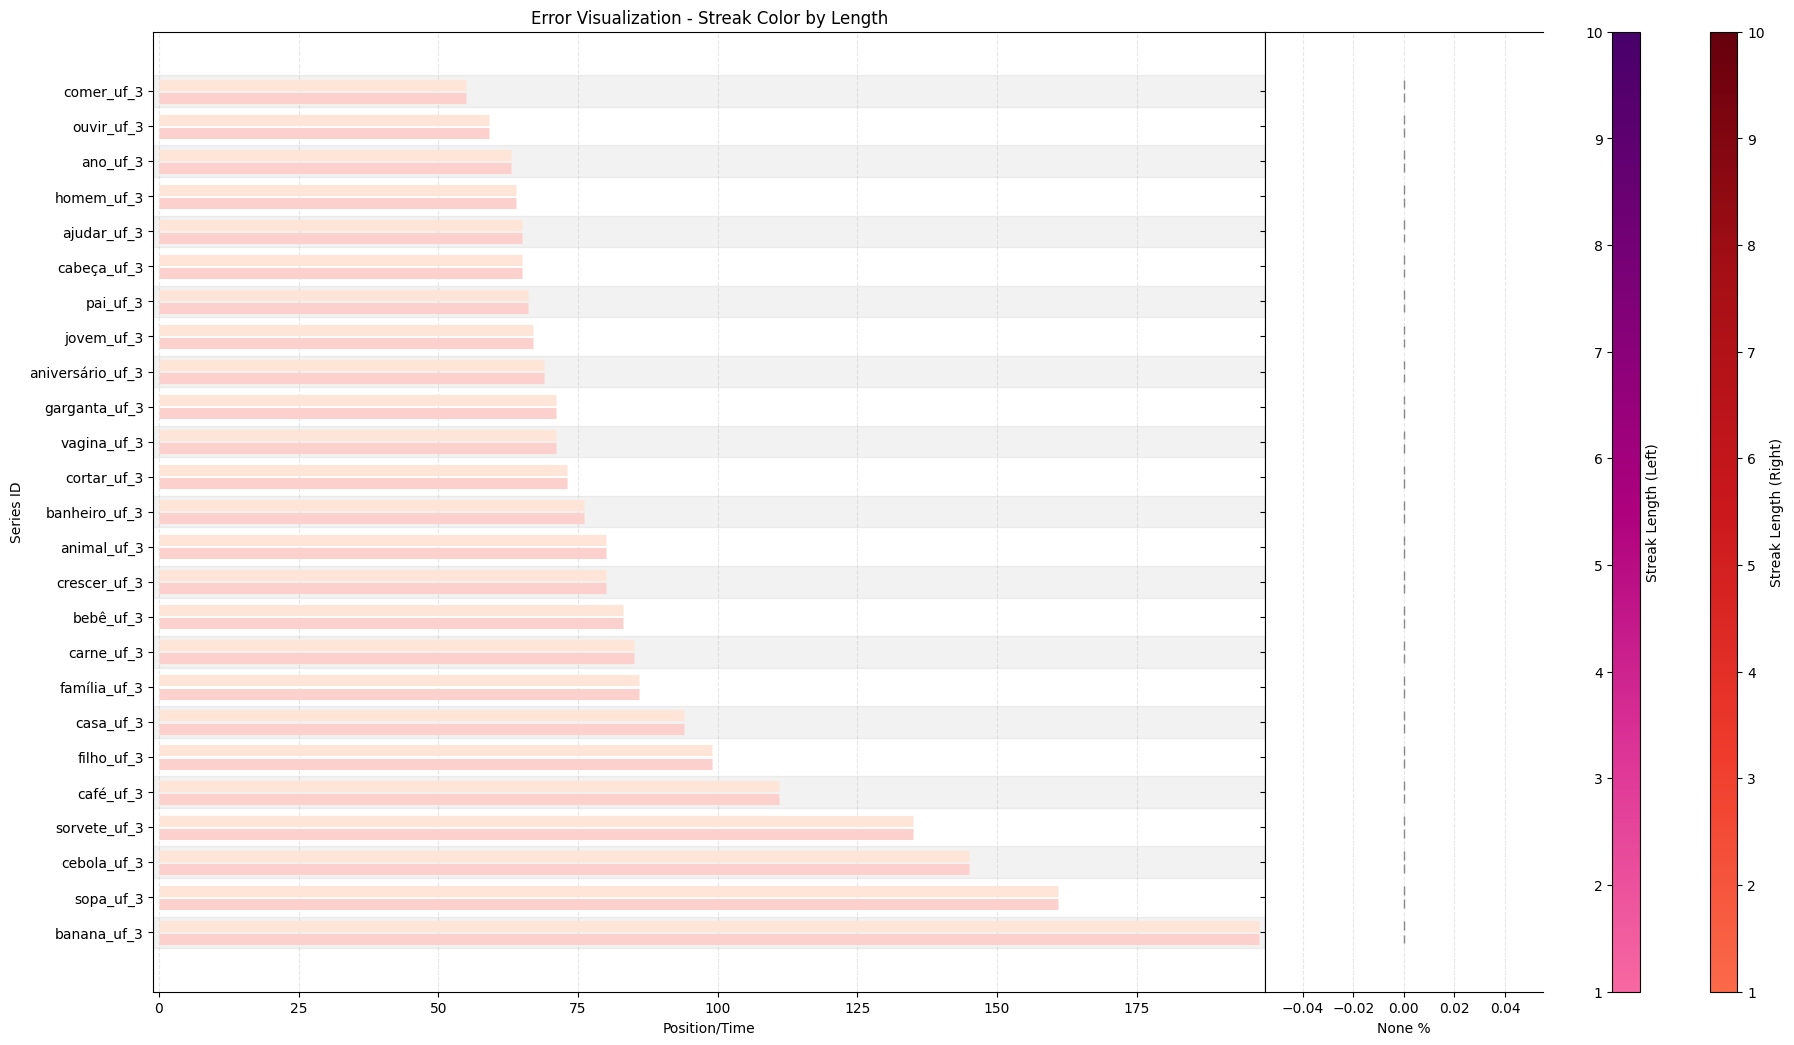

In [43]:
viz.series_none_frame_visualization(uf_plot_dict, left_cmap=plt.cm.RdPu, right_cmap=plt.cm.Reds, sort_length=True)

## Hand Position

- Some INES videos have a hand outside the frame for the whole video, resulting in all Landmarks of that type being None
- Many other videos have a hand outside the frame at the beginning or end of the video, resulting in the landmarks for those periods being None
- The interpolation method in v4 just imputes those None values with the first non-None frame
- This is a bit of a crude strategy, but it is not too bad. However if all frames in a video are None for a landmark type, what do we impute?
- So this section looks into the landmarks before interpolation to help decide the imputing strategy

In [57]:
color_dict = {
    'ne': (0, 125/255, 255/255), # blue
    'vl': (0, 255/255, 0), # green
    'sb': (255/255, 0, 0), # red
    'uf': (255/255, 255/255, 0), # yellow
}

In [58]:
def is_nan_or_contains_nan(val):
    try:
        # If val is scalar
        if np.isscalar(val):
            return np.isnan(val)
        # If val is list/array
        val_array = np.asarray(val)
        return np.isnan(val_array).any()
    except Exception:
        return False

In [59]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
def fig_to_array(fig):
    canvas = FigureCanvas(fig)  # attach canvas to figure
    fig.set_canvas(canvas)      # <--- important fix
    canvas.draw()
    buf = canvas.buffer_rgba()  # use buffer_rgba() instead of tostring_rgb()
    img = np.asarray(buf)[:, :, :3]  # drop alpha channel if not needed
    plt.close(fig)
    return img

### All Frames

In [56]:
interim_landmarks_path = path_to_root + '/data/interim/Debug/landmarks/'

landmarks_info = []
landmarks_avg_list = []

for i, row in analysis_info[:].iterrows():
    fn = row['metadata_filename']
    trimmed_fn = fn.replace('.mp4', '_aligned.npy')

    start_frame = row['metadata_start_frame']
    end_frame = row['metadata_end_frame']

    landmarks_path = interim_landmarks_path + trimmed_fn
    landmarks = np.load(landmarks_path, allow_pickle=True)
    
    stationary_frames = landmarks #np.concatenate([landmarks[:start_frame], landmarks[end_frame:]])

    landmarks_dict_list = []

    for frame in stationary_frames:
        landmarks_dict = {
            'left_hand_landmarks_all':[],
            'right_hand_landmarks_all':[],
            'face_landmarks_all':[],
            'left_hand_landmarks':[],
            'right_hand_landmarks':[],
            'face_landmarks':[],
            'left_hand_landmarks_avg':[],
            'right_hand_landmarks_avg':[],
            'face_landmarks_avg':[]
        }
        for key in ['left_hand_landmarks', 'right_hand_landmarks', 'face_landmarks']:
            if frame[key] is not None:
                for lm in frame[key].landmark:
                    landmarks_dict[key].append((lm.x, lm.y))
                frame_avg_pos = np.array(landmarks_dict[key]).mean(axis=0)
                landmarks_dict[key+'_avg'] = frame_avg_pos
        
        landmarks_dict_list.append(landmarks_dict)
    sample_avg_dict =  {}
    for key in ['left_hand_landmarks_avg', 'right_hand_landmarks_avg', 'face_landmarks_avg']:
        frame_avgs = []
        for landmarks_dict in landmarks_dict_list:
            if len(landmarks_dict[key]) > 0:
                frame_avgs.append(landmarks_dict[key])
        sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)

    landmarks_info.append(landmarks_dict_list)
    landmarks_avg_list.append(sample_avg_dict)

/tmp/ipykernel_1463/624897986.py:43: RuntimeWarning: Mean of empty slice.
  sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)
/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


#### All Data Sources

In [104]:
all_source_plots = []

In [105]:
canvas = np.ones((750,750,3))  #
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['left_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)

        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)

plt.title('Average positions for each frame, for each sample (Left Hand)');

all_source_plots.append(plt.gcf())
plt.close()

In [106]:
canvas = np.ones((750,750,3))  # 
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['right_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)
        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)
plt.title('Average positions for each frame, for each sample (Right Hand)');

all_source_plots.append(plt.gcf())
plt.close()

In [107]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]

    # avg posit for each sample
    lm = sample['left_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Left hand)');

all_source_plots.append(plt.gcf())
plt.close()

In [108]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    lm = sample['right_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Right hand)');

all_source_plots.append(plt.gcf())
plt.close()

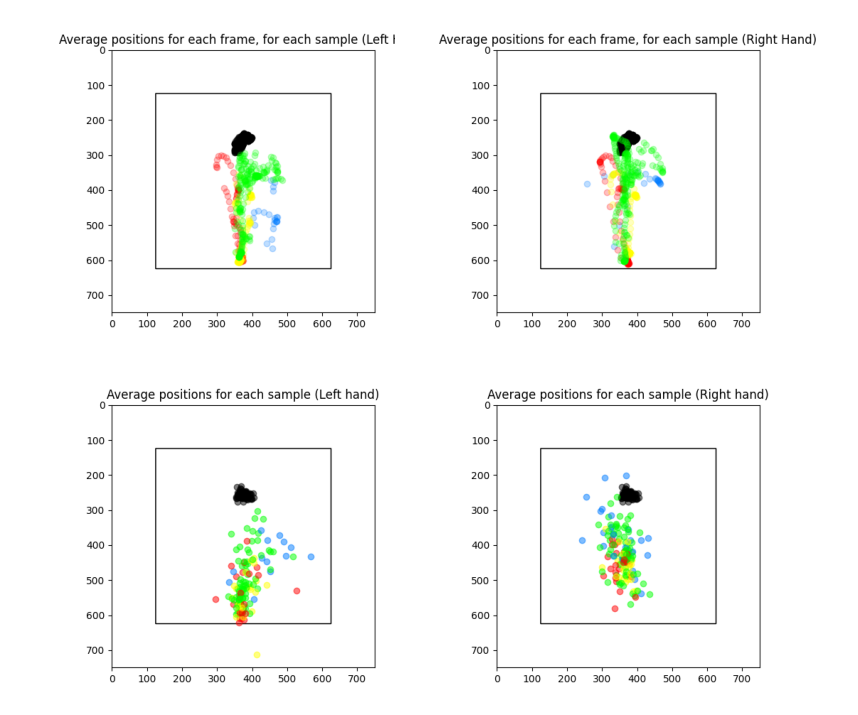

In [127]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
if len(all_source_plots) == 1:
    axes = [axes]

for ax, fig in zip(axes.flatten(), all_source_plots):
    img = fig_to_array(fig)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=-5)
plt.show()

#### Just INES

In [128]:
ines_plots = []

In [134]:
canvas = np.ones((750,750,3))  #
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['left_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)

        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)

plt.title('Average positions for each frame, for each sample (Left Hand)');
ines_plots.append(plt.gcf())
plt.close()

In [135]:
canvas = np.ones((750,750,3))  # 
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['right_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)
        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)
plt.title('Average positions for each frame, for each sample (Right Hand)');
ines_plots.append(plt.gcf())
plt.close()

In [136]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]

    # avg posit for each sample
    lm = sample['left_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Left hand)');
ines_plots.append(plt.gcf())
plt.close()

In [137]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    lm = sample['right_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Right hand)');
ines_plots.append(plt.gcf())
plt.close()

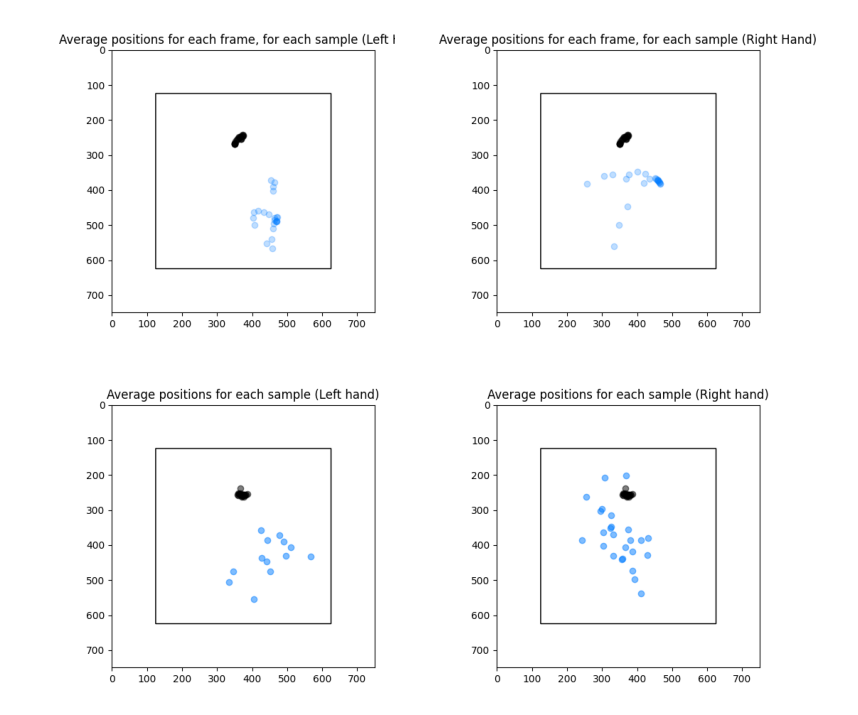

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for ax, fig in zip(axes.flatten(), ines_plots):
    img = fig_to_array(fig)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=-5)
plt.show()

### Just First & Last non-None frames

#### All data sources

In [237]:
all_first_last = []

In [238]:
first_non_none_left = []
last_non_none_left = []
first_non_none_right = []
last_non_none_right = []

first_non_none_left_all = []
last_non_none_left_all = []
first_non_none_right_all = []
last_non_none_right_all = []

In [239]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    color = color_dict[data]
    
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5

    all_none = True
    for key in ['left_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for i, (frame) in enumerate(sample):
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                if key == 'left_hand_landmarks_avg':
                    lminfo = {
                        'fn': fn,
                        'data_source': data,
                        'key': key,
                        'frame': i,
                        'length': len(sample),
                        'x': lm[0],
                        'y': lm[1],
                    }
                    first_non_none_left.append(lminfo)
                    lm_all = frame[key[:-4]]
                    first_non_none_left_all.append(lm_all)
                break
        # if all_none:
        #     print(fn, key, ': all none')
plt.title('avg pos for first non-None frame (Left hand)');

all_first_last.append(plt.gcf())
plt.close()

In [240]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    color = color_dict[data]
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5
        
    all_none = True
    for key in ['left_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for i, (frame) in enumerate(sample[::-1]):
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                if key == 'left_hand_landmarks_avg':
                    lminfo = {
                        'fn': fn,
                        'data_source': data,
                        'key': key,
                        'frame': i,
                        'length': len(sample),
                        'x': lm[0],
                        'y': lm[1],
                    }
                    last_non_none_left.append(lminfo)
                    lm_all = frame[key[:-4]]
                    last_non_none_left_all.append(lm_all)
                    break
        # if all_none:
        #     print(fn, key, ': all none')

plt.title('avg pos for last non-None frame (Left hand)');

all_first_last.append(plt.gcf())
plt.close()

In [241]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    color = color_dict[data]
    
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5

    all_none = True
    for key in ['right_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for i, (frame) in enumerate(sample):
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                if key == 'right_hand_landmarks_avg':
                    lminfo = {
                        'fn': fn,
                        'data_source': data,
                        'key': key,
                        'frame': i,
                        'length': len(sample),
                        'x': lm[0],
                        'y': lm[1],
                        }
                    first_non_none_right.append(lminfo)
                    lm_all = frame[key[:-4]]
                    first_non_none_right_all.append(lm_all)
                    break
        # if all_none:
        #     print(fn, key, ': all none')
plt.title('avg pos for first non-None frame (Right hand)');

all_first_last.append(plt.gcf())
plt.close()

In [242]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    color = color_dict[data]
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5
        
    all_none = True
    for key in ['right_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for i, (frame) in enumerate(sample[::-1]):
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                if key == 'right_hand_landmarks_avg':
                    lminfo = {
                        'fn': fn,
                        'data_source': data,
                        'key': key,
                        'frame': i,
                        'length': len(sample),
                        'x': lm[0],
                        'y': lm[1],
                    }
                    last_non_none_right.append(lminfo)
                    lm_all = frame[key[:-4]]
                    last_non_none_right_all.append(lm_all)
                break
        # if all_none:
        #     print(fn, key, ': all none')

plt.title('avg pos for last non-None frame (Right hand)');

all_first_last.append(plt.gcf())
plt.close()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for ax, fig in zip(axes.flatten(), all_first_last):
    img = fig_to_array(fig)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=-5)
plt.show()

#### Imputing Info

In [246]:
first_non_none_left_df = pd.DataFrame(first_non_none_left)
last_non_none_left_df = pd.DataFrame(last_non_none_left)
first_non_none_right_df = pd.DataFrame(first_non_none_right)
last_non_none_right_df = pd.DataFrame(last_non_none_right)

first_non_none_left_df = first_non_none_left_df[first_non_none_left_df.key != 'face_landmarks_avg'].reset_index(drop=True)
last_non_none_left_df = last_non_none_left_df[last_non_none_left_df.key != 'face_landmarks_avg'].reset_index(drop=True)
first_non_none_right_df = first_non_none_right_df[first_non_none_right_df.key != 'face_landmarks_avg'].reset_index(drop=True)
last_non_none_right_df = last_non_none_right_df[last_non_none_right_df.key != 'face_landmarks_avg'].reset_index(drop=True)

first_non_none_left_df['type'] = 'first_non_none_left'
last_non_none_left_df['type'] = 'last_non_none_left'
first_non_none_right_df['type'] = 'first_non_none_right'
last_non_none_right_df['type'] = 'last_non_none_right'

all_types = pd.concat([first_non_none_left_df, last_non_none_left_df, first_non_none_right_df, last_non_none_right_df])
all_types.head()

fn data_source                      key  frame  length  \
0  ajudar_ne_1.mp4          ne  left_hand_landmarks_avg     10      44   
1  ajudar_sb_2.mp4          sb  left_hand_landmarks_avg      0      79   
2  ajudar_uf_3.mp4          uf  left_hand_landmarks_avg      0     115   
3  ajudar_vl_4.mp4          vl  left_hand_landmarks_avg      0     141   
4  ajudar_vl_5.mp4          vl  left_hand_landmarks_avg      0     108   

          x         y                 type  
0  0.633336  0.855098  first_non_none_left  
1  0.492126  0.933758  first_non_none_left  
2  0.477609  0.948021  first_non_none_left  
3  0.475655  0.928341  first_non_none_left  
4  0.495804  0.848408  first_non_none_left

In [292]:
np.array(last_non_none_left_all).shape, np.array(first_non_none_right_all).shape , np.array(last_non_none_right_all).shape

((138, 21, 2), (150, 21, 2), (150, 21, 2))

In [295]:
column_names = [f"tuple_{i+1}_{axis}" for i in range(21) for axis in ['x', 'y']]

first_non_none_left_all_flat = np.array(first_non_none_left_all).reshape(138, -1)  # shape: (138, 42)
first_non_none_left_all_df = pd.DataFrame(first_non_none_left_all_flat, columns=column_names)

last_non_none_left_all_flat = np.array(last_non_none_left_all).reshape(138, -1)  # shape: (138, 42)
last_non_none_left_all_df = pd.DataFrame(last_non_none_left_all_flat, columns=column_names)

first_non_none_right_all_flat = np.array(first_non_none_right_all).reshape(150, -1)  # shape: (138, 42)
first_non_none_right_all_df = pd.DataFrame(first_non_none_right_all_flat, columns=column_names)

last_non_none_right_all_flat = np.array(last_non_none_right_all).reshape(150, -1)  # shape: (138, 42)
last_non_none_right_all_df = pd.DataFrame(last_non_none_right_all_flat, columns=column_names)

all_lm_all_types_df = pd.concat([first_non_none_left_all_df, last_non_none_left_all_df, first_non_none_right_all_df, last_non_none_right_all_df])

In [296]:
all_lm_all_types_df.shape, all_types.shape

((576, 42), (576, 8))

In [299]:
all_lm_all_types_df['fn'] = all_types['fn']
all_lm_all_types_df['data_source'] = all_types['data_source']
all_lm_all_types_df['key'] = all_types['key']
all_lm_all_types_df['type'] = all_types['type']

In [300]:
all_lm_all_types_df.drop(['fn', 'key'], axis=1).groupby(['type','data_source',]).mean().style.background_gradient()

In [315]:
mean_row = df.drop('type', axis=1).mean()
mean_points = np.array([
        [mean_row[f"tuple_{j}_x"], mean_row[f"tuple_{j}_y"]]
        for j in range(1, 22)
    ])

In [316]:
mean_points

array([[0.394672  , 0.86100741],
       [0.42326583, 0.84251928],
       [0.45406794, 0.83179773],
       [0.47985506, 0.83175995],
       [0.49998716, 0.83296496],
       [0.46324318, 0.8348546 ],
       [0.49855501, 0.84455923],
       [0.50507748, 0.85055203],
       [0.50514232, 0.85397214],
       [0.45829216, 0.84850871],
       [0.49500092, 0.8607043 ],
       [0.50208201, 0.86641942],
       [0.50307736, 0.86890509],
       [0.45249867, 0.8620062 ],
       [0.48744072, 0.87367373],
       [0.49492217, 0.8781263 ],
       [0.49686674, 0.87958484],
       [0.44665815, 0.87513953],
       [0.47471083, 0.88315522],
       [0.48220226, 0.88626028],
       [0.48494379, 0.88746139]])

In [313]:
df

tuple_1_x  tuple_1_y  tuple_2_x  tuple_2_y  tuple_3_x  tuple_3_y  \
0     0.340625   0.905333   0.367388   0.879137   0.396889   0.859275   
1     0.389932   0.933155   0.419021   0.890146   0.454028   0.870931   
2     0.416658   0.931415   0.439582   0.907385   0.475158   0.882595   
3     0.402341   0.910471   0.425822   0.910523   0.452992   0.936382   
4     0.528867   0.620325   0.508673   0.544466   0.510348   0.484809   
..         ...        ...        ...        ...        ...        ...   
145   0.417488   0.951606   0.440649   0.897702   0.473859   0.872021   
146   0.417815   0.882147   0.447147   0.857508   0.485748   0.837547   
147   0.391317   0.945659   0.422875   0.938156   0.455179   0.961664   
148   0.394864   0.789571   0.439716   0.777019   0.464527   0.753217   
149   0.432523   0.765411   0.480435   0.773837   0.507456   0.749082   

     tuple_4_x  tuple_4_y  tuple_5_x  tuple_5_y  ...  tuple_17_y  tuple_18_x  \
0     0.415292   0.850030   0.424692   0.845125  ...    0.871252    0.409911   
1     0.489373   0.876233   0.518553   0.884359  ...    1.001311    0.447666   
2     0.506414   0.873210   0.532431   0.868815  ...    0.955562    0.451819   
3     0.480942   0.960179   0.506503   0.974318  ...    0.940148    0.465488   
4     0.520892   0.443273   0.536505   0.420302  ...    0.468571    0.582708   
..         ...        ...        ...        ...  ...         ...         ...   
145   0.509739   0.871517   0.539043   0.873863  ...    0.990827    0.483317   
146   0.519228   0.829506   0.546390   0.828659  ...    0.913284    0.448378   
147   0.484388   0.986614   0.510984   1.007598  ...    0.970095    0.456914   
148   0.483063   0.739201   0.495754   0.728497  ...    0.759923    0.436256   
149   0.527085   0.732909   0.539764   0.725413  ...    0.743545    0.483880   

     tuple_18_y  tuple_19_x  tuple_19_y  tuple_20_x  tuple_20_y  tuple_21_x  \
0      0.896990    0.424511    0.874285    0.416278    0.869142    0.405470   
1      1.001235    0.490629    1.018657    0.510892    1.018739    0.524732   
2      0.940724    0.487834    0.949729    0.507306    0.958098    0.521360   
3      0.970467    0.490751    0.960568    0.491474    0.944076    0.487023   
4      0.503896    0.585995    0.470623    0.586694    0.465410    0.588570   
..          ...         ...         ...         ...         ...         ...   
145    1.007763    0.526261    1.018354    0.546632    1.015016    0.559283   
146    0.914717    0.478171    0.919107    0.496604    0.922951    0.509679   
147    1.009982    0.484658    0.995440    0.487921    0.978388    0.484597   
148    0.729787    0.471265    0.743022    0.468137    0.756623    0.458760   
149    0.700220    0.520050    0.729432    0.517045    0.748714    0.508956   

     tuple_21_y                 type  
0      0.874058  last_non_none_right  
1      1.012265  last_non_none_right  
2      0.966786  last_non_none_right  
3      0.937382  last_non_none_right  
4      0.466929  last_non_none_right  
..          ...                  ...  
145    1.006169  last_non_none_right  
146    0.925930  last_non_none_right  
147    0.971707  last_non_none_right  
148    0.756947  last_non_none_right  
149    0.750103  last_non_none_right  

[150 rows x 43 columns]

In [368]:
color_dict = {'ne': (0, 0.49019607843137253, 1.0),
 'vl': (0, 1.0, 0),
 'sb': (1.0, 0, 0),
 'uf': (1.0, .5, 0)}

In [395]:
# List of connections based on the image you shared
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),       # Index
    (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
    (0, 13), (13, 14), (14, 15), (15, 16),# Ring
    (0, 17), (17, 18), (18, 19), (19, 20) # Pinky
]
canvases = []
titles = []
for type, gdf in all_lm_all_types_df.drop(['fn', 'key'], axis=1).groupby('type'):
    canvas = np.ones((750,750,3))  # White background
    cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2);
    mean_row = gdf[gdf.data_source != 'ne'].drop(['data_source','type'], axis=1).mean()
    color = (125,0,125)
    mean_points = np.array([
            [(mean_row[f"tuple_{j}_x"]*500)+125, (mean_row[f"tuple_{j}_y"]*500)+125]
            for j in range(1, 22)
        ])
    for start_idx, end_idx in connections:
        pt1 = tuple(np.round(mean_points[start_idx]).astype(int))
        pt2 = tuple(np.round(mean_points[end_idx]).astype(int))
        cv2.line(canvas, pt1, pt2, (0, 0, 0), 2)  # green
    for x, y in mean_points:
        cv2.circle(canvas, (int(x), int(y)), radius=4, color=color, thickness=-1);
    canvases.append(canvas[400:650,100:650])
    titles.append(f"{type} (no ne)")
    
for data_source, gdf in all_lm_all_types_df.drop(['fn', 'key'], axis=1).groupby('data_source'):
    for type, ggdf in gdf.groupby('type'):
        canvas = np.ones((750,750,3))  # White background
        cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2);
        mean_row = ggdf.drop(['data_source','type'], axis=1).mean()
        color = color_dict[data_source]
        mean_points = np.array([
                [(mean_row[f"tuple_{j}_x"]*500)+125, (mean_row[f"tuple_{j}_y"]*500)+125]
                for j in range(1, 22)
            ])
        for start_idx, end_idx in connections:
            pt1 = tuple(np.round(mean_points[start_idx]).astype(int))
            pt2 = tuple(np.round(mean_points[end_idx]).astype(int))
            cv2.line(canvas, pt1, pt2, (0, 0, 0), 2)  # green
        for x, y in mean_points:
            cv2.circle(canvas, (int(x), int(y)), radius=4, color=color, thickness=-1);
        canvases.append(canvas[400:650,100:650])
        titles.append(f"{type}, {data_source}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].


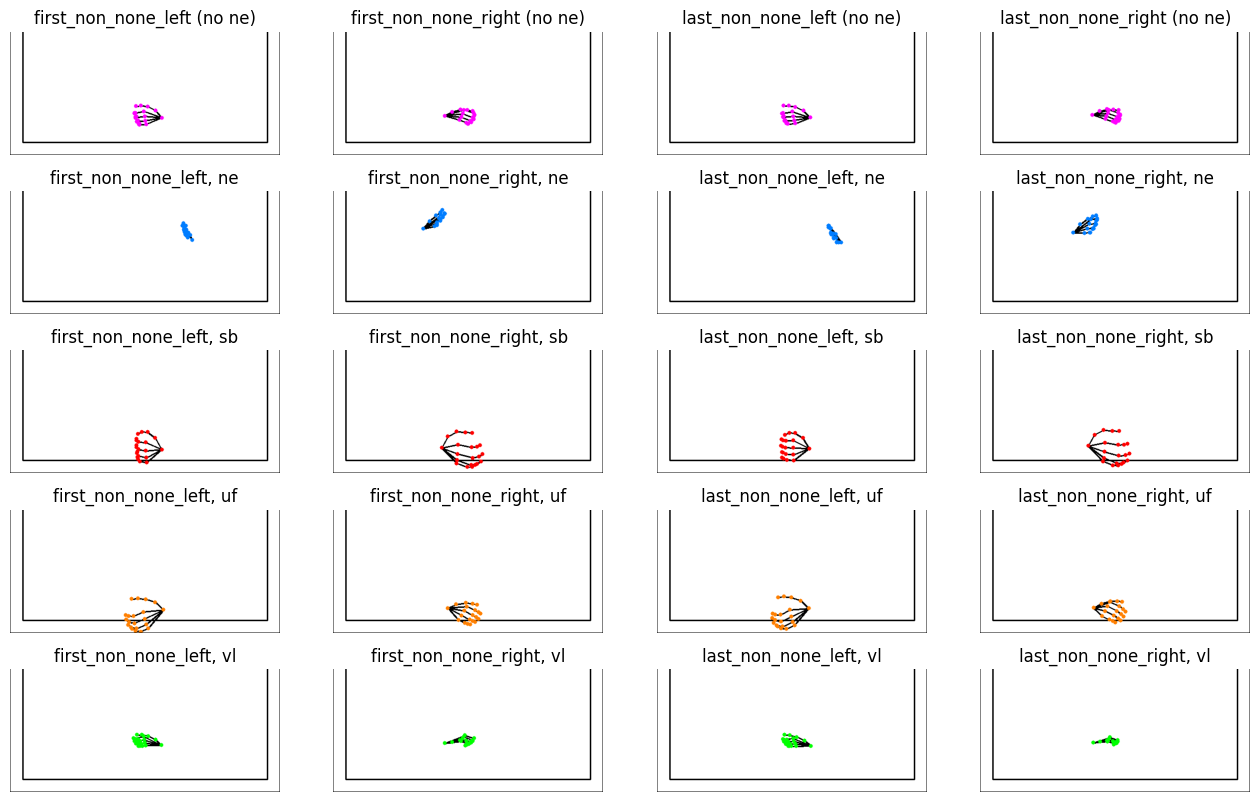

In [396]:
#16 subplots
fig, axs = plt.subplots(5,4, figsize=(16,10))

for ax, canv, title in zip(axs.flatten(), canvases, titles):
    canv = cv2.copyMakeBorder(canv, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=(0,0,0))
    ax.imshow(canv)
    ax.set_title(title)
    ax.axis('off')

In [440]:
all_lm_all_types_df[all_lm_all_types_df.data_source != 'ne'].drop(['fn', 'key', ], axis=1).groupby(['type','data_source',]).mean().groupby(['type']).mean()

tuple_1_x  tuple_1_y  tuple_2_x  tuple_2_y  tuple_3_x  \
type                                                                          
first_non_none_left    0.570134   0.925446   0.541999   0.891222   0.508794   
first_non_none_right   0.404878   0.917800   0.434630   0.895538   0.469833   
last_non_none_left     0.572198   0.922906   0.543435   0.891182   0.509928   
last_non_none_right    0.404929   0.913966   0.433940   0.891717   0.466878   

                      tuple_3_y  tuple_4_x  tuple_4_y  tuple_5_x  tuple_5_y  \
type                                                                          
first_non_none_left    0.874707   0.481209   0.871946   0.460389   0.875290   
first_non_none_right   0.885072   0.499995   0.887501   0.522521   0.890436   
last_non_none_left     0.874927   0.482466   0.871205   0.461336   0.873650   
last_non_none_right    0.880829   0.495845   0.882324   0.518871   0.884376   

                      ...  tuple_17_x  tuple_17_y  tuple_18_x  tuple_18_y  \
type                  ...                                                   
first_non_none_left   ...    0.461358    0.946912    0.507661    0.968447   
first_non_none_right  ...    0.525212    0.957158    0.461776    0.951862   
last_non_none_left    ...    0.458391    0.945049    0.511472    0.962221   
last_non_none_right   ...    0.524327    0.952697    0.455768    0.944901   

                      tuple_19_x  tuple_19_y  tuple_20_x  tuple_20_y  \
type                                                                   
first_non_none_left     0.478255    0.972120    0.470623    0.967296   
first_non_none_right    0.492859    0.964306    0.503005    0.966986   
last_non_none_left      0.480237    0.966019    0.469971    0.963102   
last_non_none_right     0.487712    0.957259    0.500256    0.960743   

                      tuple_21_x  tuple_21_y  
type                                          
first_non_none_left     0.468548    0.962175  
first_non_none_right    0.508561    0.966190  
last_non_none_left      0.466120    0.959707  
last_non_none_right     0.507558    0.961141  

[4 rows x 42 columns]

In [441]:
grouped_hands = all_lm_all_types_df[all_lm_all_types_df.data_source != 'ne'].drop(['fn', 'key', ], axis=1).groupby(['type','data_source',]).mean().groupby(['type']).mean()
grouped_hands.style.background_gradient()

In [449]:
average_hands = {}
left_x_shift = 0.0
right_x_shift = 0.0
left_y_shift = 0.0
right_y_shift = 0.0
i = 0
for type, row in grouped_hands.iterrows():
    points = [(row[f"tuple_{j}_x"],row[f"tuple_{j}_y"],0) for j in range(1,22)]
    if 'left' in type:
        points = [(point[0]+left_x_shift,point[1]+left_y_shift,0) for point in points]
    else:
        points = [(point[0]+right_x_shift,point[1]+right_y_shift,0) for point in points]
    
    average_hands[type] = {k:point for k, point in enumerate(points)}
    average_x = np.array(points)[:,0].mean()
    average_y = np.array(points)[:,1].mean()
    print(type)
    print(average_x, average_y)

first_non_none_left
0.4817269501105817 0.9281206550799981
first_non_none_right
0.49786274361231975 0.9299787957453853
last_non_none_left
0.4828156430569906 0.9252711974249946
last_non_none_right
0.4932423664779259 0.9241347494453351


In [445]:
average_hands

{'first_non_none_left': {0: (0.5701340108447605, 0.9254463587866889, 0),
  1: (0.5419992844263712, 0.8912224663628473, 0),
  2: (0.5087941461139255, 0.8747069941626654, 0),
  3: (0.4812094243367513, 0.8719460286034478, 0),
  4: (0.4603893379370372, 0.8752896446651883, 0),
  5: (0.4967411657174428, 0.9066602818171182, 0),
  6: (0.4594160078631507, 0.9141682198312547, 0),
  7: (0.45282431840896603, 0.912611854341295, 0),
  8: (0.4527227889166938, 0.9098687436845566, 0),
  9: (0.49935692124896575, 0.9319392519527012, 0),
  10: (0.46218078798717926, 0.9376012081570096, 0),
  11: (0.45575203273031445, 0.9329026590453253, 0),
  12: (0.4556537403000725, 0.9273211820920308, 0),
  13: (0.5033633614910974, 0.9525074587927924, 0),
  14: (0.4678054269154866, 0.9570006526841057, 0),
  15: (0.46147779451476206, 0.9523911301294964, 0),
  16: (0.46135794162750243, 0.9469116168551975, 0),
  17: (0.5076610920164321, 0.9684465750058492, 0),
  18: (0.47825529482629564, 0.9721203623877631, 0),
  19: (0.470

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].


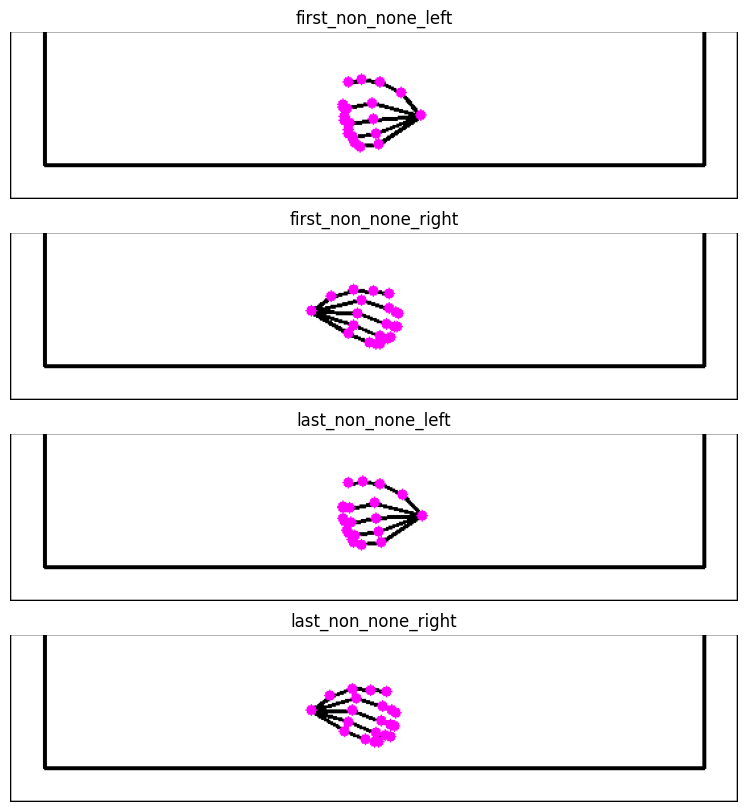

In [454]:
# List of connections based on the image you shared
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),       # Index
    (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
    (0, 13), (13, 14), (14, 15), (15, 16),# Ring
    (0, 17), (17, 18), (18, 19), (19, 20) # Pinky
]
canvases = []
titles = []
for key, lm_dict in average_hands.items():
    canvas = np.ones((750,750,3))  # White background
    cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2);
    color = (125,0,125)
    mean_points = np.array([
            [(lm_dict[j][0]*500)+125, (lm_dict[j][1]*500)+125]
            for j in range(0, 21)
        ])
    for start_idx, end_idx in connections:
        pt1 = tuple(np.round(mean_points[start_idx]).astype(int))
        pt2 = tuple(np.round(mean_points[end_idx]).astype(int))
        cv2.line(canvas, pt1, pt2, (0, 0, 0), 2)  # green
    for x, y in mean_points:
        cv2.circle(canvas, (int(x), int(y)), radius=4, color=color, thickness=-1);
    canvases.append(canvas[525:650,100:650])
    titles.append(key)
#16 subplots
fig, axs = plt.subplots(4,1, figsize=(16,10))

for ax, canv, title in zip(axs.flatten(), canvases, titles):
    canv = cv2.copyMakeBorder(canv, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=(0,0,0))
    ax.imshow(canv)
    ax.set_title(title)
    ax.axis('off')

In [455]:
path_to_root

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [456]:
# save as json
import json
with open(path_to_root + '/data/interim/average_hands.json', 'w') as f:
    json.dump(average_hands, f, indent=4)


In [134]:
all_types.drop(['fn', 'key'], axis=1).groupby(['type','data_source',]).mean().style.background_gradient()

In [135]:
all_types.drop(['fn', 'key', 'frame'], axis=1).groupby(['type','data_source',]).describe().style.background_gradient()

For INES, we'll sample from the 25% - 75% range of the other 3 data sources for imputing.

From the data sources

In [136]:
impute_sample_range = {
    "first_non_none_left_x" : [0.461507, 0.500579],     # UF, VL
    "first_non_none_right_x" : [0.475575, 0.512652],    # VL, UF
    "last_non_none_left_x" : [0.459580, 0.505623],      # UF, VL
    "last_non_none_right_x" : [0.471939, 0.503520],     # VL, SB

    "first_non_none_left_y" : [0.801834, 1.164328],     # VL, SB
    "first_non_none_right_y" : [0.813190, 1.161561],    # VL, SB
    "last_non_none_left_y" : [0.817679, 1.152018],      # UF, VL
    "last_non_none_right_y" : [0.799989, 1.142999],     # VL, SB
}

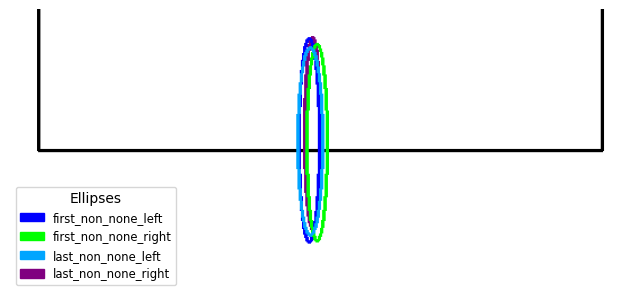

In [154]:
# olor map for unique base keys
color_map = {
    "first_non_none_left": (255, 0, 0),      # Blue
    "first_non_none_right": (0, 255, 0),     # Green
    "last_non_none_left": (255, 165, 0),     # Orange
    "last_non_none_right": (128, 0, 128),    # Purple
}

# Create the canvas and draw the main square
canvas = np.ones((750, 750, 3), dtype=np.uint8) * 255
cv2.rectangle(canvas, (125, 125), (625, 625), (0, 0, 0), 2)

# Extract base keys
base_keys = set(k.rsplit('_', 1)[0] for k in impute_sample_range.keys())

for base in base_keys:
    x_range = impute_sample_range.get(base + '_x')
    y_range = impute_sample_range.get(base + '_y')

    if x_range is None or y_range is None:
        continue

    # Compute center and axes (half of width and height)
    x_center = (x_range[0] + x_range[1]) / 2
    y_center = (y_range[0] + y_range[1]) / 2
    center_px = (int(x_center * 500 + 125), int(y_center * 500 + 125))

    axis_length = (
        int((x_range[1] - x_range[0]) * 500 / 2),
        int((y_range[1] - y_range[0]) * 500 / 2),
    )

    # Get color for base key
    color = color_map.get(base, (0, 0, 0))  # default black if not mapped

    # Draw ellipse
    cv2.ellipse(
        canvas,
        center=center_px,
        axes=axis_length,
        angle=0,
        startAngle=0,
        endAngle=360,
        color=color,
        thickness=2
    )


# Display the canvas
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(canvas[500:,100:650], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.axis('off')
from matplotlib.patches import Patch

# Create legend handles from color_map
legend_handles = [
    Patch(color=np.array(color_map[key][::-1]) / 255.0, label=key)
    for key in color_map
]

# Add legend to the plot
plt.legend(
    handles=legend_handles,
    loc='lower left',
    fontsize='small',
    title='Ellipses',
    frameon=True,
)
plt.show()


Manually chosen

In [173]:
impute_sample_range = {
    "first_non_none_left_x" : [0.5, 0.57],
    "first_non_none_right_x" : [0.43, 0.5],
    "last_non_none_left_x" : [0.5, 0.57],
    "last_non_none_right_x" : [0.43, 0.5],

    "first_non_none_left_y" : [0.8, 1],
    "first_non_none_right_y" : [0.8, 1],
    "last_non_none_left_y" : [0.8, 1],
    "last_non_none_right_y" : [0.8, 1],
}

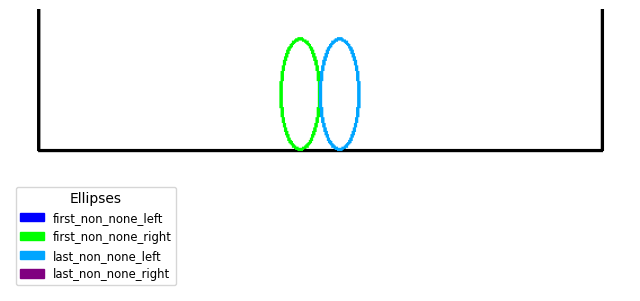

In [174]:
# olor map for unique base keys
color_map = {
    "first_non_none_left": (255, 0, 0),      # Blue
    "first_non_none_right": (0, 255, 0),     # Green
    "last_non_none_left": (255, 165, 0),     # Orange
    "last_non_none_right": (128, 0, 128),    # Purple
}

# Create the canvas and draw the main square
canvas = np.ones((750, 750, 3), dtype=np.uint8) * 255
cv2.rectangle(canvas, (125, 125), (625, 625), (0, 0, 0), 2)

# Extract base keys
base_keys = set(k.rsplit('_', 1)[0] for k in impute_sample_range.keys())

for base in base_keys:
    x_range = impute_sample_range.get(base + '_x')
    y_range = impute_sample_range.get(base + '_y')

    if x_range is None or y_range is None:
        continue

    # Compute center and axes (half of width and height)
    x_center = (x_range[0] + x_range[1]) / 2
    y_center = (y_range[0] + y_range[1]) / 2
    center_px = (int(x_center * 500 + 125), int(y_center * 500 + 125))

    axis_length = (
        int((x_range[1] - x_range[0]) * 500 / 2),
        int((y_range[1] - y_range[0]) * 500 / 2),
    )

    # Get color for base key
    color = color_map.get(base, (0, 0, 0))  # default black if not mapped

    # Draw ellipse
    cv2.ellipse(
        canvas,
        center=center_px,
        axes=axis_length,
        angle=0,
        startAngle=0,
        endAngle=360,
        color=color,
        thickness=2
    )


# Display the canvas
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(canvas[500:,100:650], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.axis('off')
from matplotlib.patches import Patch

# Create legend handles from color_map
legend_handles = [
    Patch(color=np.array(color_map[key][::-1]) / 255.0, label=key)
    for key in color_map
]

# Add legend to the plot
plt.legend(
    handles=legend_handles,
    loc='lower left',
    fontsize='small',
    title='Ellipses',
    frameon=True,
)
plt.show()


In [ ]:
interim_landmarks_path = path_to_root + '/data/interim/Debug/landmarks/'

landmarks_info = []
landmarks_avg_list = []

for i, row in analysis_info[:].iterrows():
    fn = row['metadata_filename']
    trimmed_fn = fn.replace('.mp4', '_aligned.npy')

    start_frame = row['metadata_start_frame']
    end_frame = row['metadata_end_frame']

    landmarks_path = interim_landmarks_path + trimmed_fn
    landmarks = np.load(landmarks_path, allow_pickle=True)
    
    stationary_frames = landmarks #np.concatenate([landmarks[:start_frame], landmarks[end_frame:]])

    landmarks_dict_list = []

    for frame in stationary_frames:
        landmarks_dict = {
            'left_hand_landmarks':[],
            'right_hand_landmarks':[],
            'face_landmarks':[],
            'left_hand_landmarks_avg':[],
            'right_hand_landmarks_avg':[],
            'face_landmarks_avg':[]
        }
        for key in ['left_hand_landmarks', 'right_hand_landmarks', 'face_landmarks']:
            if frame[key] is not None:
                for lm in frame[key].landmark:
                    landmarks_dict[key].append((lm.x, lm.y))
                frame_avg_pos = np.array(landmarks_dict[key]).mean(axis=0)
                landmarks_dict[key+'_avg'] = frame_avg_pos
        
        landmarks_dict_list.append(landmarks_dict)
    sample_avg_dict =  {}
    for key in ['left_hand_landmarks_avg', 'right_hand_landmarks_avg', 'face_landmarks_avg']:
        frame_avgs = []
        for landmarks_dict in landmarks_dict_list:
            if len(landmarks_dict[key]) > 0:
                frame_avgs.append(landmarks_dict[key])
        sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)

    landmarks_info.append(landmarks_dict_list)
    landmarks_avg_list.append(sample_avg_dict)

#### Just INES

In [80]:
ines_first_last = []

In [81]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5

    all_none = True
    for key in ['left_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for frame in sample:
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                break
        # if all_none:
        #     print(fn, key, ': all none')
plt.title('avg pos for first non-None frame (Left hand)');


ines_first_last.append(plt.gcf())
plt.close()

In [82]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5
        
    all_none = True
    for key in ['left_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for frame in sample[::-1]:
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                break
        # if all_none:
        #     print(fn, key, ': all none')

plt.title('avg pos for last non-None frame (Left hand)');

ines_first_last.append(plt.gcf())
plt.close()

In [83]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5

    all_none = True
    for key in ['right_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for frame in sample:
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                break
        # if all_none:
        #     print(fn, key, ': all none')
plt.title('avg pos for first non-None frame (Right hand)');

ines_first_last.append(plt.gcf())
plt.close()

In [84]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:].iterrows()):
    fn = row.metadata_filename

    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    if data =='vl':
        alpha = 0.25
    else:
        alpha = 0.5
        
    all_none = True
    for key in ['right_hand_landmarks_avg', 'face_landmarks_avg']:
        if key == 'face_landmarks_avg':
            color = (0,0,0)
        for frame in sample[::-1]:
            if len(frame[key]) > 0:
                all_none = False
                lm = frame[key]
                plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=alpha)
                break
        # if all_none:
        #     print(fn, key, ': all none')

plt.title('avg pos for last non-None frame (right hand)');

ines_first_last.append(plt.gcf())
plt.close()

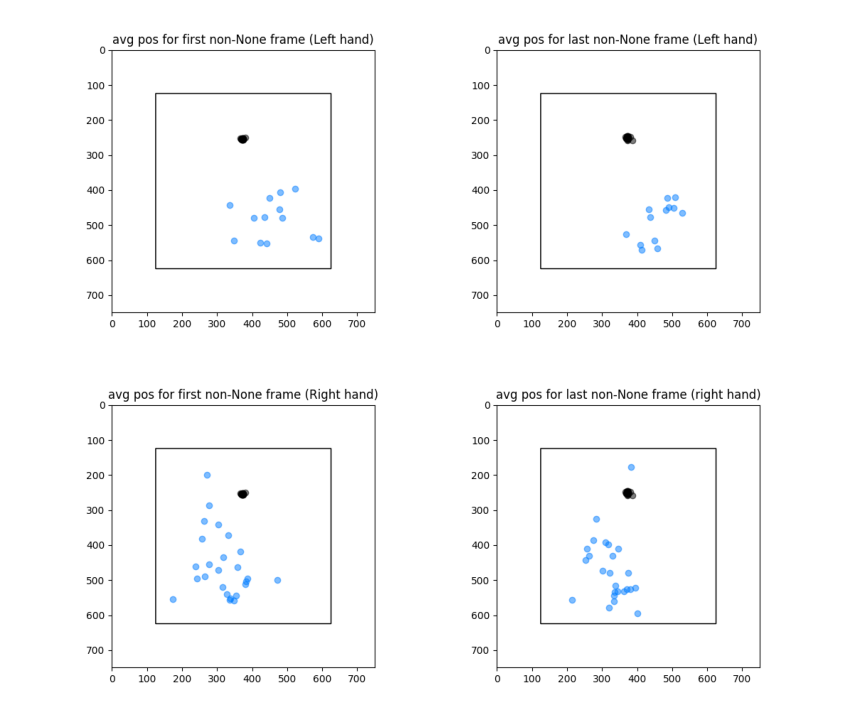

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for ax, fig in zip(axes.flatten(), ines_first_last):
    img = fig_to_array(fig)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=-5)
plt.show()

### Just Stationary Frames

In [165]:
i

0

In [205]:
interim_landmarks_path = path_to_root + '/data/interim/Debug/landmarks/'

landmarks_info = []
landmarks_avg_list = []

for i, row in analysis_info[:].iterrows():
    fn = row['metadata_filename']
    trimmed_fn = fn.replace('.mp4', '_aligned.npy')

    start_frame = row['metadata_start_frame']
    end_frame = row['metadata_end_frame']

    landmarks_path = interim_landmarks_path + trimmed_fn
    landmarks = np.load(landmarks_path, allow_pickle=True)
    
    stationary_frames = np.concatenate([landmarks[:start_frame], landmarks[end_frame:]])

    all_none = True
    for key in ['left_hand_landmarks', 'right_hand_landmarks', 'face_landmarks']:
        for frame in stationary_frames:
            if frame[key] is not None:
                all_none = False
                break
        if all_none:
            print(fn, key, ': all none')
        


    landmarks_dict_list = []

    for frame in stationary_frames:
        landmarks_dict = {
            'left_hand_landmarks':[],
            'right_hand_landmarks':[],
            'face_landmarks':[],
            'left_hand_landmarks_avg':[],
            'right_hand_landmarks_avg':[],
            'face_landmarks_avg':[]
        }
        for key in ['left_hand_landmarks', 'right_hand_landmarks', 'face_landmarks']:
            if frame[key] is not None:
                for lm in frame[key].landmark:
                    landmarks_dict[key].append((lm.x, lm.y))
                frame_avg_pos = np.array(landmarks_dict[key]).mean(axis=0)
                landmarks_dict[key+'_avg'] = frame_avg_pos
        
        landmarks_dict_list.append(landmarks_dict)
    sample_avg_dict =  {}
    for key in ['left_hand_landmarks_avg', 'face_landmarks_avg', 'right_hand_landmarks_avg']:
        frame_avgs = []
        for landmarks_dict in landmarks_dict_list:
            if len(landmarks_dict[key]) > 0:
                frame_avgs.append(landmarks_dict[key])
        sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)

    landmarks_info.append(landmarks_dict_list)
    landmarks_avg_list.append(sample_avg_dict)

ajudar_ne_1.mp4 left_hand_landmarks : all none
ajudar_ne_1.mp4 right_hand_landmarks : all none
animal_ne_1.mp4 left_hand_landmarks : all none
animal_ne_1.mp4 right_hand_landmarks : all none


/tmp/ipykernel_87854/2435634245.py:54: RuntimeWarning: Mean of empty slice.
  sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)


aniversário_ne_1.mp4 left_hand_landmarks : all none
aniversário_ne_1.mp4 right_hand_landmarks : all none
ano_ne_1.mp4 left_hand_landmarks : all none
ano_ne_1.mp4 right_hand_landmarks : all none
banana_ne_1.mp4 left_hand_landmarks : all none
banana_ne_1.mp4 right_hand_landmarks : all none
banheiro_ne_1.mp4 left_hand_landmarks : all none
banheiro_ne_1.mp4 right_hand_landmarks : all none
bebê_ne_1.mp4 left_hand_landmarks : all none
bebê_ne_1.mp4 right_hand_landmarks : all none
cabeça_ne_1.mp4 left_hand_landmarks : all none
cabeça_ne_1.mp4 right_hand_landmarks : all none
cabeça_vl_6.mp4 left_hand_landmarks : all none
cabeça_vl_6.mp4 right_hand_landmarks : all none
café_ne_1.mp4 left_hand_landmarks : all none
café_ne_1.mp4 right_hand_landmarks : all none
café_vl_5.mp4 left_hand_landmarks : all none
café_vl_5.mp4 right_hand_landmarks : all none
carne_ne_1.mp4 left_hand_landmarks : all none
carne_ne_1.mp4 right_hand_landmarks : all none
casa_ne_1.mp4 left_hand_landmarks : all none
casa_ne_1.m

In [229]:
interim_landmarks_path = path_to_root + '/data/interim/Debug/landmarks/'

landmarks_info = []
landmarks_avg_list = []

for i, row in analysis_info[:].iterrows():
    data = row['metadata_data_source']
    # if data !='ne':
    #     continue
    fn = row['metadata_filename']
    trimmed_fn = fn.replace('.mp4', '_aligned.npy')

    start_frame = row['metadata_start_frame']
    end_frame = row['metadata_end_frame']

    landmarks_path = interim_landmarks_path + trimmed_fn
    landmarks = np.load(landmarks_path, allow_pickle=True)
    
    stationary_frames = np.concatenate([landmarks[:start_frame+5], landmarks[end_frame-5:]])

    all_none = True
    for key in ['left_hand_landmarks', 'right_hand_landmarks', 'face_landmarks']:
        for frame in stationary_frames:
            if frame[key] is not None:
                all_none = False
                break
        if all_none:
            print(fn, key, ': all none')
        


    landmarks_dict_list = []

    for frame in stationary_frames:
        landmarks_dict = {
            'left_hand_landmarks':[],
            'right_hand_landmarks':[],
            'face_landmarks':[],
            'left_hand_landmarks_avg':[],
            'right_hand_landmarks_avg':[],
            'face_landmarks_avg':[]
        }
        for key in ['left_hand_landmarks', 'right_hand_landmarks', 'face_landmarks']:
            if frame[key] is not None:
                for lm in frame[key].landmark:
                    landmarks_dict[key].append((lm.x, lm.y))
                frame_avg_pos = np.array(landmarks_dict[key]).mean(axis=0)
                landmarks_dict[key+'_avg'] = frame_avg_pos
        
        landmarks_dict_list.append(landmarks_dict)
    sample_avg_dict =  {}
    for key in ['left_hand_landmarks_avg', 'face_landmarks_avg', 'right_hand_landmarks_avg']:
        frame_avgs = []
        for landmarks_dict in landmarks_dict_list:
            if len(landmarks_dict[key]) > 0:
                frame_avgs.append(landmarks_dict[key])
        sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)

    landmarks_info.append(landmarks_dict_list)
    landmarks_avg_list.append(sample_avg_dict)

cabeça_ne_1.mp4 left_hand_landmarks : all none
cabeça_ne_1.mp4 right_hand_landmarks : all none
cabeça_vl_6.mp4 left_hand_landmarks : all none
cabeça_vl_6.mp4 right_hand_landmarks : all none
café_ne_1.mp4 left_hand_landmarks : all none


/tmp/ipykernel_87854/715431293.py:57: RuntimeWarning: Mean of empty slice.
  sample_avg_dict[key] = np.array(frame_avgs).mean(axis=0)


casa_vl_6.mp4 left_hand_landmarks : all none
casa_vl_6.mp4 right_hand_landmarks : all none
cebola_ne_1.mp4 left_hand_landmarks : all none
comer_ne_1.mp4 left_hand_landmarks : all none
crescer_ne_1.mp4 left_hand_landmarks : all none
filho_ne_1.mp4 left_hand_landmarks : all none
garganta_ne_1.mp4 left_hand_landmarks : all none
homem_ne_1.mp4 left_hand_landmarks : all none
homem_sb_2.mp4 left_hand_landmarks : all none
homem_vl_6.mp4 left_hand_landmarks : all none
ouvir_ne_1.mp4 left_hand_landmarks : all none
pai_ne_1.mp4 left_hand_landmarks : all none
sopa_ne_1.mp4 left_hand_landmarks : all none
sorvete_ne_1.mp4 left_hand_landmarks : all none
sorvete_vl_5.mp4 left_hand_landmarks : all none
vagina_ne_1.mp4 left_hand_landmarks : all none


#### All Data Sources

In [215]:
all_source_plots = []

In [216]:
canvas = np.ones((750,750,3))  #
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['left_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)

        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)

plt.title('Average positions for each frame, for each sample (Left Hand)');

all_source_plots.append(plt.gcf())
plt.close()

In [217]:
canvas = np.ones((750,750,3))  # 
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['right_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)
        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)
plt.title('Average positions for each frame, for each sample (Right Hand)');

all_source_plots.append(plt.gcf())
plt.close()

In [218]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]

    # avg posit for each sample
    lm = sample['left_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Left hand)');

all_source_plots.append(plt.gcf())
plt.close()

In [219]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    lm = sample['right_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Right hand)');

all_source_plots.append(plt.gcf())
plt.close()

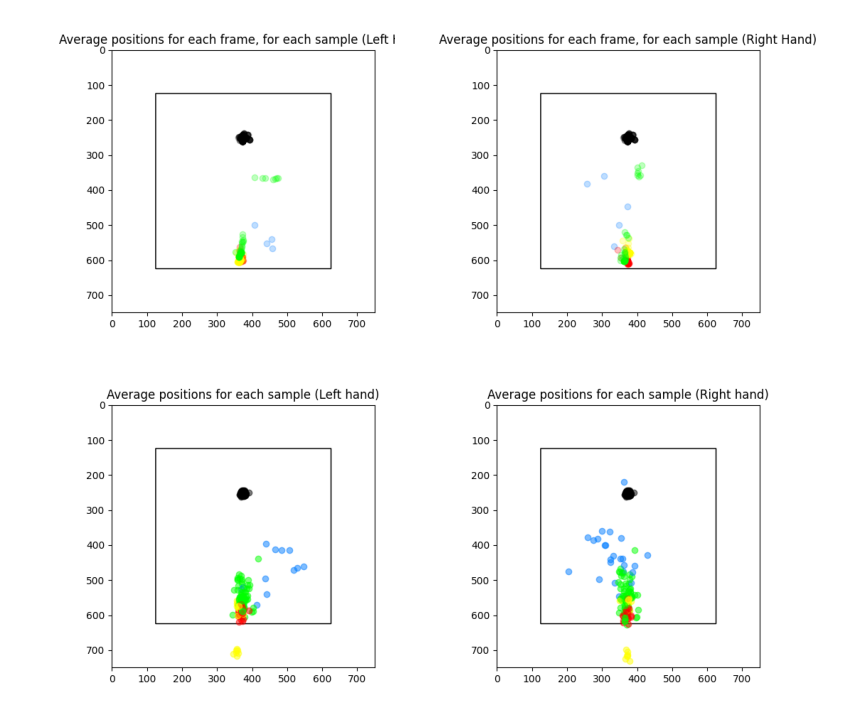

In [220]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
if len(all_source_plots) == 1:
    axes = [axes]

for ax, fig in zip(axes.flatten(), all_source_plots):
    img = fig_to_array(fig)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=-5)
plt.show()

#### Just INES

In [221]:
ines_plots = []

In [222]:
canvas = np.ones((750,750,3))  #
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['left_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)

        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)

plt.title('Average positions for each frame, for each sample (Left Hand)');
ines_plots.append(plt.gcf())
plt.close()

In [223]:
canvas = np.ones((750,750,3))  # 
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_info, analysis_info[:5].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    # avg posit for each frame
    for frame in sample:
        lm = frame['right_hand_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.25)
        lm = frame['face_landmarks_avg']
        if len(lm)>0:
            plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.25)
plt.title('Average positions for each frame, for each sample (Right Hand)');
ines_plots.append(plt.gcf())
plt.close()

In [224]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]

    # avg posit for each sample
    lm = sample['left_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Left hand)');
ines_plots.append(plt.gcf())
plt.close()

In [225]:
canvas = np.ones((750,750,3))  # White background
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
plt.imshow(canvas)
for sample, (i, row) in zip(landmarks_avg_list, analysis_info[:].iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    lm = sample['right_hand_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=color, alpha=0.5)
    lm = sample['face_landmarks_avg']
    if not is_nan_or_contains_nan(lm) and len(lm)>0:
        plt.scatter((lm[0]*500)+125, (lm[1]*500)+125, color=(0,0,0), alpha=0.5)
plt.title('Average positions for each sample (Right hand)');
ines_plots.append(plt.gcf())
plt.close()

In [226]:
landmarks_avg_list[12]

{'left_hand_landmarks_avg': array([0.78606326, 0.69242309]),
 'face_landmarks_avg': array([0.48930526, 0.25150585]),
 'right_hand_landmarks_avg': array([0.15921426, 0.69955621])}

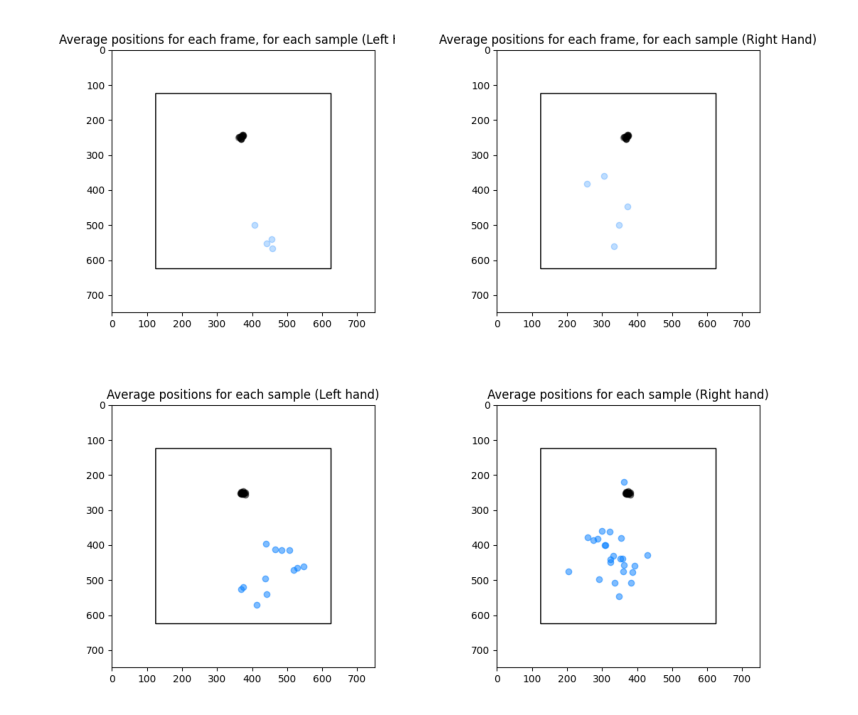

In [227]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

for ax, fig in zip(axes.flatten(), ines_plots):
    img = fig_to_array(fig)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout(pad=-5)
plt.show()

### -

In [147]:
interim_landmarks_path = path_to_root + '/data/interim/Debug/landmarks/'
left_hand = []
right_hand = []
face = []
left_hand_xys = []
right_hand_xys = []
face_xys = []
for i, row in analysis_info.iterrows():
    fn = row['metadata_filename']
    trimmed_fn = fn.replace('.mp4', '_aligned.npy')
    
    start_frame = row['metadata_start_frame']
    end_frame = row['metadata_end_frame']

    landmarks_path = interim_landmarks_path + trimmed_fn
    landmarks = np.load(landmarks_path, allow_pickle=True)
    
    stationary_frames = landmarks #np.concatenate([landmarks[:start_frame], landmarks[end_frame:]])

    left_hand_avgs = []
    right_hand_avgs = []
    face_avgs = []

    for frame in stationary_frames:
        if frame['left_hand_landmarks'] is not None:
            left_hand_xs = [lm.x for lm in frame['left_hand_landmarks'].landmark]
            left_hand_ys = [lm.y for lm in frame['left_hand_landmarks'].landmark]
            left_hand_avg_x = sum(left_hand_xs) / len(left_hand_xs)
            left_hand_avg_y = sum(left_hand_ys) / len(left_hand_ys)
            left_hand_avgs.append((left_hand_avg_x, left_hand_avg_y))
        
        if frame['right_hand_landmarks'] is not None:
            right_hand_xs = [lm.x for lm in frame['right_hand_landmarks'].landmark]
            right_hand_ys = [lm.y for lm in frame['right_hand_landmarks'].landmark]
            right_hand_avg_x = sum(right_hand_xs) / len(right_hand_xs)
            right_hand_avg_y = sum(right_hand_ys) / len(right_hand_ys)
            right_hand_avgs.append((right_hand_avg_x, right_hand_avg_y))

        if frame['face_landmarks'] is not None:
            face_xs = [lm.x for lm in frame['face_landmarks'].landmark]
            face_ys = [lm.y for lm in frame['face_landmarks'].landmark]
            face_avg_x = sum(face_xs) / len(face_xs)
            face_avg_y = sum(face_ys) / len(face_ys)
            face_avgs.append((face_avg_x, face_avg_y))
    
        left_hand_xys.append([(x,y) for x,y in zip(left_hand_xs, left_hand_ys)])
        right_hand_xys.append([(x,y) for x,y in zip(right_hand_xs, right_hand_ys)])
        # face_xys = face_xys + [(x,y) for x,y in zip(face_xs, face_ys)]

    if len(left_hand_avgs) > 0:
        left_hand.append(np.array(left_hand_avgs).mean(axis=0))
    if len(right_hand_avgs) > 0:
        right_hand.append(np.array(right_hand_avgs).mean(axis=0))
    if len(face_avgs) > 0:
        face.append(np.array(face_avgs).mean(axis=0))


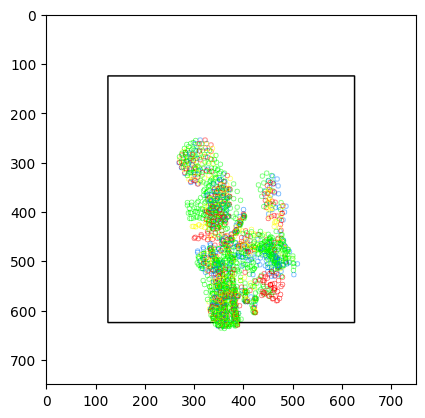

In [112]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)

for lh_xys, rh_xys, (i, row) in zip(left_hand_xys, right_hand_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    for lh, rh in zip(lh_xys, rh_xys):
        cv2.circle(canvas, (int(lh[0] * 500)+125, int(lh[1] * 500)+125), 5, color)
        # cv2.circle(canvas, (int(rh[0] * 640), int(rh[1] * 480)), 5, color, -1)
plt.imshow(canvas);

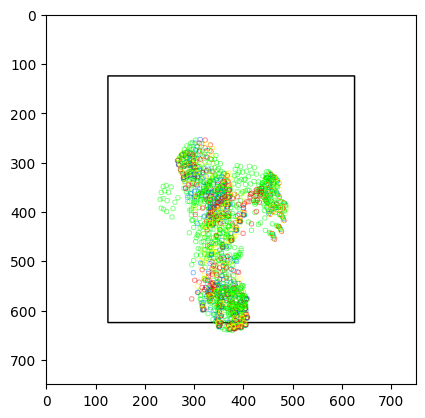

In [113]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
for lh_xys, rh_xys, (i, row) in zip(left_hand_xys, right_hand_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    color = color_dict[data]
    for lh, rh in zip(lh_xys, rh_xys):
        # cv2.circle(canvas, (int(lh[0] * 640), int(lh[1] * 480)), 5, color, -1)
        cv2.circle(canvas, (int(rh[0] * 500)+125, int(rh[1] * 500)+125), 5, color)
plt.imshow(canvas);

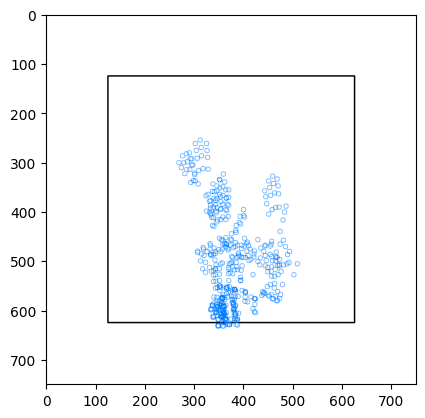

In [118]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)

for lh_xys, rh_xys, (i, row) in zip(left_hand_xys, right_hand_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    for lh, rh in zip(lh_xys, rh_xys):
        cv2.circle(canvas, (int(lh[0] * 500)+125, int(lh[1] * 500)+125), 5, color)
        # cv2.circle(canvas, (int(rh[0] * 640), int(rh[1] * 480)), 5, color, -1)
plt.imshow(canvas);

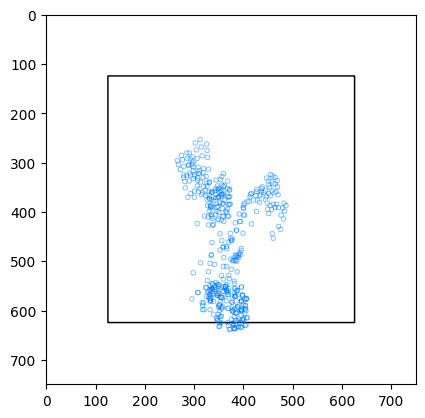

In [119]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
for lh_xys, rh_xys, (i, row) in zip(left_hand_xys, right_hand_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    for lh, rh in zip(lh_xys, rh_xys):
        # cv2.circle(canvas, (int(lh[0] * 640), int(lh[1] * 480)), 5, color, -1)
        cv2.circle(canvas, (int(rh[0] * 500)+125, int(rh[1] * 500)+125), 5, color)
plt.imshow(canvas);

In [123]:
interim_landmarks_path = path_to_root + '/data/interim/Debug/landmarks/'
left_hand = []
right_hand = []
face = []
left_hand_xys = []
right_hand_xys = []
face_xys = []
for i, row in analysis_info.iterrows():
    fn = row['metadata_filename']
    trimmed_fn = fn.replace('.mp4', '_aligned.npy')
    
    start_frame = row['metadata_start_frame']
    end_frame = row['metadata_end_frame']

    landmarks_path = interim_landmarks_path + trimmed_fn
    landmarks = np.load(landmarks_path, allow_pickle=True)
    
    stationary_frames = np.concatenate([landmarks[:start_frame], landmarks[end_frame:]])

    left_hand_avgs = []
    right_hand_avgs = []
    face_avgs = []

    for frame in stationary_frames:
        if frame['left_hand_landmarks'] is not None:
            left_hand_xs = [lm.x for lm in frame['left_hand_landmarks'].landmark]
            left_hand_ys = [lm.y for lm in frame['left_hand_landmarks'].landmark]
            left_hand_avg_x = sum(left_hand_xs) / len(left_hand_xs)
            left_hand_avg_y = sum(left_hand_ys) / len(left_hand_ys)
            left_hand_avgs.append((left_hand_avg_x, left_hand_avg_y))
        
        if frame['right_hand_landmarks'] is not None:
            right_hand_xs = [lm.x for lm in frame['right_hand_landmarks'].landmark]
            right_hand_ys = [lm.y for lm in frame['right_hand_landmarks'].landmark]
            right_hand_avg_x = sum(right_hand_xs) / len(right_hand_xs)
            right_hand_avg_y = sum(right_hand_ys) / len(right_hand_ys)
            right_hand_avgs.append((right_hand_avg_x, right_hand_avg_y))

        if frame['face_landmarks'] is not None:
            face_xs = [lm.x for lm in frame['face_landmarks'].landmark]
            face_ys = [lm.y for lm in frame['face_landmarks'].landmark]
            face_avg_x = sum(face_xs) / len(face_xs)
            face_avg_y = sum(face_ys) / len(face_ys)
            face_avgs.append((face_avg_x, face_avg_y))
    
        left_hand_xys.append([(x,y) for x,y in zip(left_hand_xs, left_hand_ys)])
        right_hand_xys.append([(x,y) for x,y in zip(right_hand_xs, right_hand_ys)])
        face_xys.append([(x,y) for x,y in zip(face_xs, face_ys)])

    if len(left_hand_avgs) > 0:
        left_hand.append(np.array(left_hand_avgs).mean(axis=0))
    if len(right_hand_avgs) > 0:
        right_hand.append(np.array(right_hand_avgs).mean(axis=0))
    if len(face_avgs) > 0:
        face.append(np.array(face_avgs).mean(axis=0))


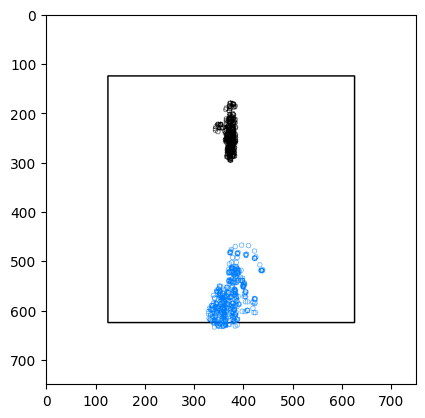

In [115]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)

for lh_xys, rh_xys, f_xys, (i, row) in zip(left_hand_xys, right_hand_xys, face_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    for lh, rh, f in zip(lh_xys, rh_xys, f_xys):
        cv2.circle(canvas, (int(f[0] * 500)+125, int(f[1] * 500)+125), 5, (0,0,0))
        cv2.circle(canvas, (int(lh[0] * 500)+125, int(lh[1] * 500)+125), 5, color)
        # cv2.circle(canvas, (int(rh[0] * 640), int(rh[1] * 480)), 5, color, -1)
plt.imshow(canvas);

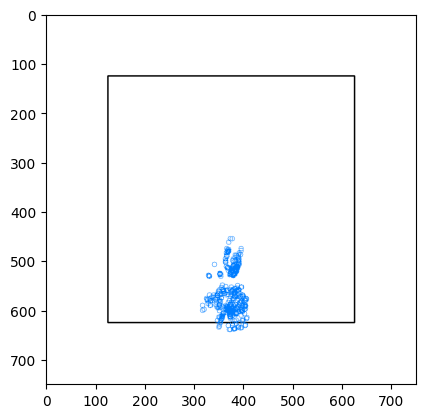

In [124]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
for lh_xys, rh_xys, (i, row) in zip(left_hand_xys, right_hand_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    for lh, rh in zip(lh_xys, rh_xys):
        # cv2.circle(canvas, (int(lh[0] * 640), int(lh[1] * 480)), 5, color, -1)
        cv2.circle(canvas, (int(rh[0] * 500)+125, int(rh[1] * 500)+125), 5, color)
plt.imshow(canvas);

In [135]:
# mean tuple from a list of tuples
np.array(rh_xys).mean(axis=0)

array([0.50180033, 0.77585515])

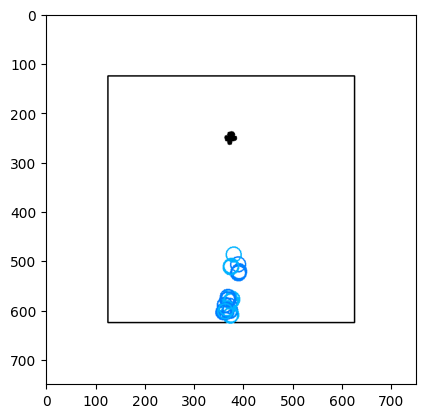

In [144]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
for lh_xys, rh_xys, f_xys, (i, row) in zip(left_hand_xys, right_hand_xys, face_xys, analysis_info.iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    mean_lh = np.array(lh_xys).mean(axis=0)
    mean_rh = np.array(rh_xys).mean(axis=0)
    mean_f =  np.array(f_xys).mean(axis=0)

    cv2.circle(canvas, (int(mean_lh[0] * 500)+125, int(mean_lh[1] * 500)+125), 15, color, 2)
    cv2.circle(canvas, (int(mean_rh[0] * 500)+125, int(mean_rh[1] * 500)+125), 15, (0,0.7,1), 2)
    cv2.circle(canvas, (int(mean_f[0] * 500)+125, int(mean_f[1] * 500)+125), 5, (0,0,0), -1)
plt.imshow(canvas);

In [146]:
left_hand_xys[0]

[(0.616812527179718, 0.7660443186759949),
 (0.5955327153205872, 0.7118459343910217),
 (0.5704699158668518, 0.6882725954055786),
 (0.5423853993415833, 0.6869712471961975),
 (0.5166890621185303, 0.692318856716156),
 (0.5407670140266418, 0.7880563735961914),
 (0.49287980794906616, 0.762812077999115),
 (0.5064334273338318, 0.7374423146247864),
 (0.5248316526412964, 0.7373102307319641),
 (0.5385879278182983, 0.8176061511039734),
 (0.491823673248291, 0.7842267751693726),
 (0.503139853477478, 0.7567459940910339),
 (0.5207794904708862, 0.7563823461532593),
 (0.5382912158966064, 0.8290145993232727),
 (0.49748659133911133, 0.7964932322502136),
 (0.5072397589683533, 0.7747765183448792),
 (0.5233596563339233, 0.7749947905540466),
 (0.5390700101852417, 0.8302828073501587),
 (0.5066497921943665, 0.8027718663215637),
 (0.5141093730926514, 0.787330150604248),
 (0.5275572538375854, 0.787327766418457)]

In [142]:
len(left_hand_xys), len(left_hand)

(3946, 117)

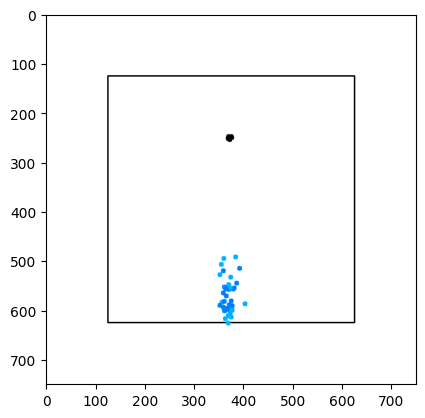

In [139]:
canvas = np.ones((750,750,3))  # White background
# Draw a 500x500 square
cv2.rectangle(canvas, (125,125), (625,625), (0,0,0), 2)
for lh, rh, f, (i, row) in zip(left_hand, right_hand, face, analysis_info.iterrows()):
    data = row.metadata_data_source
    if data != 'ne':
        continue
    color = color_dict[data]
    cv2.circle(canvas, (int(lh[0] * 500)+125, int(lh[1] * 500)+125), 5, color, -1)
    cv2.circle(canvas, (int(rh[0] * 500)+125, int(rh[1] * 500)+125), 5, (0,0.7,1), -1)
    cv2.circle(canvas, (int(f[0] * 500)+125, int(f[1] * 500)+125), 5, (0,0,0), -1)
plt.imshow(canvas);

## Checking individual cases - Landmarks

In [10]:
i = 85
metadata_row = metadata.iloc[i].copy()
raw_landmarks_path = path_to_root + f'/data/interim/RawPoseLandmarks/{pose_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
preprocessed_landmarks_path = path_to_root + f'/data/preprocessed/landmarks/{preprocess_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
video_path = path_to_root + f'/data/interim/RawCleanVideos/{metadata_row["filename"]}'
raw_landmarks = np.load(raw_landmarks_path, allow_pickle=True)
preprocessed_landmarks = np.load(preprocessed_landmarks_path, allow_pickle=True)
metadata_row

filename                             crescer_sb_2.mp4
label                                         crescer
data_source                                        sb
original_fps                                 29.97003
original_frame_count                               74
original_duration_sec                        2.469133
start_frame                                         2
end_frame                                          66
processed_frame_count                              65
processed_duration_sec                       2.168833
preprocess_version                                 v3
face_width                                   0.083436
shoulders_width                              0.194761
face_midpoint_to_shoulders_height            0.213649
left_hand_interpolated_frames                       0
right_hand_interpolated_frames                      0
original_left_hand_none_frames                      0
original_right_hand_none_frames                     0
final_left_hand_none_frames 

In [25]:
analysis_info.iloc[85]

metadata_filename                                                               crescer_sb_2.mp4
metadata_label                                                                           crescer
metadata_data_source                                                                          sb
metadata_sign_id                                                                               1
metadata_signer_number                                                                         1
                                                                                      ...       
interpolated_none_analysis_right_hand_landmarks_last_valid                                  64.0
interpolated_none_analysis_right_hand_landmarks_valid_range_total_frames                    65.0
interpolated_none_analysis_right_hand_landmarks_valid_range_none_frames                      0.0
interpolated_none_analysis_right_hand_landmarks_valid_range_frame_percentage                 0.0
interpolated_none_analysis_rig

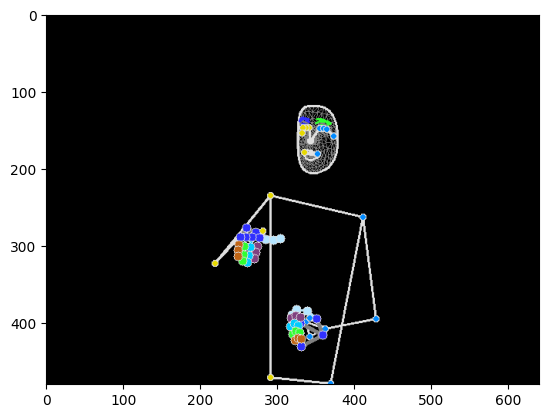

In [15]:
plot = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), raw_landmarks[20])
plt.imshow(plot);

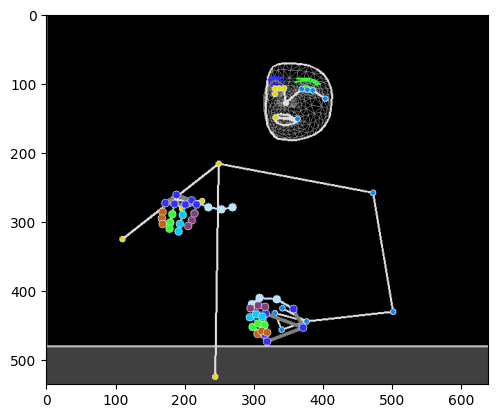

In [16]:
plot = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), preprocessed_landmarks[20])
plt.imshow(plot);